# Introduction

複数の時系列データの時系列予測を行います。


# 各種ライブラリの取得



In [1]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from copy import copy 
import time
from contextlib import contextmanager
import tensorflow as tf
from keras.callbacks import TensorBoard
from pathlib import Path
import gc

plt.style.use('ggplot')


/Users/masayaohgushi/sensor_cpu/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# 時間計測のための関数

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.10f}s".format(title, time.time() - t0))

# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [3]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

In [4]:
max(wave_data["Temp"].values)

26.3

In [5]:
production_of_gas_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/monthly-production-of-gas-in-aus-train.csv', header=None, names=["Date", "production-of-gas"])
production_of_gas_data = production_of_gas_data.sort_values(by=['Date'])

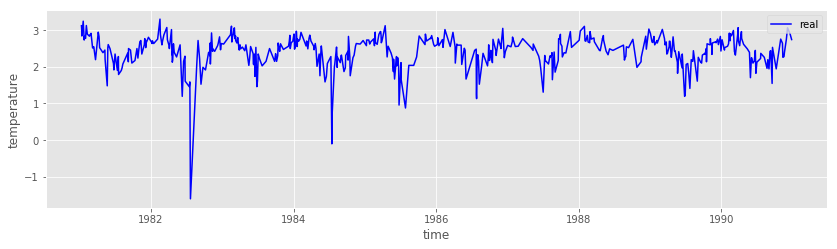

In [6]:
X_orig = np.nan_to_num(np.log(wave_data["Temp"].values + 1))
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b", ylabel='temperature'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

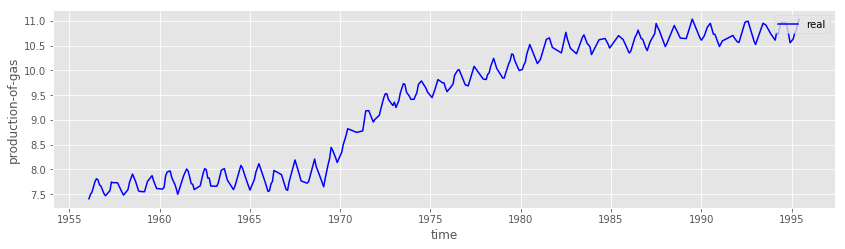

In [7]:
X_orig_second = np.nan_to_num(np.log(production_of_gas_data["production-of-gas"].values + 1))
X_day_second = production_of_gas_data["Date"].values

show_graph(X_day_second, X_orig_second, 'real', ylabel='production-of-gas')

In [8]:
print(X_orig_second.shape)
print(X_orig.shape)

(238,)
(500,)


# データの分割

- 学習データ
- テストデータ

In [9]:
X_train = X_orig[:150]
X_test = X_orig[151:238]
X_train_day = X_day[:150]
X_test_day = X_day[151:238]

X_train_second = X_orig_second[:150]
X_test_second = X_orig_second[151:238]
X_train_day_second = X_day_second[:150]
X_test_day_second = X_day_second[151:238]


# 学習データ

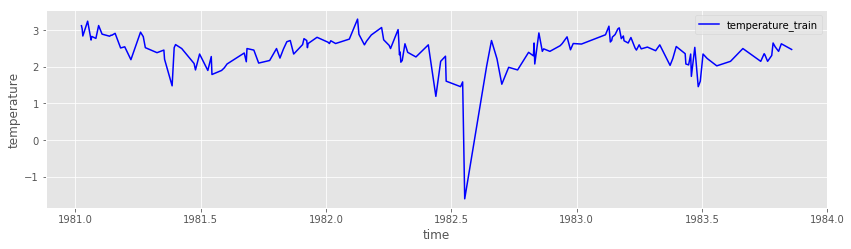

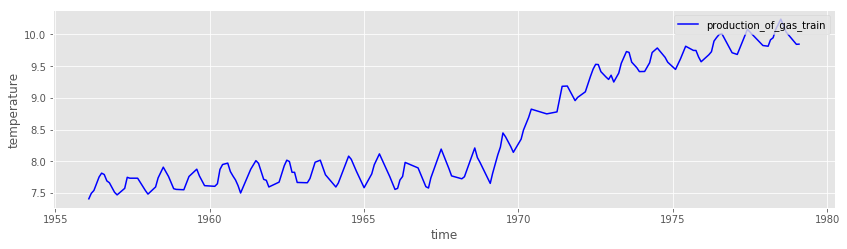

In [10]:
show_graph(X_train_day, X_train, 'temperature_train')
show_graph(X_train_day_second, X_train_second, 'production_of_gas_train')

# テストデータ

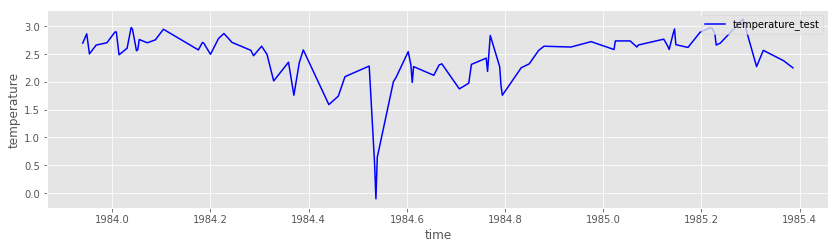

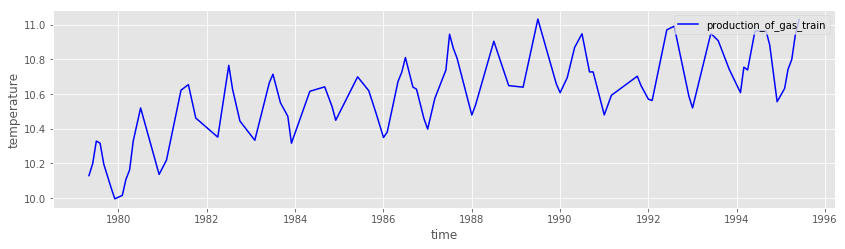

In [11]:
show_graph(X_test_day, X_test, 'temperature_test')
show_graph(X_test_day_second, X_test_second, 'production_of_gas_train')

# 前処理

- `get_data`: データを前処理して深層学習で扱える形に変換する
- `transform_data`: データを正規化して学習が容易な形に変更する。データを正規化後の値に戻して予測結果が適切か確認する

In [12]:
X_train_joint = np.vstack((X_train, X_train_second))
X_test_joint = np.vstack((X_test, X_test_second))

X_train_joint.shape

(2, 150)

In [13]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler

time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)


input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)
print('input_dim: ', input_dim)
print('timesteps: ', timesteps)

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
(150, 3, 2)
input_dim:  2
timesteps:  3


# 重み付きヘテロジニアスラーニングのCallBackクラスを設定

In [14]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-
from keras.callbacks import Callback
import numpy as np
from collections import OrderedDict


class HeteroGeniousCallbacks(Callback):

    def __init__(self,
                 variable_number: int = 2,
                 ):
        super(HeteroGeniousCallbacks, self).__init__()

        self.current_val_loss = {}
        self.class_weight = {}
        self.first_data_label = False
        self.variable_number = variable_number

    def on_train_begin(self, logs=None):
        self.first_data_label = True

    def on_epoch_end(self, epoch, logs=None):
        
        sort_logs = OrderedDict(
            sorted(logs.items(), key=lambda x: x[0]))
        print(sort_logs)
        for each_label, each_values in sort_logs.items():
            if 'val' in each_label and 'loss' in each_label:
                if self.first_data_label is True:
                    self.class_weight[each_label] = each_values
                if self.first_data_label is False:
                    each_values_tmp = each_values
                    each_value_list = np.vstack((each_values,
                                                 each_values_tmp))
                    self.class_weight[each_label] = each_value_list
                self.first_data_label = False

    def on_train_end(self, logs=None):
        self.class_weight = OrderedDict(
            sorted(self.class_weight.items(), key=lambda x: x[0]))

        val_stable_dict = {}
        for each_label, each_value_lsit in self.class_weight.items():
            val_stable_dict[each_label] = \
                np.average(each_value_lsit) + 3.0 * np.std(each_value_lsit)

        val_stable_dict = OrderedDict(
            sorted(val_stable_dict.items(), key=lambda x: x[1]))

        most_stable_value = [value for value in val_stable_dict.values()][0]

        index = 0
        tmp_class_weight = {}
        print(
            'hetero genious class weight {}'.format(self.class_weight))

        for each_label in self.class_weight.keys():
            tmp_class_weight[index] = \
                val_stable_dict[each_label] / most_stable_value
            if index >= self.variable_number - 1:
                break
            index += 1

        self.class_weight = tmp_class_weight
        print('hetero genious class weight {}'.format(self.class_weight))
hetero_genious_callbacks = HeteroGeniousCallbacks()

# 個別入力型モデル

- `create_model_individual`でモデルを作成しています。指定できるのは
   - timestepsの幅
   - ノードの数
   - 自身の状態をリセットするかしないかを指定する`stateful`(周期的な波形は`True`の方が若干良くなります。)
   - `model_option`でGRUもしくはLSTMを選択できます。
   - `optimizer`で設定したい`optimizer`を指定できます。デファオルトでは`adam`が入っています。

In [15]:
def create_model_individual(
     input_dim,
     time_steps,
     latent_dim_list,
     # データが一つしかないので1しか選べない
     batch_size=1,
     model_option='lstm',
     optimizer='adam',
):
    input_list = []
    output_list = []
    
    with tf.name_scope('Model'):
        for i in range(input_dim):
            with tf.name_scope('Input' + str(i)):    
                x = Input(shape=(time_steps, 1,))

            if model_option == 'lstm':
                with tf.name_scope('LSTM' + str(i)):
                    h = LSTM(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            elif model_option == 'gru':
                with tf.name_scope('GRU' + str(i)):
                    h = GRU(latent_dim_list[i], stateful=False, return_sequences=True)(x)
            
            with tf.name_scope('Dense' + str(i)):
                out = Dense(1)(h)
            input_list.append(x)
            output_list.append(out)

        model = Model(inputs=input_list, outputs=output_list)
        model.summary()
        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# 個別入力型のためのデータ準備

In [16]:
def prepare_data_individual(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x_reshape = []
    for i in range(x.shape[0]):
        x_reshape.append([x[i]])
    x_reshape = np.array(x_reshape)
    x_reshape = np.swapaxes(x_reshape, 1, 2)
    x_reshape = np.swapaxes(x_reshape, 2, 3)
    return list(x_reshape), scaler
   

x, scaler = prepare_data_individual(X_train_joint, time_steps, variable_number)
print(len(x))

(2, 150)
(150, 2)
before max 3.126760535960395
Normalize
after max 0.3982653990092887
(2, 150)
2


# 個別入力型モデルの予測関数

In [17]:
def predict_model_show_graph_individual(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    with timer('predict'):
        preds = model.predict(prepare_value)
    prepare_value = np.array(prepare_value)
    preds = np.array(preds)
    
    print('prepare_value: ', prepare_value.shape)
    print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[0]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[i, :, 0, 0], color='r', label='data')
        plt.plot(preds[i, :, 0, 0], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(list(preds), list(prepare_value)))
    return preds, prepare_value
    # return predict_scale, x_scale

# 個別入力モデルの定義

In [18]:
predict_list = []
var_list = []

model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 3, 120)       58560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 3, 150)       91200       input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (D

# 個別入力モデルの学習

In [19]:
log_dir = 'model_normal'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

with timer('train model individual'):
    model.fit(x, x, validation_split=0.1, epochs=1000, callbacks=[tensorboard])


Train on 135 samples, validate on 15 samples
Epoch 1/1000
135/135 [==============================] - 1s 7ms/step - loss: 0.7178 - dense_1_loss: 0.0635 - dense_2_loss: 0.6543 - dense_1_mean_squared_error: 0.0635 - dense_2_mean_squared_error: 0.6543 - val_loss: 0.6058 - val_dense_1_loss: 0.0350 - val_dense_2_loss: 0.5708 - val_dense_1_mean_squared_error: 0.0350 - val_dense_2_mean_squared_error: 0.5708
Epoch 2/1000
135/135 [==============================] - 0s 223us/step - loss: 0.5358 - dense_1_loss: 0.0457 - dense_2_loss: 0.4900 - dense_1_mean_squared_error: 0.0457 - dense_2_mean_squared_error: 0.4900 - val_loss: 0.4497 - val_dense_1_loss: 0.0257 - val_dense_2_loss: 0.4240 - val_dense_1_mean_squared_error: 0.0257 - val_dense_2_mean_squared_error: 0.4240
Epoch 3/1000
135/135 [==============================] - 0s 235us/step - loss: 0.3840 - dense_1_loss: 0.0322 - dense_2_loss: 0.3518 - dense_1_mean_squared_error: 0.0322 - dense_2_mean_squared_error: 0.3518 - val_loss: 0.3246 - val_dense_1

Epoch 24/1000
135/135 [==============================] - 0s 233us/step - loss: 0.0237 - dense_1_loss: 0.0065 - dense_2_loss: 0.0172 - dense_1_mean_squared_error: 0.0065 - dense_2_mean_squared_error: 0.0172 - val_loss: 0.0614 - val_dense_1_loss: 0.0107 - val_dense_2_loss: 0.0507 - val_dense_1_mean_squared_error: 0.0107 - val_dense_2_mean_squared_error: 0.0507
Epoch 25/1000
135/135 [==============================] - 0s 226us/step - loss: 0.0211 - dense_1_loss: 0.0060 - dense_2_loss: 0.0151 - dense_1_mean_squared_error: 0.0060 - dense_2_mean_squared_error: 0.0151 - val_loss: 0.0590 - val_dense_1_loss: 0.0102 - val_dense_2_loss: 0.0488 - val_dense_1_mean_squared_error: 0.0102 - val_dense_2_mean_squared_error: 0.0488
Epoch 26/1000
135/135 [==============================] - 0s 226us/step - loss: 0.0186 - dense_1_loss: 0.0055 - dense_2_loss: 0.0132 - dense_1_mean_squared_error: 0.0055 - dense_2_mean_squared_error: 0.0132 - val_loss: 0.0568 - val_dense_1_loss: 0.0097 - val_dense_2_loss: 0.0471

Epoch 47/1000
135/135 [==============================] - 0s 229us/step - loss: 0.0028 - dense_1_loss: 0.0012 - dense_2_loss: 0.0016 - dense_1_mean_squared_error: 0.0012 - dense_2_mean_squared_error: 0.0016 - val_loss: 0.0397 - val_dense_1_loss: 0.0039 - val_dense_2_loss: 0.0357 - val_dense_1_mean_squared_error: 0.0039 - val_dense_2_mean_squared_error: 0.0357
Epoch 48/1000
135/135 [==============================] - 0s 237us/step - loss: 0.0027 - dense_1_loss: 0.0011 - dense_2_loss: 0.0016 - dense_1_mean_squared_error: 0.0011 - dense_2_mean_squared_error: 0.0016 - val_loss: 0.0392 - val_dense_1_loss: 0.0037 - val_dense_2_loss: 0.0355 - val_dense_1_mean_squared_error: 0.0037 - val_dense_2_mean_squared_error: 0.0355
Epoch 49/1000
135/135 [==============================] - 0s 232us/step - loss: 0.0027 - dense_1_loss: 0.0010 - dense_2_loss: 0.0016 - dense_1_mean_squared_error: 0.0010 - dense_2_mean_squared_error: 0.0016 - val_loss: 0.0389 - val_dense_1_loss: 0.0036 - val_dense_2_loss: 0.0354

135/135 [==============================] - 0s 227us/step - loss: 0.0017 - dense_1_loss: 2.1456e-04 - dense_2_loss: 0.0014 - dense_1_mean_squared_error: 2.1456e-04 - dense_2_mean_squared_error: 0.0014 - val_loss: 0.0325 - val_dense_1_loss: 6.7125e-04 - val_dense_2_loss: 0.0319 - val_dense_1_mean_squared_error: 6.7125e-04 - val_dense_2_mean_squared_error: 0.0319
Epoch 70/1000
135/135 [==============================] - 0s 215us/step - loss: 0.0017 - dense_1_loss: 1.9576e-04 - dense_2_loss: 0.0015 - dense_1_mean_squared_error: 1.9576e-04 - dense_2_mean_squared_error: 0.0015 - val_loss: 0.0323 - val_dense_1_loss: 5.9605e-04 - val_dense_2_loss: 0.0317 - val_dense_1_mean_squared_error: 5.9605e-04 - val_dense_2_mean_squared_error: 0.0317
Epoch 71/1000
135/135 [==============================] - 0s 223us/step - loss: 0.0016 - dense_1_loss: 1.7558e-04 - dense_2_loss: 0.0014 - dense_1_mean_squared_error: 1.7558e-04 - dense_2_mean_squared_error: 0.0014 - val_loss: 0.0320 - val_dense_1_loss: 5.0895e

Epoch 91/1000
135/135 [==============================] - 0s 221us/step - loss: 0.0013 - dense_1_loss: 2.5257e-05 - dense_2_loss: 0.0013 - dense_1_mean_squared_error: 2.5257e-05 - dense_2_mean_squared_error: 0.0013 - val_loss: 0.0278 - val_dense_1_loss: 5.3560e-05 - val_dense_2_loss: 0.0278 - val_dense_1_mean_squared_error: 5.3560e-05 - val_dense_2_mean_squared_error: 0.0278
Epoch 92/1000
135/135 [==============================] - 0s 233us/step - loss: 0.0013 - dense_1_loss: 2.3420e-05 - dense_2_loss: 0.0013 - dense_1_mean_squared_error: 2.3420e-05 - dense_2_mean_squared_error: 0.0013 - val_loss: 0.0277 - val_dense_1_loss: 4.8903e-05 - val_dense_2_loss: 0.0276 - val_dense_1_mean_squared_error: 4.8903e-05 - val_dense_2_mean_squared_error: 0.0276
Epoch 93/1000
135/135 [==============================] - 0s 230us/step - loss: 0.0013 - dense_1_loss: 2.1431e-05 - dense_2_loss: 0.0012 - dense_1_mean_squared_error: 2.1431e-05 - dense_2_mean_squared_error: 0.0012 - val_loss: 0.0274 - val_dense_1

Epoch 113/1000
135/135 [==============================] - 0s 228us/step - loss: 0.0011 - dense_1_loss: 6.7529e-06 - dense_2_loss: 0.0011 - dense_1_mean_squared_error: 6.7529e-06 - dense_2_mean_squared_error: 0.0011 - val_loss: 0.0239 - val_dense_1_loss: 1.0570e-05 - val_dense_2_loss: 0.0239 - val_dense_1_mean_squared_error: 1.0570e-05 - val_dense_2_mean_squared_error: 0.0239
Epoch 114/1000
135/135 [==============================] - 0s 227us/step - loss: 0.0011 - dense_1_loss: 6.5168e-06 - dense_2_loss: 0.0011 - dense_1_mean_squared_error: 6.5168e-06 - dense_2_mean_squared_error: 0.0011 - val_loss: 0.0238 - val_dense_1_loss: 1.0200e-05 - val_dense_2_loss: 0.0238 - val_dense_1_mean_squared_error: 1.0200e-05 - val_dense_2_mean_squared_error: 0.0238
Epoch 115/1000
135/135 [==============================] - 0s 225us/step - loss: 0.0011 - dense_1_loss: 6.3481e-06 - dense_2_loss: 0.0011 - dense_1_mean_squared_error: 6.3481e-06 - dense_2_mean_squared_error: 0.0011 - val_loss: 0.0236 - val_dens

135/135 [==============================] - 0s 222us/step - loss: 9.4742e-04 - dense_1_loss: 4.7642e-06 - dense_2_loss: 9.4266e-04 - dense_1_mean_squared_error: 4.7642e-06 - dense_2_mean_squared_error: 9.4266e-04 - val_loss: 0.0208 - val_dense_1_loss: 6.5800e-06 - val_dense_2_loss: 0.0208 - val_dense_1_mean_squared_error: 6.5800e-06 - val_dense_2_mean_squared_error: 0.0208
Epoch 135/1000
135/135 [==============================] - 0s 239us/step - loss: 9.4424e-04 - dense_1_loss: 4.7781e-06 - dense_2_loss: 9.3946e-04 - dense_1_mean_squared_error: 4.7781e-06 - dense_2_mean_squared_error: 9.3946e-04 - val_loss: 0.0207 - val_dense_1_loss: 6.4710e-06 - val_dense_2_loss: 0.0207 - val_dense_1_mean_squared_error: 6.4710e-06 - val_dense_2_mean_squared_error: 0.0207
Epoch 136/1000
135/135 [==============================] - 0s 241us/step - loss: 9.3674e-04 - dense_1_loss: 4.7182e-06 - dense_2_loss: 9.3203e-04 - dense_1_mean_squared_error: 4.7182e-06 - dense_2_mean_squared_error: 9.3203e-04 - val_lo

135/135 [==============================] - 0s 200us/step - loss: 8.5314e-04 - dense_1_loss: 4.3509e-06 - dense_2_loss: 8.4879e-04 - dense_1_mean_squared_error: 4.3509e-06 - dense_2_mean_squared_error: 8.4879e-04 - val_loss: 0.0183 - val_dense_1_loss: 6.0434e-06 - val_dense_2_loss: 0.0183 - val_dense_1_mean_squared_error: 6.0434e-06 - val_dense_2_mean_squared_error: 0.0183
Epoch 156/1000
135/135 [==============================] - 0s 200us/step - loss: 8.3513e-04 - dense_1_loss: 4.3369e-06 - dense_2_loss: 8.3080e-04 - dense_1_mean_squared_error: 4.3369e-06 - dense_2_mean_squared_error: 8.3080e-04 - val_loss: 0.0183 - val_dense_1_loss: 6.1266e-06 - val_dense_2_loss: 0.0183 - val_dense_1_mean_squared_error: 6.1266e-06 - val_dense_2_mean_squared_error: 0.0183
Epoch 157/1000
135/135 [==============================] - 0s 210us/step - loss: 8.2840e-04 - dense_1_loss: 4.3685e-06 - dense_2_loss: 8.2403e-04 - dense_1_mean_squared_error: 4.3685e-06 - dense_2_mean_squared_error: 8.2403e-04 - val_lo

135/135 [==============================] - 0s 229us/step - loss: 7.4166e-04 - dense_1_loss: 4.0559e-06 - dense_2_loss: 7.3761e-04 - dense_1_mean_squared_error: 4.0559e-06 - dense_2_mean_squared_error: 7.3761e-04 - val_loss: 0.0164 - val_dense_1_loss: 5.4485e-06 - val_dense_2_loss: 0.0164 - val_dense_1_mean_squared_error: 5.4485e-06 - val_dense_2_mean_squared_error: 0.0164
Epoch 177/1000
135/135 [==============================] - 0s 224us/step - loss: 7.3594e-04 - dense_1_loss: 4.0472e-06 - dense_2_loss: 7.3189e-04 - dense_1_mean_squared_error: 4.0472e-06 - dense_2_mean_squared_error: 7.3189e-04 - val_loss: 0.0164 - val_dense_1_loss: 5.4757e-06 - val_dense_2_loss: 0.0164 - val_dense_1_mean_squared_error: 5.4757e-06 - val_dense_2_mean_squared_error: 0.0164
Epoch 178/1000
135/135 [==============================] - 0s 225us/step - loss: 7.2938e-04 - dense_1_loss: 4.0447e-06 - dense_2_loss: 7.2533e-04 - dense_1_mean_squared_error: 4.0447e-06 - dense_2_mean_squared_error: 7.2533e-04 - val_lo

135/135 [==============================] - 0s 228us/step - loss: 6.5738e-04 - dense_1_loss: 3.7757e-06 - dense_2_loss: 6.5361e-04 - dense_1_mean_squared_error: 3.7757e-06 - dense_2_mean_squared_error: 6.5361e-04 - val_loss: 0.0150 - val_dense_1_loss: 5.1487e-06 - val_dense_2_loss: 0.0150 - val_dense_1_mean_squared_error: 5.1487e-06 - val_dense_2_mean_squared_error: 0.0150
Epoch 198/1000
135/135 [==============================] - 0s 226us/step - loss: 6.5497e-04 - dense_1_loss: 3.7649e-06 - dense_2_loss: 6.5121e-04 - dense_1_mean_squared_error: 3.7649e-06 - dense_2_mean_squared_error: 6.5121e-04 - val_loss: 0.0149 - val_dense_1_loss: 5.1129e-06 - val_dense_2_loss: 0.0149 - val_dense_1_mean_squared_error: 5.1129e-06 - val_dense_2_mean_squared_error: 0.0149
Epoch 199/1000
135/135 [==============================] - 0s 206us/step - loss: 6.5030e-04 - dense_1_loss: 3.7448e-06 - dense_2_loss: 6.4655e-04 - dense_1_mean_squared_error: 3.7448e-06 - dense_2_mean_squared_error: 6.4655e-04 - val_lo

135/135 [==============================] - 0s 231us/step - loss: 5.8246e-04 - dense_1_loss: 3.5331e-06 - dense_2_loss: 5.7892e-04 - dense_1_mean_squared_error: 3.5331e-06 - dense_2_mean_squared_error: 5.7892e-04 - val_loss: 0.0138 - val_dense_1_loss: 4.4883e-06 - val_dense_2_loss: 0.0138 - val_dense_1_mean_squared_error: 4.4883e-06 - val_dense_2_mean_squared_error: 0.0138
Epoch 219/1000
135/135 [==============================] - 0s 232us/step - loss: 5.7179e-04 - dense_1_loss: 3.5216e-06 - dense_2_loss: 5.6827e-04 - dense_1_mean_squared_error: 3.5216e-06 - dense_2_mean_squared_error: 5.6827e-04 - val_loss: 0.0137 - val_dense_1_loss: 4.5254e-06 - val_dense_2_loss: 0.0137 - val_dense_1_mean_squared_error: 4.5254e-06 - val_dense_2_mean_squared_error: 0.0137
Epoch 220/1000
135/135 [==============================] - 0s 237us/step - loss: 5.6951e-04 - dense_1_loss: 3.5084e-06 - dense_2_loss: 5.6600e-04 - dense_1_mean_squared_error: 3.5084e-06 - dense_2_mean_squared_error: 5.6600e-04 - val_lo

135/135 [==============================] - 0s 202us/step - loss: 5.0874e-04 - dense_1_loss: 3.3362e-06 - dense_2_loss: 5.0540e-04 - dense_1_mean_squared_error: 3.3362e-06 - dense_2_mean_squared_error: 5.0540e-04 - val_loss: 0.0128 - val_dense_1_loss: 4.7329e-06 - val_dense_2_loss: 0.0128 - val_dense_1_mean_squared_error: 4.7329e-06 - val_dense_2_mean_squared_error: 0.0128
Epoch 240/1000
135/135 [==============================] - 0s 220us/step - loss: 4.9949e-04 - dense_1_loss: 3.2795e-06 - dense_2_loss: 4.9621e-04 - dense_1_mean_squared_error: 3.2795e-06 - dense_2_mean_squared_error: 4.9621e-04 - val_loss: 0.0127 - val_dense_1_loss: 4.7556e-06 - val_dense_2_loss: 0.0127 - val_dense_1_mean_squared_error: 4.7556e-06 - val_dense_2_mean_squared_error: 0.0127
Epoch 241/1000
135/135 [==============================] - 0s 218us/step - loss: 4.9669e-04 - dense_1_loss: 3.2317e-06 - dense_2_loss: 4.9346e-04 - dense_1_mean_squared_error: 3.2317e-06 - dense_2_mean_squared_error: 4.9346e-04 - val_lo

135/135 [==============================] - 0s 211us/step - loss: 4.3021e-04 - dense_1_loss: 3.0561e-06 - dense_2_loss: 4.2716e-04 - dense_1_mean_squared_error: 3.0561e-06 - dense_2_mean_squared_error: 4.2716e-04 - val_loss: 0.0118 - val_dense_1_loss: 4.3330e-06 - val_dense_2_loss: 0.0118 - val_dense_1_mean_squared_error: 4.3330e-06 - val_dense_2_mean_squared_error: 0.0118
Epoch 261/1000
135/135 [==============================] - 0s 219us/step - loss: 4.2925e-04 - dense_1_loss: 3.0010e-06 - dense_2_loss: 4.2624e-04 - dense_1_mean_squared_error: 3.0010e-06 - dense_2_mean_squared_error: 4.2624e-04 - val_loss: 0.0118 - val_dense_1_loss: 4.3722e-06 - val_dense_2_loss: 0.0117 - val_dense_1_mean_squared_error: 4.3722e-06 - val_dense_2_mean_squared_error: 0.0117
Epoch 262/1000
135/135 [==============================] - 0s 223us/step - loss: 4.2610e-04 - dense_1_loss: 3.0393e-06 - dense_2_loss: 4.2306e-04 - dense_1_mean_squared_error: 3.0393e-06 - dense_2_mean_squared_error: 4.2306e-04 - val_lo

135/135 [==============================] - 0s 203us/step - loss: 3.6453e-04 - dense_1_loss: 2.7973e-06 - dense_2_loss: 3.6173e-04 - dense_1_mean_squared_error: 2.7973e-06 - dense_2_mean_squared_error: 3.6173e-04 - val_loss: 0.0108 - val_dense_1_loss: 4.0063e-06 - val_dense_2_loss: 0.0108 - val_dense_1_mean_squared_error: 4.0063e-06 - val_dense_2_mean_squared_error: 0.0108
Epoch 282/1000
135/135 [==============================] - 0s 218us/step - loss: 3.6074e-04 - dense_1_loss: 2.8176e-06 - dense_2_loss: 3.5792e-04 - dense_1_mean_squared_error: 2.8176e-06 - dense_2_mean_squared_error: 3.5792e-04 - val_loss: 0.0108 - val_dense_1_loss: 3.9949e-06 - val_dense_2_loss: 0.0108 - val_dense_1_mean_squared_error: 3.9949e-06 - val_dense_2_mean_squared_error: 0.0108
Epoch 283/1000
135/135 [==============================] - 0s 216us/step - loss: 3.5966e-04 - dense_1_loss: 2.7859e-06 - dense_2_loss: 3.5687e-04 - dense_1_mean_squared_error: 2.7859e-06 - dense_2_mean_squared_error: 3.5687e-04 - val_lo

135/135 [==============================] - 0s 269us/step - loss: 3.0568e-04 - dense_1_loss: 2.6391e-06 - dense_2_loss: 3.0304e-04 - dense_1_mean_squared_error: 2.6391e-06 - dense_2_mean_squared_error: 3.0304e-04 - val_loss: 0.0099 - val_dense_1_loss: 3.7420e-06 - val_dense_2_loss: 0.0099 - val_dense_1_mean_squared_error: 3.7420e-06 - val_dense_2_mean_squared_error: 0.0099
Epoch 303/1000
135/135 [==============================] - 0s 247us/step - loss: 3.0418e-04 - dense_1_loss: 2.5789e-06 - dense_2_loss: 3.0160e-04 - dense_1_mean_squared_error: 2.5789e-06 - dense_2_mean_squared_error: 3.0160e-04 - val_loss: 0.0099 - val_dense_1_loss: 3.6646e-06 - val_dense_2_loss: 0.0099 - val_dense_1_mean_squared_error: 3.6646e-06 - val_dense_2_mean_squared_error: 0.0099
Epoch 304/1000
135/135 [==============================] - 0s 246us/step - loss: 3.0036e-04 - dense_1_loss: 2.5734e-06 - dense_2_loss: 2.9778e-04 - dense_1_mean_squared_error: 2.5734e-06 - dense_2_mean_squared_error: 2.9778e-04 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 2.5411e-04 - dense_1_loss: 2.3910e-06 - dense_2_loss: 2.5172e-04 - dense_1_mean_squared_error: 2.3910e-06 - dense_2_mean_squared_error: 2.5172e-04 - val_loss: 0.0090 - val_dense_1_loss: 3.4221e-06 - val_dense_2_loss: 0.0090 - val_dense_1_mean_squared_error: 3.4221e-06 - val_dense_2_mean_squared_error: 0.0090
Epoch 324/1000
135/135 [==============================] - 0s 254us/step - loss: 2.5340e-04 - dense_1_loss: 2.4013e-06 - dense_2_loss: 2.5100e-04 - dense_1_mean_squared_error: 2.4013e-06 - dense_2_mean_squared_error: 2.5100e-04 - val_loss: 0.0090 - val_dense_1_loss: 3.3454e-06 - val_dense_2_loss: 0.0090 - val_dense_1_mean_squared_error: 3.3454e-06 - val_dense_2_mean_squared_error: 0.0090
Epoch 325/1000
135/135 [==============================] - 0s 233us/step - loss: 2.5355e-04 - dense_1_loss: 2.3823e-06 - dense_2_loss: 2.5117e-04 - dense_1_mean_squared_error: 2.3823e-06 - dense_2_mean_squared_error: 2.5117e-04 - val_lo

135/135 [==============================] - 0s 219us/step - loss: 2.1640e-04 - dense_1_loss: 2.2351e-06 - dense_2_loss: 2.1416e-04 - dense_1_mean_squared_error: 2.2351e-06 - dense_2_mean_squared_error: 2.1416e-04 - val_loss: 0.0081 - val_dense_1_loss: 3.1016e-06 - val_dense_2_loss: 0.0081 - val_dense_1_mean_squared_error: 3.1016e-06 - val_dense_2_mean_squared_error: 0.0081
Epoch 345/1000
135/135 [==============================] - 0s 259us/step - loss: 2.1065e-04 - dense_1_loss: 2.2081e-06 - dense_2_loss: 2.0844e-04 - dense_1_mean_squared_error: 2.2081e-06 - dense_2_mean_squared_error: 2.0844e-04 - val_loss: 0.0081 - val_dense_1_loss: 3.0423e-06 - val_dense_2_loss: 0.0081 - val_dense_1_mean_squared_error: 3.0423e-06 - val_dense_2_mean_squared_error: 0.0081
Epoch 346/1000
135/135 [==============================] - 0s 281us/step - loss: 2.0678e-04 - dense_1_loss: 2.1887e-06 - dense_2_loss: 2.0459e-04 - dense_1_mean_squared_error: 2.1887e-06 - dense_2_mean_squared_error: 2.0459e-04 - val_lo

135/135 [==============================] - 0s 225us/step - loss: 1.7596e-04 - dense_1_loss: 2.0413e-06 - dense_2_loss: 1.7392e-04 - dense_1_mean_squared_error: 2.0413e-06 - dense_2_mean_squared_error: 1.7392e-04 - val_loss: 0.0073 - val_dense_1_loss: 3.1156e-06 - val_dense_2_loss: 0.0073 - val_dense_1_mean_squared_error: 3.1156e-06 - val_dense_2_mean_squared_error: 0.0073
Epoch 366/1000
135/135 [==============================] - 0s 233us/step - loss: 1.7445e-04 - dense_1_loss: 2.0619e-06 - dense_2_loss: 1.7239e-04 - dense_1_mean_squared_error: 2.0619e-06 - dense_2_mean_squared_error: 1.7239e-04 - val_loss: 0.0073 - val_dense_1_loss: 3.1663e-06 - val_dense_2_loss: 0.0072 - val_dense_1_mean_squared_error: 3.1663e-06 - val_dense_2_mean_squared_error: 0.0072
Epoch 367/1000
135/135 [==============================] - 0s 225us/step - loss: 1.7144e-04 - dense_1_loss: 2.0574e-06 - dense_2_loss: 1.6938e-04 - dense_1_mean_squared_error: 2.0574e-06 - dense_2_mean_squared_error: 1.6938e-04 - val_lo

135/135 [==============================] - 0s 231us/step - loss: 1.4396e-04 - dense_1_loss: 1.8657e-06 - dense_2_loss: 1.4209e-04 - dense_1_mean_squared_error: 1.8657e-06 - dense_2_mean_squared_error: 1.4209e-04 - val_loss: 0.0066 - val_dense_1_loss: 2.8256e-06 - val_dense_2_loss: 0.0066 - val_dense_1_mean_squared_error: 2.8256e-06 - val_dense_2_mean_squared_error: 0.0066
Epoch 387/1000
135/135 [==============================] - 0s 224us/step - loss: 1.4195e-04 - dense_1_loss: 1.8614e-06 - dense_2_loss: 1.4009e-04 - dense_1_mean_squared_error: 1.8614e-06 - dense_2_mean_squared_error: 1.4009e-04 - val_loss: 0.0065 - val_dense_1_loss: 2.8577e-06 - val_dense_2_loss: 0.0065 - val_dense_1_mean_squared_error: 2.8577e-06 - val_dense_2_mean_squared_error: 0.0065
Epoch 388/1000
135/135 [==============================] - 0s 222us/step - loss: 1.4074e-04 - dense_1_loss: 1.8568e-06 - dense_2_loss: 1.3889e-04 - dense_1_mean_squared_error: 1.8568e-06 - dense_2_mean_squared_error: 1.3889e-04 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 1.2637e-04 - dense_1_loss: 1.7092e-06 - dense_2_loss: 1.2466e-04 - dense_1_mean_squared_error: 1.7092e-06 - dense_2_mean_squared_error: 1.2466e-04 - val_loss: 0.0059 - val_dense_1_loss: 2.6045e-06 - val_dense_2_loss: 0.0059 - val_dense_1_mean_squared_error: 2.6045e-06 - val_dense_2_mean_squared_error: 0.0059
Epoch 408/1000
135/135 [==============================] - 0s 233us/step - loss: 1.1993e-04 - dense_1_loss: 1.7104e-06 - dense_2_loss: 1.1822e-04 - dense_1_mean_squared_error: 1.7104e-06 - dense_2_mean_squared_error: 1.1822e-04 - val_loss: 0.0058 - val_dense_1_loss: 2.5492e-06 - val_dense_2_loss: 0.0058 - val_dense_1_mean_squared_error: 2.5492e-06 - val_dense_2_mean_squared_error: 0.0058
Epoch 409/1000
135/135 [==============================] - 0s 219us/step - loss: 1.1919e-04 - dense_1_loss: 1.6967e-06 - dense_2_loss: 1.1749e-04 - dense_1_mean_squared_error: 1.6967e-06 - dense_2_mean_squared_error: 1.1749e-04 - val_lo

135/135 [==============================] - 0s 237us/step - loss: 9.6625e-05 - dense_1_loss: 1.6092e-06 - dense_2_loss: 9.5016e-05 - dense_1_mean_squared_error: 1.6092e-06 - dense_2_mean_squared_error: 9.5016e-05 - val_loss: 0.0053 - val_dense_1_loss: 2.4229e-06 - val_dense_2_loss: 0.0053 - val_dense_1_mean_squared_error: 2.4229e-06 - val_dense_2_mean_squared_error: 0.0053
Epoch 429/1000
135/135 [==============================] - 0s 229us/step - loss: 9.6061e-05 - dense_1_loss: 1.5793e-06 - dense_2_loss: 9.4481e-05 - dense_1_mean_squared_error: 1.5793e-06 - dense_2_mean_squared_error: 9.4481e-05 - val_loss: 0.0052 - val_dense_1_loss: 2.4012e-06 - val_dense_2_loss: 0.0052 - val_dense_1_mean_squared_error: 2.4012e-06 - val_dense_2_mean_squared_error: 0.0052
Epoch 430/1000
135/135 [==============================] - 0s 235us/step - loss: 9.5979e-05 - dense_1_loss: 1.5914e-06 - dense_2_loss: 9.4387e-05 - dense_1_mean_squared_error: 1.5914e-06 - dense_2_mean_squared_error: 9.4387e-05 - val_lo

135/135 [==============================] - 0s 255us/step - loss: 8.1196e-05 - dense_1_loss: 1.4746e-06 - dense_2_loss: 7.9721e-05 - dense_1_mean_squared_error: 1.4746e-06 - dense_2_mean_squared_error: 7.9721e-05 - val_loss: 0.0048 - val_dense_1_loss: 2.3393e-06 - val_dense_2_loss: 0.0048 - val_dense_1_mean_squared_error: 2.3393e-06 - val_dense_2_mean_squared_error: 0.0048
Epoch 450/1000
135/135 [==============================] - 0s 242us/step - loss: 7.9708e-05 - dense_1_loss: 1.4536e-06 - dense_2_loss: 7.8254e-05 - dense_1_mean_squared_error: 1.4536e-06 - dense_2_mean_squared_error: 7.8254e-05 - val_loss: 0.0047 - val_dense_1_loss: 2.3108e-06 - val_dense_2_loss: 0.0047 - val_dense_1_mean_squared_error: 2.3108e-06 - val_dense_2_mean_squared_error: 0.0047
Epoch 451/1000
135/135 [==============================] - 0s 237us/step - loss: 7.8466e-05 - dense_1_loss: 1.4469e-06 - dense_2_loss: 7.7019e-05 - dense_1_mean_squared_error: 1.4469e-06 - dense_2_mean_squared_error: 7.7019e-05 - val_lo

135/135 [==============================] - 0s 208us/step - loss: 6.6702e-05 - dense_1_loss: 1.3398e-06 - dense_2_loss: 6.5363e-05 - dense_1_mean_squared_error: 1.3398e-06 - dense_2_mean_squared_error: 6.5363e-05 - val_loss: 0.0043 - val_dense_1_loss: 2.0742e-06 - val_dense_2_loss: 0.0043 - val_dense_1_mean_squared_error: 2.0742e-06 - val_dense_2_mean_squared_error: 0.0043
Epoch 471/1000
135/135 [==============================] - 0s 213us/step - loss: 6.6125e-05 - dense_1_loss: 1.3582e-06 - dense_2_loss: 6.4767e-05 - dense_1_mean_squared_error: 1.3582e-06 - dense_2_mean_squared_error: 6.4767e-05 - val_loss: 0.0043 - val_dense_1_loss: 2.1154e-06 - val_dense_2_loss: 0.0043 - val_dense_1_mean_squared_error: 2.1154e-06 - val_dense_2_mean_squared_error: 0.0043
Epoch 472/1000
135/135 [==============================] - 0s 213us/step - loss: 6.5867e-05 - dense_1_loss: 1.3242e-06 - dense_2_loss: 6.4543e-05 - dense_1_mean_squared_error: 1.3242e-06 - dense_2_mean_squared_error: 6.4543e-05 - val_lo

135/135 [==============================] - 0s 257us/step - loss: 5.4752e-05 - dense_1_loss: 1.2395e-06 - dense_2_loss: 5.3512e-05 - dense_1_mean_squared_error: 1.2395e-06 - dense_2_mean_squared_error: 5.3512e-05 - val_loss: 0.0039 - val_dense_1_loss: 2.0878e-06 - val_dense_2_loss: 0.0039 - val_dense_1_mean_squared_error: 2.0878e-06 - val_dense_2_mean_squared_error: 0.0039
Epoch 492/1000
135/135 [==============================] - 0s 250us/step - loss: 5.3836e-05 - dense_1_loss: 1.2388e-06 - dense_2_loss: 5.2597e-05 - dense_1_mean_squared_error: 1.2388e-06 - dense_2_mean_squared_error: 5.2597e-05 - val_loss: 0.0039 - val_dense_1_loss: 1.9121e-06 - val_dense_2_loss: 0.0039 - val_dense_1_mean_squared_error: 1.9121e-06 - val_dense_2_mean_squared_error: 0.0039
Epoch 493/1000
135/135 [==============================] - 0s 251us/step - loss: 5.3424e-05 - dense_1_loss: 1.2749e-06 - dense_2_loss: 5.2149e-05 - dense_1_mean_squared_error: 1.2749e-06 - dense_2_mean_squared_error: 5.2149e-05 - val_lo

135/135 [==============================] - 0s 200us/step - loss: 4.5630e-05 - dense_1_loss: 1.1339e-06 - dense_2_loss: 4.4496e-05 - dense_1_mean_squared_error: 1.1339e-06 - dense_2_mean_squared_error: 4.4496e-05 - val_loss: 0.0036 - val_dense_1_loss: 1.7926e-06 - val_dense_2_loss: 0.0036 - val_dense_1_mean_squared_error: 1.7926e-06 - val_dense_2_mean_squared_error: 0.0036
Epoch 513/1000
135/135 [==============================] - 0s 195us/step - loss: 4.5287e-05 - dense_1_loss: 1.1474e-06 - dense_2_loss: 4.4139e-05 - dense_1_mean_squared_error: 1.1474e-06 - dense_2_mean_squared_error: 4.4139e-05 - val_loss: 0.0036 - val_dense_1_loss: 1.7914e-06 - val_dense_2_loss: 0.0036 - val_dense_1_mean_squared_error: 1.7914e-06 - val_dense_2_mean_squared_error: 0.0036
Epoch 514/1000
135/135 [==============================] - 0s 205us/step - loss: 4.5279e-05 - dense_1_loss: 1.1185e-06 - dense_2_loss: 4.4161e-05 - dense_1_mean_squared_error: 1.1185e-06 - dense_2_mean_squared_error: 4.4161e-05 - val_lo

135/135 [==============================] - 0s 224us/step - loss: 3.7534e-05 - dense_1_loss: 1.0311e-06 - dense_2_loss: 3.6503e-05 - dense_1_mean_squared_error: 1.0311e-06 - dense_2_mean_squared_error: 3.6503e-05 - val_loss: 0.0033 - val_dense_1_loss: 1.7473e-06 - val_dense_2_loss: 0.0033 - val_dense_1_mean_squared_error: 1.7473e-06 - val_dense_2_mean_squared_error: 0.0033
Epoch 534/1000
135/135 [==============================] - 0s 227us/step - loss: 3.7672e-05 - dense_1_loss: 1.0572e-06 - dense_2_loss: 3.6614e-05 - dense_1_mean_squared_error: 1.0572e-06 - dense_2_mean_squared_error: 3.6614e-05 - val_loss: 0.0033 - val_dense_1_loss: 1.6956e-06 - val_dense_2_loss: 0.0033 - val_dense_1_mean_squared_error: 1.6956e-06 - val_dense_2_mean_squared_error: 0.0033
Epoch 535/1000
135/135 [==============================] - 0s 220us/step - loss: 3.7044e-05 - dense_1_loss: 1.0583e-06 - dense_2_loss: 3.5985e-05 - dense_1_mean_squared_error: 1.0583e-06 - dense_2_mean_squared_error: 3.5985e-05 - val_lo

135/135 [==============================] - 0s 222us/step - loss: 3.0719e-05 - dense_1_loss: 9.7466e-07 - dense_2_loss: 2.9745e-05 - dense_1_mean_squared_error: 9.7466e-07 - dense_2_mean_squared_error: 2.9745e-05 - val_loss: 0.0030 - val_dense_1_loss: 1.5569e-06 - val_dense_2_loss: 0.0030 - val_dense_1_mean_squared_error: 1.5569e-06 - val_dense_2_mean_squared_error: 0.0030
Epoch 555/1000
135/135 [==============================] - 0s 217us/step - loss: 3.0286e-05 - dense_1_loss: 9.6628e-07 - dense_2_loss: 2.9320e-05 - dense_1_mean_squared_error: 9.6628e-07 - dense_2_mean_squared_error: 2.9320e-05 - val_loss: 0.0030 - val_dense_1_loss: 1.6391e-06 - val_dense_2_loss: 0.0030 - val_dense_1_mean_squared_error: 1.6391e-06 - val_dense_2_mean_squared_error: 0.0030
Epoch 556/1000
135/135 [==============================] - 0s 229us/step - loss: 3.0163e-05 - dense_1_loss: 1.0073e-06 - dense_2_loss: 2.9156e-05 - dense_1_mean_squared_error: 1.0073e-06 - dense_2_mean_squared_error: 2.9156e-05 - val_lo

135/135 [==============================] - 0s 243us/step - loss: 2.5548e-05 - dense_1_loss: 8.9017e-07 - dense_2_loss: 2.4658e-05 - dense_1_mean_squared_error: 8.9017e-07 - dense_2_mean_squared_error: 2.4658e-05 - val_loss: 0.0028 - val_dense_1_loss: 1.6480e-06 - val_dense_2_loss: 0.0028 - val_dense_1_mean_squared_error: 1.6480e-06 - val_dense_2_mean_squared_error: 0.0028
Epoch 576/1000
135/135 [==============================] - 0s 217us/step - loss: 2.5368e-05 - dense_1_loss: 9.7921e-07 - dense_2_loss: 2.4389e-05 - dense_1_mean_squared_error: 9.7921e-07 - dense_2_mean_squared_error: 2.4389e-05 - val_loss: 0.0028 - val_dense_1_loss: 1.4496e-06 - val_dense_2_loss: 0.0028 - val_dense_1_mean_squared_error: 1.4496e-06 - val_dense_2_mean_squared_error: 0.0028
Epoch 577/1000
135/135 [==============================] - 0s 233us/step - loss: 2.4875e-05 - dense_1_loss: 8.8755e-07 - dense_2_loss: 2.3987e-05 - dense_1_mean_squared_error: 8.8755e-07 - dense_2_mean_squared_error: 2.3987e-05 - val_lo

135/135 [==============================] - 0s 213us/step - loss: 2.1455e-05 - dense_1_loss: 7.5932e-07 - dense_2_loss: 2.0695e-05 - dense_1_mean_squared_error: 7.5932e-07 - dense_2_mean_squared_error: 2.0695e-05 - val_loss: 0.0026 - val_dense_1_loss: 1.4444e-06 - val_dense_2_loss: 0.0026 - val_dense_1_mean_squared_error: 1.4444e-06 - val_dense_2_mean_squared_error: 0.0026
Epoch 597/1000
135/135 [==============================] - 0s 235us/step - loss: 2.1047e-05 - dense_1_loss: 7.5801e-07 - dense_2_loss: 2.0289e-05 - dense_1_mean_squared_error: 7.5801e-07 - dense_2_mean_squared_error: 2.0289e-05 - val_loss: 0.0026 - val_dense_1_loss: 1.4046e-06 - val_dense_2_loss: 0.0026 - val_dense_1_mean_squared_error: 1.4046e-06 - val_dense_2_mean_squared_error: 0.0026
Epoch 598/1000
135/135 [==============================] - 0s 223us/step - loss: 2.0412e-05 - dense_1_loss: 7.7723e-07 - dense_2_loss: 1.9634e-05 - dense_1_mean_squared_error: 7.7723e-07 - dense_2_mean_squared_error: 1.9634e-05 - val_lo

135/135 [==============================] - 0s 212us/step - loss: 1.7089e-05 - dense_1_loss: 7.2062e-07 - dense_2_loss: 1.6369e-05 - dense_1_mean_squared_error: 7.2062e-07 - dense_2_mean_squared_error: 1.6369e-05 - val_loss: 0.0024 - val_dense_1_loss: 1.4452e-06 - val_dense_2_loss: 0.0024 - val_dense_1_mean_squared_error: 1.4452e-06 - val_dense_2_mean_squared_error: 0.0024
Epoch 618/1000
135/135 [==============================] - 0s 214us/step - loss: 1.6831e-05 - dense_1_loss: 7.4301e-07 - dense_2_loss: 1.6088e-05 - dense_1_mean_squared_error: 7.4301e-07 - dense_2_mean_squared_error: 1.6088e-05 - val_loss: 0.0024 - val_dense_1_loss: 1.3498e-06 - val_dense_2_loss: 0.0024 - val_dense_1_mean_squared_error: 1.3498e-06 - val_dense_2_mean_squared_error: 0.0024
Epoch 619/1000
135/135 [==============================] - 0s 219us/step - loss: 1.6375e-05 - dense_1_loss: 7.0096e-07 - dense_2_loss: 1.5674e-05 - dense_1_mean_squared_error: 7.0096e-07 - dense_2_mean_squared_error: 1.5674e-05 - val_lo

135/135 [==============================] - 0s 208us/step - loss: 1.3756e-05 - dense_1_loss: 6.2749e-07 - dense_2_loss: 1.3128e-05 - dense_1_mean_squared_error: 6.2749e-07 - dense_2_mean_squared_error: 1.3128e-05 - val_loss: 0.0022 - val_dense_1_loss: 1.1998e-06 - val_dense_2_loss: 0.0022 - val_dense_1_mean_squared_error: 1.1998e-06 - val_dense_2_mean_squared_error: 0.0022
Epoch 639/1000
135/135 [==============================] - 0s 206us/step - loss: 1.3468e-05 - dense_1_loss: 6.4471e-07 - dense_2_loss: 1.2823e-05 - dense_1_mean_squared_error: 6.4471e-07 - dense_2_mean_squared_error: 1.2823e-05 - val_loss: 0.0022 - val_dense_1_loss: 1.0890e-06 - val_dense_2_loss: 0.0022 - val_dense_1_mean_squared_error: 1.0890e-06 - val_dense_2_mean_squared_error: 0.0022
Epoch 640/1000
135/135 [==============================] - 0s 214us/step - loss: 1.3395e-05 - dense_1_loss: 6.3199e-07 - dense_2_loss: 1.2763e-05 - dense_1_mean_squared_error: 6.3199e-07 - dense_2_mean_squared_error: 1.2763e-05 - val_lo

135/135 [==============================] - 0s 216us/step - loss: 1.0916e-05 - dense_1_loss: 5.9290e-07 - dense_2_loss: 1.0323e-05 - dense_1_mean_squared_error: 5.9290e-07 - dense_2_mean_squared_error: 1.0323e-05 - val_loss: 0.0021 - val_dense_1_loss: 1.0142e-06 - val_dense_2_loss: 0.0021 - val_dense_1_mean_squared_error: 1.0142e-06 - val_dense_2_mean_squared_error: 0.0021
Epoch 660/1000
135/135 [==============================] - 0s 213us/step - loss: 1.0826e-05 - dense_1_loss: 5.6563e-07 - dense_2_loss: 1.0261e-05 - dense_1_mean_squared_error: 5.6563e-07 - dense_2_mean_squared_error: 1.0261e-05 - val_loss: 0.0021 - val_dense_1_loss: 1.0353e-06 - val_dense_2_loss: 0.0021 - val_dense_1_mean_squared_error: 1.0353e-06 - val_dense_2_mean_squared_error: 0.0021
Epoch 661/1000
135/135 [==============================] - 0s 212us/step - loss: 1.0998e-05 - dense_1_loss: 5.6513e-07 - dense_2_loss: 1.0433e-05 - dense_1_mean_squared_error: 5.6513e-07 - dense_2_mean_squared_error: 1.0433e-05 - val_lo

135/135 [==============================] - 0s 225us/step - loss: 9.1913e-06 - dense_1_loss: 5.2112e-07 - dense_2_loss: 8.6702e-06 - dense_1_mean_squared_error: 5.2112e-07 - dense_2_mean_squared_error: 8.6702e-06 - val_loss: 0.0020 - val_dense_1_loss: 9.6122e-07 - val_dense_2_loss: 0.0020 - val_dense_1_mean_squared_error: 9.6122e-07 - val_dense_2_mean_squared_error: 0.0020
Epoch 681/1000
135/135 [==============================] - 0s 218us/step - loss: 9.1119e-06 - dense_1_loss: 5.1273e-07 - dense_2_loss: 8.5991e-06 - dense_1_mean_squared_error: 5.1273e-07 - dense_2_mean_squared_error: 8.5991e-06 - val_loss: 0.0020 - val_dense_1_loss: 9.1810e-07 - val_dense_2_loss: 0.0020 - val_dense_1_mean_squared_error: 9.1810e-07 - val_dense_2_mean_squared_error: 0.0020
Epoch 682/1000
135/135 [==============================] - 0s 234us/step - loss: 9.1207e-06 - dense_1_loss: 5.3739e-07 - dense_2_loss: 8.5833e-06 - dense_1_mean_squared_error: 5.3739e-07 - dense_2_mean_squared_error: 8.5833e-06 - val_lo

135/135 [==============================] - 0s 195us/step - loss: 7.4348e-06 - dense_1_loss: 4.9237e-07 - dense_2_loss: 6.9425e-06 - dense_1_mean_squared_error: 4.9237e-07 - dense_2_mean_squared_error: 6.9425e-06 - val_loss: 0.0018 - val_dense_1_loss: 7.9220e-07 - val_dense_2_loss: 0.0018 - val_dense_1_mean_squared_error: 7.9220e-07 - val_dense_2_mean_squared_error: 0.0018
Epoch 702/1000
135/135 [==============================] - 0s 212us/step - loss: 7.2453e-06 - dense_1_loss: 4.7354e-07 - dense_2_loss: 6.7718e-06 - dense_1_mean_squared_error: 4.7354e-07 - dense_2_mean_squared_error: 6.7718e-06 - val_loss: 0.0018 - val_dense_1_loss: 8.3620e-07 - val_dense_2_loss: 0.0018 - val_dense_1_mean_squared_error: 8.3620e-07 - val_dense_2_mean_squared_error: 0.0018
Epoch 703/1000
135/135 [==============================] - 0s 217us/step - loss: 7.5113e-06 - dense_1_loss: 4.8139e-07 - dense_2_loss: 7.0299e-06 - dense_1_mean_squared_error: 4.8139e-07 - dense_2_mean_squared_error: 7.0299e-06 - val_lo

135/135 [==============================] - 0s 219us/step - loss: 6.1945e-06 - dense_1_loss: 4.5755e-07 - dense_2_loss: 5.7370e-06 - dense_1_mean_squared_error: 4.5755e-07 - dense_2_mean_squared_error: 5.7370e-06 - val_loss: 0.0017 - val_dense_1_loss: 9.1025e-07 - val_dense_2_loss: 0.0017 - val_dense_1_mean_squared_error: 9.1025e-07 - val_dense_2_mean_squared_error: 0.0017
Epoch 723/1000
135/135 [==============================] - 0s 216us/step - loss: 6.0483e-06 - dense_1_loss: 4.5852e-07 - dense_2_loss: 5.5898e-06 - dense_1_mean_squared_error: 4.5852e-07 - dense_2_mean_squared_error: 5.5898e-06 - val_loss: 0.0017 - val_dense_1_loss: 1.0001e-06 - val_dense_2_loss: 0.0017 - val_dense_1_mean_squared_error: 1.0001e-06 - val_dense_2_mean_squared_error: 0.0017
Epoch 724/1000
135/135 [==============================] - 0s 213us/step - loss: 6.0252e-06 - dense_1_loss: 4.5565e-07 - dense_2_loss: 5.5695e-06 - dense_1_mean_squared_error: 4.5565e-07 - dense_2_mean_squared_error: 5.5695e-06 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 4.9182e-06 - dense_1_loss: 4.0325e-07 - dense_2_loss: 4.5150e-06 - dense_1_mean_squared_error: 4.0325e-07 - dense_2_mean_squared_error: 4.5150e-06 - val_loss: 0.0017 - val_dense_1_loss: 6.7171e-07 - val_dense_2_loss: 0.0017 - val_dense_1_mean_squared_error: 6.7171e-07 - val_dense_2_mean_squared_error: 0.0017
Epoch 744/1000
135/135 [==============================] - 0s 239us/step - loss: 4.8118e-06 - dense_1_loss: 3.8302e-07 - dense_2_loss: 4.4288e-06 - dense_1_mean_squared_error: 3.8302e-07 - dense_2_mean_squared_error: 4.4288e-06 - val_loss: 0.0017 - val_dense_1_loss: 7.1530e-07 - val_dense_2_loss: 0.0017 - val_dense_1_mean_squared_error: 7.1530e-07 - val_dense_2_mean_squared_error: 0.0017
Epoch 745/1000
135/135 [==============================] - 0s 201us/step - loss: 4.9813e-06 - dense_1_loss: 4.4682e-07 - dense_2_loss: 4.5345e-06 - dense_1_mean_squared_error: 4.4682e-07 - dense_2_mean_squared_error: 4.5345e-06 - val_lo

135/135 [==============================] - 0s 217us/step - loss: 4.4375e-06 - dense_1_loss: 4.0075e-07 - dense_2_loss: 4.0368e-06 - dense_1_mean_squared_error: 4.0075e-07 - dense_2_mean_squared_error: 4.0368e-06 - val_loss: 0.0016 - val_dense_1_loss: 5.9577e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 5.9577e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 765/1000
135/135 [==============================] - 0s 223us/step - loss: 4.5287e-06 - dense_1_loss: 3.9650e-07 - dense_2_loss: 4.1322e-06 - dense_1_mean_squared_error: 3.9650e-07 - dense_2_mean_squared_error: 4.1322e-06 - val_loss: 0.0016 - val_dense_1_loss: 6.2720e-07 - val_dense_2_loss: 0.0016 - val_dense_1_mean_squared_error: 6.2720e-07 - val_dense_2_mean_squared_error: 0.0016
Epoch 766/1000
135/135 [==============================] - 0s 223us/step - loss: 4.4664e-06 - dense_1_loss: 3.6620e-07 - dense_2_loss: 4.1002e-06 - dense_1_mean_squared_error: 3.6620e-07 - dense_2_mean_squared_error: 4.1002e-06 - val_lo

135/135 [==============================] - 0s 222us/step - loss: 3.6210e-06 - dense_1_loss: 3.5003e-07 - dense_2_loss: 3.2710e-06 - dense_1_mean_squared_error: 3.5003e-07 - dense_2_mean_squared_error: 3.2710e-06 - val_loss: 0.0015 - val_dense_1_loss: 6.5513e-07 - val_dense_2_loss: 0.0015 - val_dense_1_mean_squared_error: 6.5513e-07 - val_dense_2_mean_squared_error: 0.0015
Epoch 786/1000
135/135 [==============================] - 0s 220us/step - loss: 3.6140e-06 - dense_1_loss: 3.2792e-07 - dense_2_loss: 3.2860e-06 - dense_1_mean_squared_error: 3.2792e-07 - dense_2_mean_squared_error: 3.2860e-06 - val_loss: 0.0015 - val_dense_1_loss: 5.9649e-07 - val_dense_2_loss: 0.0015 - val_dense_1_mean_squared_error: 5.9649e-07 - val_dense_2_mean_squared_error: 0.0015
Epoch 787/1000
135/135 [==============================] - 0s 221us/step - loss: 3.8891e-06 - dense_1_loss: 3.0998e-07 - dense_2_loss: 3.5791e-06 - dense_1_mean_squared_error: 3.0998e-07 - dense_2_mean_squared_error: 3.5791e-06 - val_lo

135/135 [==============================] - 0s 220us/step - loss: 3.2942e-06 - dense_1_loss: 4.0797e-07 - dense_2_loss: 2.8862e-06 - dense_1_mean_squared_error: 4.0797e-07 - dense_2_mean_squared_error: 2.8862e-06 - val_loss: 0.0015 - val_dense_1_loss: 5.8894e-07 - val_dense_2_loss: 0.0015 - val_dense_1_mean_squared_error: 5.8894e-07 - val_dense_2_mean_squared_error: 0.0015
Epoch 807/1000
135/135 [==============================] - 0s 221us/step - loss: 3.3633e-06 - dense_1_loss: 3.4606e-07 - dense_2_loss: 3.0172e-06 - dense_1_mean_squared_error: 3.4606e-07 - dense_2_mean_squared_error: 3.0172e-06 - val_loss: 0.0015 - val_dense_1_loss: 5.3501e-07 - val_dense_2_loss: 0.0015 - val_dense_1_mean_squared_error: 5.3501e-07 - val_dense_2_mean_squared_error: 0.0015
Epoch 808/1000
135/135 [==============================] - 0s 232us/step - loss: 3.7331e-06 - dense_1_loss: 3.0590e-07 - dense_2_loss: 3.4272e-06 - dense_1_mean_squared_error: 3.0590e-07 - dense_2_mean_squared_error: 3.4272e-06 - val_lo

135/135 [==============================] - 0s 221us/step - loss: 3.2514e-06 - dense_1_loss: 2.7359e-07 - dense_2_loss: 2.9778e-06 - dense_1_mean_squared_error: 2.7359e-07 - dense_2_mean_squared_error: 2.9778e-06 - val_loss: 0.0014 - val_dense_1_loss: 4.9801e-07 - val_dense_2_loss: 0.0014 - val_dense_1_mean_squared_error: 4.9801e-07 - val_dense_2_mean_squared_error: 0.0014
Epoch 828/1000
135/135 [==============================] - 0s 236us/step - loss: 3.3914e-06 - dense_1_loss: 3.2221e-07 - dense_2_loss: 3.0692e-06 - dense_1_mean_squared_error: 3.2221e-07 - dense_2_mean_squared_error: 3.0692e-06 - val_loss: 0.0014 - val_dense_1_loss: 4.7463e-07 - val_dense_2_loss: 0.0014 - val_dense_1_mean_squared_error: 4.7463e-07 - val_dense_2_mean_squared_error: 0.0014
Epoch 829/1000
135/135 [==============================] - 0s 216us/step - loss: 3.0426e-06 - dense_1_loss: 2.5102e-07 - dense_2_loss: 2.7916e-06 - dense_1_mean_squared_error: 2.5102e-07 - dense_2_mean_squared_error: 2.7916e-06 - val_lo

135/135 [==============================] - 0s 237us/step - loss: 2.4023e-06 - dense_1_loss: 2.2813e-07 - dense_2_loss: 2.1742e-06 - dense_1_mean_squared_error: 2.2813e-07 - dense_2_mean_squared_error: 2.1742e-06 - val_loss: 0.0014 - val_dense_1_loss: 4.1435e-07 - val_dense_2_loss: 0.0014 - val_dense_1_mean_squared_error: 4.1435e-07 - val_dense_2_mean_squared_error: 0.0014
Epoch 849/1000
135/135 [==============================] - 0s 225us/step - loss: 2.3987e-06 - dense_1_loss: 2.3539e-07 - dense_2_loss: 2.1633e-06 - dense_1_mean_squared_error: 2.3539e-07 - dense_2_mean_squared_error: 2.1633e-06 - val_loss: 0.0014 - val_dense_1_loss: 3.8752e-07 - val_dense_2_loss: 0.0014 - val_dense_1_mean_squared_error: 3.8752e-07 - val_dense_2_mean_squared_error: 0.0014
Epoch 850/1000
135/135 [==============================] - 0s 231us/step - loss: 2.3182e-06 - dense_1_loss: 2.3756e-07 - dense_2_loss: 2.0806e-06 - dense_1_mean_squared_error: 2.3756e-07 - dense_2_mean_squared_error: 2.0806e-06 - val_lo

135/135 [==============================] - 0s 226us/step - loss: 2.7364e-06 - dense_1_loss: 2.1556e-07 - dense_2_loss: 2.5208e-06 - dense_1_mean_squared_error: 2.1556e-07 - dense_2_mean_squared_error: 2.5208e-06 - val_loss: 0.0013 - val_dense_1_loss: 4.4024e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 4.4024e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 870/1000
135/135 [==============================] - 0s 255us/step - loss: 2.6211e-06 - dense_1_loss: 2.0508e-07 - dense_2_loss: 2.4161e-06 - dense_1_mean_squared_error: 2.0508e-07 - dense_2_mean_squared_error: 2.4161e-06 - val_loss: 0.0013 - val_dense_1_loss: 3.9557e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 3.9557e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 871/1000
135/135 [==============================] - 0s 331us/step - loss: 2.6097e-06 - dense_1_loss: 2.0592e-07 - dense_2_loss: 2.4037e-06 - dense_1_mean_squared_error: 2.0592e-07 - dense_2_mean_squared_error: 2.4037e-06 - val_lo

135/135 [==============================] - 0s 249us/step - loss: 2.5317e-06 - dense_1_loss: 2.1819e-07 - dense_2_loss: 2.3135e-06 - dense_1_mean_squared_error: 2.1819e-07 - dense_2_mean_squared_error: 2.3135e-06 - val_loss: 0.0013 - val_dense_1_loss: 4.9602e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 4.9602e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 891/1000
135/135 [==============================] - 0s 244us/step - loss: 2.1568e-06 - dense_1_loss: 3.2388e-07 - dense_2_loss: 1.8329e-06 - dense_1_mean_squared_error: 3.2388e-07 - dense_2_mean_squared_error: 1.8329e-06 - val_loss: 0.0013 - val_dense_1_loss: 6.6142e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 6.6142e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 892/1000
135/135 [==============================] - 0s 257us/step - loss: 1.9556e-06 - dense_1_loss: 3.1607e-07 - dense_2_loss: 1.6396e-06 - dense_1_mean_squared_error: 3.1607e-07 - dense_2_mean_squared_error: 1.6396e-06 - val_lo

135/135 [==============================] - 0s 221us/step - loss: 1.7661e-06 - dense_1_loss: 1.7302e-07 - dense_2_loss: 1.5931e-06 - dense_1_mean_squared_error: 1.7302e-07 - dense_2_mean_squared_error: 1.5931e-06 - val_loss: 0.0013 - val_dense_1_loss: 3.3459e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 3.3459e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 912/1000
135/135 [==============================] - 0s 222us/step - loss: 1.8867e-06 - dense_1_loss: 1.6826e-07 - dense_2_loss: 1.7184e-06 - dense_1_mean_squared_error: 1.6826e-07 - dense_2_mean_squared_error: 1.7184e-06 - val_loss: 0.0013 - val_dense_1_loss: 3.5050e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 3.5050e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 913/1000
135/135 [==============================] - 0s 228us/step - loss: 1.9722e-06 - dense_1_loss: 1.6505e-07 - dense_2_loss: 1.8071e-06 - dense_1_mean_squared_error: 1.6505e-07 - dense_2_mean_squared_error: 1.8071e-06 - val_lo

135/135 [==============================] - 0s 232us/step - loss: 1.7489e-06 - dense_1_loss: 1.6879e-07 - dense_2_loss: 1.5801e-06 - dense_1_mean_squared_error: 1.6879e-07 - dense_2_mean_squared_error: 1.5801e-06 - val_loss: 0.0013 - val_dense_1_loss: 3.1488e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 3.1488e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 933/1000
135/135 [==============================] - 0s 228us/step - loss: 2.3289e-06 - dense_1_loss: 1.7717e-07 - dense_2_loss: 2.1517e-06 - dense_1_mean_squared_error: 1.7717e-07 - dense_2_mean_squared_error: 2.1517e-06 - val_loss: 0.0013 - val_dense_1_loss: 2.6334e-07 - val_dense_2_loss: 0.0013 - val_dense_1_mean_squared_error: 2.6334e-07 - val_dense_2_mean_squared_error: 0.0013
Epoch 934/1000
135/135 [==============================] - 0s 231us/step - loss: 2.1398e-06 - dense_1_loss: 1.9866e-07 - dense_2_loss: 1.9412e-06 - dense_1_mean_squared_error: 1.9866e-07 - dense_2_mean_squared_error: 1.9412e-06 - val_lo

135/135 [==============================] - 0s 246us/step - loss: 1.6005e-06 - dense_1_loss: 1.4826e-07 - dense_2_loss: 1.4523e-06 - dense_1_mean_squared_error: 1.4826e-07 - dense_2_mean_squared_error: 1.4523e-06 - val_loss: 0.0012 - val_dense_1_loss: 2.2807e-07 - val_dense_2_loss: 0.0012 - val_dense_1_mean_squared_error: 2.2807e-07 - val_dense_2_mean_squared_error: 0.0012
Epoch 954/1000
135/135 [==============================] - 0s 236us/step - loss: 1.5520e-06 - dense_1_loss: 1.3338e-07 - dense_2_loss: 1.4187e-06 - dense_1_mean_squared_error: 1.3338e-07 - dense_2_mean_squared_error: 1.4187e-06 - val_loss: 0.0012 - val_dense_1_loss: 3.1141e-07 - val_dense_2_loss: 0.0012 - val_dense_1_mean_squared_error: 3.1141e-07 - val_dense_2_mean_squared_error: 0.0012
Epoch 955/1000
135/135 [==============================] - 0s 234us/step - loss: 1.6131e-06 - dense_1_loss: 1.8498e-07 - dense_2_loss: 1.4282e-06 - dense_1_mean_squared_error: 1.8498e-07 - dense_2_mean_squared_error: 1.4282e-06 - val_lo

135/135 [==============================] - 0s 218us/step - loss: 1.5911e-06 - dense_1_loss: 1.6202e-07 - dense_2_loss: 1.4291e-06 - dense_1_mean_squared_error: 1.6202e-07 - dense_2_mean_squared_error: 1.4291e-06 - val_loss: 0.0012 - val_dense_1_loss: 2.5372e-07 - val_dense_2_loss: 0.0012 - val_dense_1_mean_squared_error: 2.5372e-07 - val_dense_2_mean_squared_error: 0.0012
Epoch 975/1000
135/135 [==============================] - 0s 224us/step - loss: 1.8080e-06 - dense_1_loss: 1.3958e-07 - dense_2_loss: 1.6685e-06 - dense_1_mean_squared_error: 1.3958e-07 - dense_2_mean_squared_error: 1.6685e-06 - val_loss: 0.0012 - val_dense_1_loss: 2.1036e-07 - val_dense_2_loss: 0.0012 - val_dense_1_mean_squared_error: 2.1036e-07 - val_dense_2_mean_squared_error: 0.0012
Epoch 976/1000
135/135 [==============================] - 0s 233us/step - loss: 2.2820e-06 - dense_1_loss: 1.3686e-07 - dense_2_loss: 2.1452e-06 - dense_1_mean_squared_error: 1.3686e-07 - dense_2_mean_squared_error: 2.1452e-06 - val_lo

135/135 [==============================] - 0s 226us/step - loss: 2.1336e-06 - dense_1_loss: 1.6065e-07 - dense_2_loss: 1.9729e-06 - dense_1_mean_squared_error: 1.6065e-07 - dense_2_mean_squared_error: 1.9729e-06 - val_loss: 0.0012 - val_dense_1_loss: 2.5869e-07 - val_dense_2_loss: 0.0012 - val_dense_1_mean_squared_error: 2.5869e-07 - val_dense_2_mean_squared_error: 0.0012
Epoch 996/1000
135/135 [==============================] - 0s 216us/step - loss: 2.1268e-06 - dense_1_loss: 1.6442e-07 - dense_2_loss: 1.9624e-06 - dense_1_mean_squared_error: 1.6442e-07 - dense_2_mean_squared_error: 1.9624e-06 - val_loss: 0.0012 - val_dense_1_loss: 2.8772e-07 - val_dense_2_loss: 0.0012 - val_dense_1_mean_squared_error: 2.8772e-07 - val_dense_2_mean_squared_error: 0.0012
Epoch 997/1000
135/135 [==============================] - 0s 213us/step - loss: 2.6573e-06 - dense_1_loss: 1.9952e-07 - dense_2_loss: 2.4578e-06 - dense_1_mean_squared_error: 1.9952e-07 - dense_2_mean_squared_error: 2.4578e-06 - val_lo

## テストデータでの精度評価

(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.1595461369s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.2518109679222107
Inverse
after max 2.8523454666137695
x_scale:  (2, 87, 3, 1)


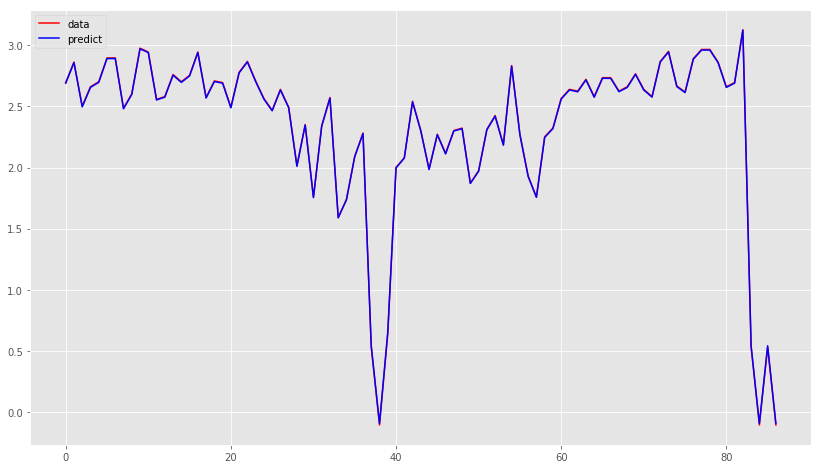

x_scale:  (2, 87, 3, 1)


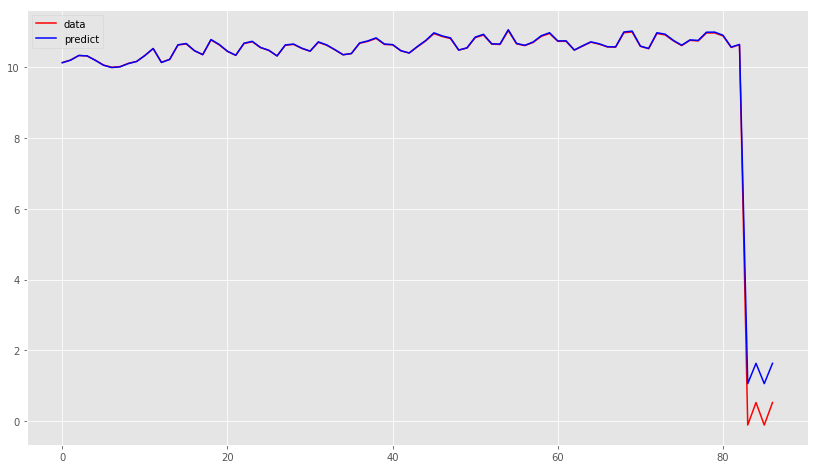

87/87 [==============================] - 0s 59us/step
model evaluate mse: [10.664285352860373, 0.02073228928720814, 10.643552867845557, 0.02073229031487443, 10.643553470743113]


In [20]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

In [21]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.007588071575755676
rmse: 0.1562979503172967
0.08194301094652619


## ヘテロジニアスモデルの事前学習

In [22]:
log_dir = 'model_hetero'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )
cc

del model
gc.collect()

model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )

with timer('train model individual'):
    model.fit(x, x, validation_split=0.1, epochs=1000, callbacks=[tensorboard, hetero_genious_callbacks])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 3, 120)       58560       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 3, 150)       91200       input_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (D

135/135 [==============================] - 0s 227us/step - loss: 0.1352 - dense_3_loss: 0.0164 - dense_4_loss: 0.1188 - dense_3_mean_squared_error: 0.0164 - dense_4_mean_squared_error: 0.1188 - val_loss: 0.1585 - val_dense_3_loss: 0.0163 - val_dense_4_loss: 0.1422 - val_dense_3_mean_squared_error: 0.0163 - val_dense_4_mean_squared_error: 0.1422
OrderedDict([('dense_3_loss', 0.01644328348338604), ('dense_3_mean_squared_error', 0.016443283828320325), ('dense_4_loss', 0.11879759811692768), ('dense_4_mean_squared_error', 0.11879759949666482), ('loss', 0.13524087772325233), ('val_dense_3_loss', 0.016290413215756416), ('val_dense_3_mean_squared_error', 0.016290411353111267), ('val_dense_4_loss', 0.14217151701450348), ('val_dense_4_mean_squared_error', 0.14217151701450348), ('val_loss', 0.15846192836761475)])
Epoch 10/1000
135/135 [==============================] - 0s 231us/step - loss: 0.1240 - dense_3_loss: 0.0157 - dense_4_loss: 0.1083 - dense_3_mean_squared_error: 0.0157 - dense_4_mean_sq

135/135 [==============================] - 0s 224us/step - loss: 0.0425 - dense_3_loss: 0.0094 - dense_4_loss: 0.0331 - dense_3_mean_squared_error: 0.0094 - dense_4_mean_squared_error: 0.0331 - val_loss: 0.0776 - val_dense_3_loss: 0.0127 - val_dense_4_loss: 0.0649 - val_dense_3_mean_squared_error: 0.0127 - val_dense_4_mean_squared_error: 0.0649
OrderedDict([('dense_3_loss', 0.009449931654941153), ('dense_3_mean_squared_error', 0.009449931606650353), ('dense_4_loss', 0.03308621239331033), ('dense_4_mean_squared_error', 0.03308621239331033), ('loss', 0.042536144096542286), ('val_dense_3_loss', 0.012673074379563332), ('val_dense_3_mean_squared_error', 0.012673073448240757), ('val_dense_4_loss', 0.06492223590612411), ('val_dense_4_mean_squared_error', 0.06492223590612411), ('val_loss', 0.0775953084230423)])
Epoch 20/1000
135/135 [==============================] - 0s 237us/step - loss: 0.0374 - dense_3_loss: 0.0088 - dense_4_loss: 0.0286 - dense_3_mean_squared_error: 0.0088 - dense_4_mean_s

135/135 [==============================] - 0s 231us/step - loss: 0.0114 - dense_3_loss: 0.0043 - dense_4_loss: 0.0071 - dense_3_mean_squared_error: 0.0043 - dense_4_mean_squared_error: 0.0071 - val_loss: 0.0506 - val_dense_3_loss: 0.0081 - val_dense_4_loss: 0.0425 - val_dense_3_mean_squared_error: 0.0081 - val_dense_4_mean_squared_error: 0.0425
OrderedDict([('dense_3_loss', 0.0042827118774531065), ('dense_3_mean_squared_error', 0.0042827116808405626), ('dense_4_loss', 0.0070725927853749855), ('dense_4_mean_squared_error', 0.007072592895753958), ('loss', 0.011355304552449121), ('val_dense_3_loss', 0.008108695968985558), ('val_dense_3_mean_squared_error', 0.008108696900308132), ('val_dense_4_loss', 0.042500901967287064), ('val_dense_4_mean_squared_error', 0.042500898241996765), ('val_loss', 0.05060959607362747)])
Epoch 30/1000
135/135 [==============================] - 0s 224us/step - loss: 0.0097 - dense_3_loss: 0.0040 - dense_4_loss: 0.0057 - dense_3_mean_squared_error: 0.0040 - dense_

135/135 [==============================] - 0s 233us/step - loss: 0.0036 - dense_3_loss: 0.0019 - dense_4_loss: 0.0017 - dense_3_mean_squared_error: 0.0019 - dense_4_mean_squared_error: 0.0017 - val_loss: 0.0424 - val_dense_3_loss: 0.0051 - val_dense_4_loss: 0.0373 - val_dense_3_mean_squared_error: 0.0051 - val_dense_4_mean_squared_error: 0.0373
OrderedDict([('dense_3_loss', 0.0019254209534092634), ('dense_3_mean_squared_error', 0.0019254210698245852), ('dense_4_loss', 0.0017090341524669418), ('dense_4_mean_squared_error', 0.001709034097277456), ('loss', 0.003634455099839855), ('val_dense_3_loss', 0.005115271080285311), ('val_dense_3_mean_squared_error', 0.005115271080285311), ('val_dense_4_loss', 0.03725612908601761), ('val_dense_4_mean_squared_error', 0.03725612908601761), ('val_loss', 0.04237139970064163)])
Epoch 40/1000
135/135 [==============================] - 0s 224us/step - loss: 0.0035 - dense_3_loss: 0.0018 - dense_4_loss: 0.0017 - dense_3_mean_squared_error: 0.0018 - dense_4_

135/135 [==============================] - 0s 223us/step - loss: 0.0026 - dense_3_loss: 9.6307e-04 - dense_4_loss: 0.0016 - dense_3_mean_squared_error: 9.6307e-04 - dense_4_mean_squared_error: 0.0016 - val_loss: 0.0388 - val_dense_3_loss: 0.0032 - val_dense_4_loss: 0.0356 - val_dense_3_mean_squared_error: 0.0032 - val_dense_4_mean_squared_error: 0.0356
OrderedDict([('dense_3_loss', 0.0009630661186141273), ('dense_3_mean_squared_error', 0.0009630661600062417), ('dense_4_loss', 0.001606417467162289), ('dense_4_mean_squared_error', 0.0016064173904144102), ('loss', 0.0025694835827582414), ('val_dense_3_loss', 0.0032164996955543756), ('val_dense_3_mean_squared_error', 0.0032164996955543756), ('val_dense_4_loss', 0.03559504821896553), ('val_dense_4_mean_squared_error', 0.03559504449367523), ('val_loss', 0.03881154954433441)])
Epoch 50/1000
135/135 [==============================] - 0s 200us/step - loss: 0.0025 - dense_3_loss: 9.0583e-04 - dense_4_loss: 0.0016 - dense_3_mean_squared_error: 9.

135/135 [==============================] - 0s 220us/step - loss: 0.0021 - dense_3_loss: 5.1759e-04 - dense_4_loss: 0.0016 - dense_3_mean_squared_error: 5.1759e-04 - dense_4_mean_squared_error: 0.0016 - val_loss: 0.0355 - val_dense_3_loss: 0.0018 - val_dense_4_loss: 0.0337 - val_dense_3_mean_squared_error: 0.0018 - val_dense_4_mean_squared_error: 0.0337
OrderedDict([('dense_3_loss', 0.0005175920065354418), ('dense_3_mean_squared_error', 0.000517591996618581), ('dense_4_loss', 0.0015568912279343716), ('dense_4_mean_squared_error', 0.0015568912770875074), ('loss', 0.0020744832267087917), ('val_dense_3_loss', 0.0017882433021441102), ('val_dense_3_mean_squared_error', 0.0017882431857287884), ('val_dense_4_loss', 0.033713094890117645), ('val_dense_4_mean_squared_error', 0.033713098615407944), ('val_loss', 0.03550133854150772)])
Epoch 60/1000
135/135 [==============================] - 0s 219us/step - loss: 0.0020 - dense_3_loss: 4.7971e-04 - dense_4_loss: 0.0015 - dense_3_mean_squared_error: 

135/135 [==============================] - 0s 234us/step - loss: 0.0017 - dense_3_loss: 2.3533e-04 - dense_4_loss: 0.0014 - dense_3_mean_squared_error: 2.3533e-04 - dense_4_mean_squared_error: 0.0014 - val_loss: 0.0327 - val_dense_3_loss: 7.3341e-04 - val_dense_4_loss: 0.0319 - val_dense_3_mean_squared_error: 7.3341e-04 - val_dense_4_mean_squared_error: 0.0319
OrderedDict([('dense_3_loss', 0.00023533312131702487), ('dense_3_mean_squared_error', 0.0002353331040703105), ('dense_4_loss', 0.0014272617650459762), ('dense_4_mean_squared_error', 0.001427261786604369), ('loss', 0.0016625948767695162), ('val_dense_3_loss', 0.0007334097172133625), ('val_dense_3_mean_squared_error', 0.0007334096590057015), ('val_dense_4_loss', 0.031925734132528305), ('val_dense_4_mean_squared_error', 0.031925734132528305), ('val_loss', 0.0326591432094574)])
Epoch 70/1000
135/135 [==============================] - 0s 230us/step - loss: 0.0016 - dense_3_loss: 2.1534e-04 - dense_4_loss: 0.0014 - dense_3_mean_squared

135/135 [==============================] - 0s 201us/step - loss: 0.0014 - dense_3_loss: 9.6949e-05 - dense_4_loss: 0.0013 - dense_3_mean_squared_error: 9.6949e-05 - dense_4_mean_squared_error: 0.0013 - val_loss: 0.0302 - val_dense_3_loss: 2.5008e-04 - val_dense_4_loss: 0.0300 - val_dense_3_mean_squared_error: 2.5008e-04 - val_dense_4_mean_squared_error: 0.0300
OrderedDict([('dense_3_loss', 9.694900940370711e-05), ('dense_3_mean_squared_error', 9.694900347514905e-05), ('dense_4_loss', 0.0013350784338803756), ('dense_4_mean_squared_error', 0.0013350784338803756), ('loss', 0.001432027478909327), ('val_dense_3_loss', 0.000250075216172263), ('val_dense_3_mean_squared_error', 0.000250075216172263), ('val_dense_4_loss', 0.02999483235180378), ('val_dense_4_mean_squared_error', 0.02999482862651348), ('val_loss', 0.03024490736424923)])
Epoch 80/1000
135/135 [==============================] - 0s 204us/step - loss: 0.0014 - dense_3_loss: 8.9605e-05 - dense_4_loss: 0.0013 - dense_3_mean_squared_err

OrderedDict([('dense_3_loss', 4.470441654794505e-05), ('dense_3_mean_squared_error', 4.470441463463767e-05), ('dense_4_loss', 0.0012766677049781989), ('dense_4_mean_squared_error', 0.001276667671347106), ('loss', 0.0013213721086719522), ('val_dense_3_loss', 9.99972180579789e-05), ('val_dense_3_mean_squared_error', 9.999720350606367e-05), ('val_dense_4_loss', 0.02822020649909973), ('val_dense_4_mean_squared_error', 0.02822020649909973), ('val_loss', 0.028320204466581345)])
Epoch 89/1000
135/135 [==============================] - 0s 221us/step - loss: 0.0013 - dense_3_loss: 4.1079e-05 - dense_4_loss: 0.0013 - dense_3_mean_squared_error: 4.1079e-05 - dense_4_mean_squared_error: 0.0013 - val_loss: 0.0282 - val_dense_3_loss: 9.2274e-05 - val_dense_4_loss: 0.0281 - val_dense_3_mean_squared_error: 9.2274e-05 - val_dense_4_mean_squared_error: 0.0281
OrderedDict([('dense_3_loss', 4.107858088294355e-05), ('dense_3_mean_squared_error', 4.107858069430761e-05), ('dense_4_loss', 0.001252368515081427

135/135 [==============================] - 0s 229us/step - loss: 0.0012 - dense_3_loss: 2.0300e-05 - dense_4_loss: 0.0012 - dense_3_mean_squared_error: 2.0300e-05 - dense_4_mean_squared_error: 0.0012 - val_loss: 0.0265 - val_dense_3_loss: 3.7490e-05 - val_dense_4_loss: 0.0264 - val_dense_3_mean_squared_error: 3.7490e-05 - val_dense_4_mean_squared_error: 0.0264
OrderedDict([('dense_3_loss', 2.0299859076018307e-05), ('dense_3_mean_squared_error', 2.0299859695822102e-05), ('dense_4_loss', 0.0011729605013021717), ('dense_4_mean_squared_error', 0.0011729605288969146), ('loss', 0.0011932603618199074), ('val_dense_3_loss', 3.749002280528657e-05), ('val_dense_3_mean_squared_error', 3.749002280528657e-05), ('val_dense_4_loss', 0.026419920846819878), ('val_dense_4_mean_squared_error', 0.026419920846819878), ('val_loss', 0.02645741030573845)])
Epoch 99/1000
135/135 [==============================] - 0s 221us/step - loss: 0.0012 - dense_3_loss: 1.8920e-05 - dense_4_loss: 0.0012 - dense_3_mean_squa

Epoch 108/1000
135/135 [==============================] - 0s 214us/step - loss: 0.0011 - dense_3_loss: 1.0764e-05 - dense_4_loss: 0.0011 - dense_3_mean_squared_error: 1.0764e-05 - dense_4_mean_squared_error: 0.0011 - val_loss: 0.0247 - val_dense_3_loss: 1.8457e-05 - val_dense_4_loss: 0.0247 - val_dense_3_mean_squared_error: 1.8457e-05 - val_dense_4_mean_squared_error: 0.0247
OrderedDict([('dense_3_loss', 1.076448505180586e-05), ('dense_3_mean_squared_error', 1.0764485098964845e-05), ('dense_4_loss', 0.0010883296477711864), ('dense_4_mean_squared_error', 0.0010883296538075364), ('loss', 0.0010990941155425928), ('val_dense_3_loss', 1.8457494661561213e-05), ('val_dense_3_mean_squared_error', 1.8457496480550617e-05), ('val_dense_4_loss', 0.02465972676873207), ('val_dense_4_mean_squared_error', 0.024659723043441772), ('val_loss', 0.0246781837195158)])
Epoch 109/1000
135/135 [==============================] - 0s 242us/step - loss: 0.0011 - dense_3_loss: 1.0210e-05 - dense_4_loss: 0.0011 - de

135/135 [==============================] - 0s 234us/step - loss: 0.0010 - dense_3_loss: 6.7401e-06 - dense_4_loss: 0.0010 - dense_3_mean_squared_error: 6.7401e-06 - dense_4_mean_squared_error: 0.0010 - val_loss: 0.0230 - val_dense_3_loss: 1.0755e-05 - val_dense_4_loss: 0.0230 - val_dense_3_mean_squared_error: 1.0755e-05 - val_dense_4_mean_squared_error: 0.0230
OrderedDict([('dense_3_loss', 6.740125489293995e-06), ('dense_3_mean_squared_error', 6.740125381502029e-06), ('dense_4_loss', 0.0010068803258171236), ('dense_4_mean_squared_error', 0.0010068803258171236), ('loss', 0.0010136204452633306), ('val_dense_3_loss', 1.075542331818724e-05), ('val_dense_3_mean_squared_error', 1.0755422408692539e-05), ('val_dense_4_loss', 0.0230324175208807), ('val_dense_4_mean_squared_error', 0.02303241565823555), ('val_loss', 0.02304317243397236)])
Epoch 119/1000
135/135 [==============================] - 0s 237us/step - loss: 0.0010 - dense_3_loss: 6.4888e-06 - dense_4_loss: 0.0010 - dense_3_mean_squared

135/135 [==============================] - 0s 229us/step - loss: 9.4882e-04 - dense_3_loss: 5.0236e-06 - dense_4_loss: 9.4380e-04 - dense_3_mean_squared_error: 5.0236e-06 - dense_4_mean_squared_error: 9.4380e-04 - val_loss: 0.0215 - val_dense_3_loss: 7.7252e-06 - val_dense_4_loss: 0.0215 - val_dense_3_mean_squared_error: 7.7252e-06 - val_dense_4_mean_squared_error: 0.0215
OrderedDict([('dense_3_loss', 5.02362841466998e-06), ('dense_3_mean_squared_error', 5.023628761625366e-06), ('dense_4_loss', 0.0009438003646209836), ('dense_4_mean_squared_error', 0.0009438003784183551), ('loss', 0.0009488239940428347), ('val_dense_3_loss', 7.725235263933428e-06), ('val_dense_3_mean_squared_error', 7.725234354438726e-06), ('val_dense_4_loss', 0.02153981663286686), ('val_dense_4_mean_squared_error', 0.02153981477022171), ('val_loss', 0.02154754102230072)])
Epoch 129/1000
135/135 [==============================] - 0s 222us/step - loss: 9.3667e-04 - dense_3_loss: 4.9069e-06 - dense_4_loss: 9.3176e-04 - d

OrderedDict([('dense_3_loss', 4.331105753442022e-06), ('dense_3_mean_squared_error', 4.331105861233987e-06), ('dense_4_loss', 0.0009032918390369525), ('dense_4_mean_squared_error', 0.0009032918528343241), ('loss', 0.0009076229313871375), ('val_dense_3_loss', 6.534748536068946e-06), ('val_dense_3_mean_squared_error', 6.534748536068946e-06), ('val_dense_4_loss', 0.020319543778896332), ('val_dense_4_mean_squared_error', 0.020319543778896332), ('val_loss', 0.020326077938079834)])
Epoch 138/1000
135/135 [==============================] - 0s 228us/step - loss: 8.8360e-04 - dense_3_loss: 4.3004e-06 - dense_4_loss: 8.7930e-04 - dense_3_mean_squared_error: 4.3004e-06 - dense_4_mean_squared_error: 8.7930e-04 - val_loss: 0.0202 - val_dense_3_loss: 6.4471e-06 - val_dense_4_loss: 0.0202 - val_dense_3_mean_squared_error: 6.4471e-06 - val_dense_4_mean_squared_error: 0.0202
OrderedDict([('dense_3_loss', 4.3003508869366705e-06), ('dense_3_mean_squared_error', 4.300350910516163e-06), ('dense_4_loss', 0.

135/135 [==============================] - 0s 224us/step - loss: 8.3264e-04 - dense_3_loss: 4.0018e-06 - dense_4_loss: 8.2864e-04 - dense_3_mean_squared_error: 4.0018e-06 - dense_4_mean_squared_error: 8.2864e-04 - val_loss: 0.0192 - val_dense_3_loss: 5.8765e-06 - val_dense_4_loss: 0.0191 - val_dense_3_mean_squared_error: 5.8765e-06 - val_dense_4_mean_squared_error: 0.0191
OrderedDict([('dense_3_loss', 4.001806977342952e-06), ('dense_3_mean_squared_error', 4.001807139030899e-06), ('dense_4_loss', 0.0008286369132326433), ('dense_4_mean_squared_error', 0.0008286369024534468), ('loss', 0.0008326387244138729), ('val_dense_3_loss', 5.876482646272052e-06), ('val_dense_3_mean_squared_error', 5.87648173677735e-06), ('val_dense_4_loss', 0.01914963684976101), ('val_dense_4_mean_squared_error', 0.01914963684976101), ('val_loss', 0.019155513495206833)])
Epoch 148/1000
135/135 [==============================] - 0s 234us/step - loss: 8.3204e-04 - dense_3_loss: 3.9490e-06 - dense_4_loss: 8.2809e-04 - 

OrderedDict([('dense_3_loss', 3.816484901040827e-06), ('dense_3_mean_squared_error', 3.8164847932488625e-06), ('dense_4_loss', 0.000777876745754232), ('dense_4_mean_squared_error', 0.0007778767625697785), ('loss', 0.0007816932327976381), ('val_dense_3_loss', 5.480464551510522e-06), ('val_dense_3_mean_squared_error', 5.480464551510522e-06), ('val_dense_4_loss', 0.018202519044280052), ('val_dense_4_mean_squared_error', 0.018202519044280052), ('val_loss', 0.01820799894630909)])
Epoch 157/1000
135/135 [==============================] - 0s 264us/step - loss: 7.7627e-04 - dense_3_loss: 3.7996e-06 - dense_4_loss: 7.7247e-04 - dense_3_mean_squared_error: 3.7996e-06 - dense_4_mean_squared_error: 7.7247e-04 - val_loss: 0.0181 - val_dense_3_loss: 5.3489e-06 - val_dense_4_loss: 0.0181 - val_dense_3_mean_squared_error: 5.3489e-06 - val_dense_4_mean_squared_error: 0.0181
OrderedDict([('dense_3_loss', 3.7996451064154154e-06), ('dense_3_mean_squared_error', 3.7996453219993447e-06), ('dense_4_loss', 0.

135/135 [==============================] - 0s 219us/step - loss: 7.3208e-04 - dense_3_loss: 3.7239e-06 - dense_4_loss: 7.2836e-04 - dense_3_mean_squared_error: 3.7239e-06 - dense_4_mean_squared_error: 7.2836e-04 - val_loss: 0.0173 - val_dense_3_loss: 5.2315e-06 - val_dense_4_loss: 0.0173 - val_dense_3_mean_squared_error: 5.2315e-06 - val_dense_4_mean_squared_error: 0.0173
OrderedDict([('dense_3_loss', 3.723872546120051e-06), ('dense_3_mean_squared_error', 3.723872492224069e-06), ('dense_4_loss', 0.0007283593571089485), ('dense_4_mean_squared_error', 0.0007283593571089485), ('loss', 0.0007320832297274912), ('val_dense_3_loss', 5.2314726417534985e-06), ('val_dense_3_mean_squared_error', 5.2314726417534985e-06), ('val_dense_4_loss', 0.017255181446671486), ('val_dense_4_mean_squared_error', 0.017255181446671486), ('val_loss', 0.017260413616895676)])
Epoch 167/1000
135/135 [==============================] - 0s 228us/step - loss: 7.2699e-04 - dense_3_loss: 3.6676e-06 - dense_4_loss: 7.2333e-

OrderedDict([('dense_3_loss', 3.552647501271201e-06), ('dense_3_mean_squared_error', 3.5526475787466753e-06), ('dense_4_loss', 0.0006839186888774512), ('dense_4_mean_squared_error', 0.0006839187194903691), ('loss', 0.0006874713227497758), ('val_dense_3_loss', 4.679606718127616e-06), ('val_dense_3_mean_squared_error', 4.679606718127616e-06), ('val_dense_4_loss', 0.016495514661073685), ('val_dense_4_mean_squared_error', 0.016495514661073685), ('val_loss', 0.016500193625688553)])
Epoch 176/1000
135/135 [==============================] - 0s 236us/step - loss: 6.8517e-04 - dense_3_loss: 3.5373e-06 - dense_4_loss: 6.8164e-04 - dense_3_mean_squared_error: 3.5373e-06 - dense_4_mean_squared_error: 6.8164e-04 - val_loss: 0.0165 - val_dense_3_loss: 4.8279e-06 - val_dense_4_loss: 0.0165 - val_dense_3_mean_squared_error: 4.8279e-06 - val_dense_4_mean_squared_error: 0.0165
OrderedDict([('dense_3_loss', 3.5373454752347983e-06), ('dense_3_mean_squared_error', 3.537345529130781e-06), ('dense_4_loss', 0

135/135 [==============================] - 0s 228us/step - loss: 6.4258e-04 - dense_3_loss: 3.4079e-06 - dense_4_loss: 6.3917e-04 - dense_3_mean_squared_error: 3.4079e-06 - dense_4_mean_squared_error: 6.3917e-04 - val_loss: 0.0158 - val_dense_3_loss: 4.9803e-06 - val_dense_4_loss: 0.0158 - val_dense_3_mean_squared_error: 4.9803e-06 - val_dense_4_mean_squared_error: 0.0158
OrderedDict([('dense_3_loss', 3.4079085859654394e-06), ('dense_3_mean_squared_error', 3.407908550596201e-06), ('dense_4_loss', 0.0006391696075701879), ('dense_4_mean_squared_error', 0.0006391696075701879), ('loss', 0.0006425775195195995), ('val_dense_3_loss', 4.98031840834301e-06), ('val_dense_3_mean_squared_error', 4.9803193178377114e-06), ('val_dense_4_loss', 0.015763521194458008), ('val_dense_4_mean_squared_error', 0.015763523057103157), ('val_loss', 0.01576850190758705)])
Epoch 186/1000
135/135 [==============================] - 0s 227us/step - loss: 6.4135e-04 - dense_3_loss: 3.4029e-06 - dense_4_loss: 6.3794e-04

OrderedDict([('dense_3_loss', 3.3016299076499072e-06), ('dense_3_mean_squared_error', 3.3016299194396534e-06), ('dense_4_loss', 0.0006028915397581402), ('dense_4_mean_squared_error', 0.0006028915121633973), ('loss', 0.0006061931662433953), ('val_dense_3_loss', 5.091921593702864e-06), ('val_dense_3_mean_squared_error', 5.091922503197566e-06), ('val_dense_4_loss', 0.015185060910880566), ('val_dense_4_mean_squared_error', 0.01518506184220314), ('val_loss', 0.015190152451395988)])
Epoch 195/1000
135/135 [==============================] - 0s 214us/step - loss: 6.0484e-04 - dense_3_loss: 3.3553e-06 - dense_4_loss: 6.0149e-04 - dense_3_mean_squared_error: 3.3553e-06 - dense_4_mean_squared_error: 6.0149e-04 - val_loss: 0.0151 - val_dense_3_loss: 4.8906e-06 - val_dense_4_loss: 0.0151 - val_dense_3_mean_squared_error: 4.8906e-06 - val_dense_4_mean_squared_error: 0.0151
OrderedDict([('dense_3_loss', 3.3553455245459596e-06), ('dense_3_mean_squared_error', 3.3553455245459596e-06), ('dense_4_loss', 

135/135 [==============================] - 0s 218us/step - loss: 5.6846e-04 - dense_3_loss: 3.1916e-06 - dense_4_loss: 5.6527e-04 - dense_3_mean_squared_error: 3.1916e-06 - dense_4_mean_squared_error: 5.6527e-04 - val_loss: 0.0145 - val_dense_3_loss: 4.6467e-06 - val_dense_4_loss: 0.0145 - val_dense_3_mean_squared_error: 4.6467e-06 - val_dense_4_mean_squared_error: 0.0145
OrderedDict([('dense_3_loss', 3.1916108178443714e-06), ('dense_3_mean_squared_error', 3.1916106620512976e-06), ('dense_4_loss', 0.0005652732237380136), ('dense_4_mean_squared_error', 0.0005652731961432706), ('loss', 0.0005684648420558208), ('val_dense_3_loss', 4.646723482437665e-06), ('val_dense_3_mean_squared_error', 4.646723482437665e-06), ('val_dense_4_loss', 0.01449228823184967), ('val_dense_4_mean_squared_error', 0.014492286369204521), ('val_loss', 0.014496934600174427)])
Epoch 205/1000
135/135 [==============================] - 0s 217us/step - loss: 5.6196e-04 - dense_3_loss: 3.1871e-06 - dense_4_loss: 5.5878e-0

OrderedDict([('dense_3_loss', 3.114266201009741e-06), ('dense_3_mean_squared_error', 3.1142661471137587e-06), ('dense_4_loss', 0.0005299127009628272), ('dense_4_mean_squared_error', 0.0005299127078615129), ('loss', 0.0005330269725096447), ('val_dense_3_loss', 4.599458407028578e-06), ('val_dense_3_mean_squared_error', 4.599457952281227e-06), ('val_dense_4_loss', 0.013940420933067799), ('val_dense_4_mean_squared_error', 0.013940420001745224), ('val_loss', 0.013945020735263824)])
Epoch 214/1000
135/135 [==============================] - 0s 213us/step - loss: 5.3611e-04 - dense_3_loss: 3.1254e-06 - dense_4_loss: 5.3298e-04 - dense_3_mean_squared_error: 3.1254e-06 - dense_4_mean_squared_error: 5.3298e-04 - val_loss: 0.0139 - val_dense_3_loss: 4.4099e-06 - val_dense_4_loss: 0.0139 - val_dense_3_mean_squared_error: 4.4099e-06 - val_dense_4_mean_squared_error: 0.0139
OrderedDict([('dense_3_loss', 3.125439890802092e-06), ('dense_3_mean_squared_error', 3.1254398369061095e-06), ('dense_4_loss', 0

135/135 [==============================] - 0s 225us/step - loss: 4.9666e-04 - dense_3_loss: 3.0159e-06 - dense_4_loss: 4.9365e-04 - dense_3_mean_squared_error: 3.0159e-06 - dense_4_mean_squared_error: 4.9365e-04 - val_loss: 0.0134 - val_dense_3_loss: 4.3845e-06 - val_dense_4_loss: 0.0134 - val_dense_3_mean_squared_error: 4.3845e-06 - val_dense_4_mean_squared_error: 0.0134
OrderedDict([('dense_3_loss', 3.0159331614683013e-06), ('dense_3_mean_squared_error', 3.0159332271540297e-06), ('dense_4_loss', 0.0004936471747458671), ('dense_4_mean_squared_error', 0.0004936471855250636), ('loss', 0.0004966630934547909), ('val_dense_3_loss', 4.384494786791038e-06), ('val_dense_3_mean_squared_error', 4.384494786791038e-06), ('val_dense_4_loss', 0.013363828882575035), ('val_dense_4_mean_squared_error', 0.013363831676542759), ('val_loss', 0.013368213549256325)])
Epoch 224/1000
135/135 [==============================] - 0s 254us/step - loss: 4.8970e-04 - dense_3_loss: 3.0055e-06 - dense_4_loss: 4.8669e-

OrderedDict([('dense_3_loss', 2.901182998121604e-06), ('dense_3_mean_squared_error', 2.9011828903296392e-06), ('dense_4_loss', 0.00045740323128282194), ('dense_4_mean_squared_error', 0.00045740324508019344), ('loss', 0.0004603044173024871), ('val_dense_3_loss', 4.03197918785736e-06), ('val_dense_3_mean_squared_error', 4.03197918785736e-06), ('val_dense_4_loss', 0.01289555337280035), ('val_dense_4_mean_squared_error', 0.01289555337280035), ('val_loss', 0.01289958506822586)])
Epoch 233/1000
135/135 [==============================] - 0s 224us/step - loss: 4.6702e-04 - dense_3_loss: 2.9363e-06 - dense_4_loss: 4.6408e-04 - dense_3_mean_squared_error: 2.9363e-06 - dense_4_mean_squared_error: 4.6408e-04 - val_loss: 0.0129 - val_dense_3_loss: 3.9689e-06 - val_dense_4_loss: 0.0129 - val_dense_3_mean_squared_error: 3.9689e-06 - val_dense_4_mean_squared_error: 0.0129
OrderedDict([('dense_3_loss', 2.9363039528915476e-06), ('dense_3_mean_squared_error', 2.9363039646812937e-06), ('dense_4_loss', 0.0

135/135 [==============================] - 0s 225us/step - loss: 4.3330e-04 - dense_3_loss: 2.8564e-06 - dense_4_loss: 4.3044e-04 - dense_3_mean_squared_error: 2.8564e-06 - dense_4_mean_squared_error: 4.3044e-04 - val_loss: 0.0123 - val_dense_3_loss: 4.1206e-06 - val_dense_4_loss: 0.0123 - val_dense_3_mean_squared_error: 4.1206e-06 - val_dense_4_mean_squared_error: 0.0123
OrderedDict([('dense_3_loss', 2.8563570140249794e-06), ('dense_3_mean_squared_error', 2.8563570140249794e-06), ('dense_4_loss', 0.00043044468879492744), ('dense_4_mean_squared_error', 0.0004304446734884685), ('loss', 0.00043330104219623737), ('val_dense_3_loss', 4.1206094465451315e-06), ('val_dense_3_mean_squared_error', 4.1206094465451315e-06), ('val_dense_4_loss', 0.012338328175246716), ('val_dense_4_mean_squared_error', 0.012338328175246716), ('val_loss', 0.012342448346316814)])
Epoch 243/1000
135/135 [==============================] - 0s 232us/step - loss: 4.2119e-04 - dense_3_loss: 2.8261e-06 - dense_4_loss: 4.18

OrderedDict([('dense_3_loss', 2.718359206078781e-06), ('dense_3_mean_squared_error', 2.7183592119736543e-06), ('dense_4_loss', 0.0003953019605466613), ('dense_4_mean_squared_error', 0.0003953019842608935), ('loss', 0.0003980203111293829), ('val_dense_3_loss', 3.9321193980867974e-06), ('val_dense_3_mean_squared_error', 3.9321189433394466e-06), ('val_dense_4_loss', 0.011865353211760521), ('val_dense_4_mean_squared_error', 0.011865353211760521), ('val_loss', 0.011869285255670547)])
Epoch 252/1000
135/135 [==============================] - 0s 219us/step - loss: 3.9147e-04 - dense_3_loss: 2.7159e-06 - dense_4_loss: 3.8875e-04 - dense_3_mean_squared_error: 2.7159e-06 - dense_4_mean_squared_error: 3.8875e-04 - val_loss: 0.0118 - val_dense_3_loss: 3.9215e-06 - val_dense_4_loss: 0.0118 - val_dense_3_mean_squared_error: 3.9215e-06 - val_dense_4_mean_squared_error: 0.0118
OrderedDict([('dense_3_loss', 2.7158878546523974e-06), ('dense_3_mean_squared_error', 2.715887986023854e-06), ('dense_4_loss',

Epoch 261/1000
135/135 [==============================] - 0s 222us/step - loss: 3.6503e-04 - dense_3_loss: 2.6401e-06 - dense_4_loss: 3.6239e-04 - dense_3_mean_squared_error: 2.6401e-06 - dense_4_mean_squared_error: 3.6239e-04 - val_loss: 0.0113 - val_dense_3_loss: 3.6916e-06 - val_dense_4_loss: 0.0113 - val_dense_3_mean_squared_error: 3.6916e-06 - val_dense_4_mean_squared_error: 0.0113
OrderedDict([('dense_3_loss', 2.640099649363913e-06), ('dense_3_mean_squared_error', 2.6400997150496415e-06), ('dense_4_loss', 0.00036238502771421163), ('dense_4_mean_squared_error', 0.00036238504991935636), ('loss', 0.00036502513038511904), ('val_dense_3_loss', 3.6916071621817537e-06), ('val_dense_3_mean_squared_error', 3.691607389555429e-06), ('val_dense_4_loss', 0.011310714296996593), ('val_dense_4_mean_squared_error', 0.011310715228319168), ('val_loss', 0.01131440605968237)])
Epoch 262/1000
135/135 [==============================] - 0s 237us/step - loss: 3.6050e-04 - dense_3_loss: 2.6212e-06 - dense

OrderedDict([('dense_3_loss', 2.549578390345333e-06), ('dense_3_mean_squared_error', 2.549578390345333e-06), ('dense_4_loss', 0.00033931908934998014), ('dense_4_mean_squared_error', 0.00033931909085906765), ('loss', 0.000341868661214701), ('val_dense_3_loss', 3.8864022826601285e-06), ('val_dense_3_mean_squared_error', 3.886401827912778e-06), ('val_dense_4_loss', 0.010829102247953415), ('val_dense_4_mean_squared_error', 0.01082910131663084), ('val_loss', 0.010832988657057285)])
Epoch 271/1000
135/135 [==============================] - 0s 258us/step - loss: 3.3657e-04 - dense_3_loss: 2.5646e-06 - dense_4_loss: 3.3401e-04 - dense_3_mean_squared_error: 2.5646e-06 - dense_4_mean_squared_error: 3.3401e-04 - val_loss: 0.0108 - val_dense_3_loss: 3.9154e-06 - val_dense_4_loss: 0.0108 - val_dense_3_mean_squared_error: 3.9154e-06 - val_dense_4_mean_squared_error: 0.0108
OrderedDict([('dense_3_loss', 2.5645965504534413e-06), ('dense_3_mean_squared_error', 2.564596496557459e-06), ('dense_4_loss', 0

135/135 [==============================] - 0s 247us/step - loss: 3.1166e-04 - dense_3_loss: 2.4679e-06 - dense_4_loss: 3.0919e-04 - dense_3_mean_squared_error: 2.4679e-06 - dense_4_mean_squared_error: 3.0919e-04 - val_loss: 0.0103 - val_dense_3_loss: 3.7110e-06 - val_dense_4_loss: 0.0103 - val_dense_3_mean_squared_error: 3.7110e-06 - val_dense_4_mean_squared_error: 0.0103
OrderedDict([('dense_3_loss', 2.4678835264542916e-06), ('dense_3_mean_squared_error', 2.4678834456103183e-06), ('dense_4_loss', 0.00030919377351421175), ('dense_4_mean_squared_error', 0.00030919377351421175), ('loss', 0.0003116616567476066), ('val_dense_3_loss', 3.710950750246411e-06), ('val_dense_3_mean_squared_error', 3.710951204993762e-06), ('val_dense_4_loss', 0.010344015434384346), ('val_dense_4_mean_squared_error', 0.010344015434384346), ('val_loss', 0.010347726754844189)])
Epoch 281/1000
135/135 [==============================] - 0s 240us/step - loss: 3.0902e-04 - dense_3_loss: 2.4674e-06 - dense_4_loss: 3.0656

OrderedDict([('dense_3_loss', 2.449039911206691e-06), ('dense_3_mean_squared_error', 2.449039911206691e-06), ('dense_4_loss', 0.00028685384453705476), ('dense_4_mean_squared_error', 0.00028685385833442627), ('loss', 0.00028930288541165216), ('val_dense_3_loss', 3.6599324175767833e-06), ('val_dense_3_mean_squared_error', 3.6599324175767833e-06), ('val_dense_4_loss', 0.009810001589357853), ('val_dense_4_mean_squared_error', 0.009810002520680428), ('val_loss', 0.009813661687076092)])
Epoch 290/1000
135/135 [==============================] - 0s 264us/step - loss: 2.8960e-04 - dense_3_loss: 2.4215e-06 - dense_4_loss: 2.8718e-04 - dense_3_mean_squared_error: 2.4215e-06 - dense_4_mean_squared_error: 2.8718e-04 - val_loss: 0.0098 - val_dense_3_loss: 3.5643e-06 - val_dense_4_loss: 0.0098 - val_dense_3_mean_squared_error: 3.5643e-06 - val_dense_4_mean_squared_error: 0.0098
OrderedDict([('dense_3_loss', 2.421490968892478e-06), ('dense_3_mean_squared_error', 2.4214909149964956e-06), ('dense_4_loss

135/135 [==============================] - 0s 257us/step - loss: 2.6872e-04 - dense_3_loss: 2.3484e-06 - dense_4_loss: 2.6637e-04 - dense_3_mean_squared_error: 2.3484e-06 - dense_4_mean_squared_error: 2.6637e-04 - val_loss: 0.0093 - val_dense_3_loss: 3.3397e-06 - val_dense_4_loss: 0.0093 - val_dense_3_mean_squared_error: 3.3397e-06 - val_dense_4_mean_squared_error: 0.0093
OrderedDict([('dense_3_loss', 2.348391837956485e-06), ('dense_3_mean_squared_error', 2.3483918678519128e-06), ('dense_4_loss', 0.00026637100521906243), ('dense_4_mean_squared_error', 0.00026637100521906243), ('loss', 0.0002687193959934154), ('val_dense_3_loss', 3.339704790050746e-06), ('val_dense_3_mean_squared_error', 3.3397045626770705e-06), ('val_dense_4_loss', 0.009344697929918766), ('val_dense_4_mean_squared_error', 0.009344697929918766), ('val_loss', 0.009348037652671337)])
Epoch 300/1000
135/135 [==============================] - 0s 234us/step - loss: 2.6543e-04 - dense_3_loss: 2.3026e-06 - dense_4_loss: 2.6313

OrderedDict([('dense_3_loss', 2.2498297859648895e-06), ('dense_3_mean_squared_error', 2.249829726174034e-06), ('dense_4_loss', 0.00024362468954037736), ('dense_4_mean_squared_error', 0.00024362470333774884), ('loss', 0.00024587452364223145), ('val_dense_3_loss', 3.3066767173295375e-06), ('val_dense_3_mean_squared_error', 3.306676944703213e-06), ('val_dense_4_loss', 0.008870529942214489), ('val_dense_4_mean_squared_error', 0.008870529010891914), ('val_loss', 0.008873837068676949)])
Epoch 309/1000
135/135 [==============================] - 0s 228us/step - loss: 2.4400e-04 - dense_3_loss: 2.2526e-06 - dense_4_loss: 2.4175e-04 - dense_3_mean_squared_error: 2.2526e-06 - dense_4_mean_squared_error: 2.4175e-04 - val_loss: 0.0089 - val_dense_3_loss: 3.4738e-06 - val_dense_4_loss: 0.0089 - val_dense_3_mean_squared_error: 3.4738e-06 - val_dense_4_mean_squared_error: 0.0089
OrderedDict([('dense_3_loss', 2.2526139564096985e-06), ('dense_3_mean_squared_error', 2.2526139833576896e-06), ('dense_4_los

135/135 [==============================] - 0s 233us/step - loss: 2.2709e-04 - dense_3_loss: 2.1570e-06 - dense_4_loss: 2.2493e-04 - dense_3_mean_squared_error: 2.1570e-06 - dense_4_mean_squared_error: 2.2493e-04 - val_loss: 0.0084 - val_dense_3_loss: 3.2074e-06 - val_dense_4_loss: 0.0084 - val_dense_3_mean_squared_error: 3.2074e-06 - val_dense_4_mean_squared_error: 0.0084
OrderedDict([('dense_3_loss', 2.157012697891871e-06), ('dense_3_mean_squared_error', 2.1570125749416613e-06), ('dense_4_loss', 0.00022493463874087428), ('dense_4_mean_squared_error', 0.00022493464369930465), ('loss', 0.00022709165695468308), ('val_dense_3_loss', 3.207409235983505e-06), ('val_dense_3_mean_squared_error', 3.2074090086098295e-06), ('val_dense_4_loss', 0.008416526950895786), ('val_dense_4_mean_squared_error', 0.008416526019573212), ('val_loss', 0.008419734425842762)])
Epoch 319/1000
135/135 [==============================] - 0s 230us/step - loss: 2.2532e-04 - dense_3_loss: 2.1742e-06 - dense_4_loss: 2.231

OrderedDict([('dense_3_loss', 2.2113456932654825e-06), ('dense_3_mean_squared_error', 2.211345801057447e-06), ('dense_4_loss', 0.00020663944834032683), ('dense_4_mean_squared_error', 0.00020663944984941434), ('loss', 0.00020885079381211352), ('val_dense_3_loss', 3.2857683436304796e-06), ('val_dense_3_mean_squared_error', 3.285768116256804e-06), ('val_dense_4_loss', 0.007992918603122234), ('val_dense_4_mean_squared_error', 0.007992919534444809), ('val_loss', 0.007996204309165478)])
Epoch 328/1000
135/135 [==============================] - 0s 224us/step - loss: 2.0792e-04 - dense_3_loss: 2.1082e-06 - dense_4_loss: 2.0581e-04 - dense_3_mean_squared_error: 2.1082e-06 - dense_4_mean_squared_error: 2.0581e-04 - val_loss: 0.0080 - val_dense_3_loss: 3.2907e-06 - val_dense_4_loss: 0.0080 - val_dense_3_mean_squared_error: 3.2907e-06 - val_dense_4_mean_squared_error: 0.0080
OrderedDict([('dense_3_loss', 2.1081694571707716e-06), ('dense_3_mean_squared_error', 2.10816947822389e-06), ('dense_4_loss'

135/135 [==============================] - 0s 231us/step - loss: 1.8725e-04 - dense_3_loss: 2.0520e-06 - dense_4_loss: 1.8519e-04 - dense_3_mean_squared_error: 2.0520e-06 - dense_4_mean_squared_error: 1.8519e-04 - val_loss: 0.0076 - val_dense_3_loss: 2.9975e-06 - val_dense_4_loss: 0.0076 - val_dense_3_mean_squared_error: 2.9975e-06 - val_dense_4_mean_squared_error: 0.0076
OrderedDict([('dense_3_loss', 2.0519866186279817e-06), ('dense_3_mean_squared_error', 2.051986666629091e-06), ('dense_4_loss', 0.0001851949730836269), ('dense_4_mean_squared_error', 0.00018519496198105454), ('loss', 0.00018724696074733167), ('val_dense_3_loss', 2.9975412871863227e-06), ('val_dense_3_mean_squared_error', 2.997540832438972e-06), ('val_dense_4_loss', 0.00761057436466217), ('val_dense_4_mean_squared_error', 0.007610573899000883), ('val_loss', 0.00761357182636857)])
Epoch 338/1000
135/135 [==============================] - 0s 250us/step - loss: 1.8768e-04 - dense_3_loss: 2.0279e-06 - dense_4_loss: 1.8565e-

OrderedDict([('dense_3_loss', 1.967150809731619e-06), ('dense_3_mean_squared_error', 1.967150782783628e-06), ('dense_4_loss', 0.0001733599828892491), ('dense_4_mean_squared_error', 0.0001733599813801616), ('loss', 0.00017532713353392426), ('val_dense_3_loss', 2.9754655770375393e-06), ('val_dense_3_mean_squared_error', 2.9754655770375393e-06), ('val_dense_4_loss', 0.007249459158629179), ('val_dense_4_mean_squared_error', 0.007249458692967892), ('val_loss', 0.0072524347342550755)])
Epoch 347/1000
135/135 [==============================] - 0s 226us/step - loss: 1.7478e-04 - dense_3_loss: 1.9660e-06 - dense_4_loss: 1.7281e-04 - dense_3_mean_squared_error: 1.9660e-06 - dense_4_mean_squared_error: 1.7281e-04 - val_loss: 0.0072 - val_dense_3_loss: 2.9442e-06 - val_dense_4_loss: 0.0072 - val_dense_3_mean_squared_error: 2.9442e-06 - val_dense_4_mean_squared_error: 0.0072
OrderedDict([('dense_3_loss', 1.9659788567541573e-06), ('dense_3_mean_squared_error', 1.9659788837021484e-06), ('dense_4_loss

OrderedDict([('dense_3_loss', 2.003278307340763e-06), ('dense_3_mean_squared_error', 2.0032783460785004e-06), ('dense_4_loss', 0.0001604203441982261), ('dense_4_mean_squared_error', 0.00016042035034236808), ('loss', 0.00016242362520036598), ('val_dense_3_loss', 2.8275676413613837e-06), ('val_dense_3_mean_squared_error', 2.8275674139877083e-06), ('val_dense_4_loss', 0.006921972148120403), ('val_dense_4_mean_squared_error', 0.006921972148120403), ('val_loss', 0.006924799643456936)])
Epoch 356/1000
135/135 [==============================] - 0s 229us/step - loss: 1.6185e-04 - dense_3_loss: 1.9651e-06 - dense_4_loss: 1.5988e-04 - dense_3_mean_squared_error: 1.9651e-06 - dense_4_mean_squared_error: 1.5988e-04 - val_loss: 0.0068 - val_dense_3_loss: 2.9408e-06 - val_dense_4_loss: 0.0068 - val_dense_3_mean_squared_error: 2.9408e-06 - val_dense_4_mean_squared_error: 0.0068
OrderedDict([('dense_3_loss', 1.9650772418134256e-06), ('dense_3_mean_squared_error', 1.9650772418134256e-06), ('dense_4_los

135/135 [==============================] - 0s 223us/step - loss: 1.4876e-04 - dense_3_loss: 1.8241e-06 - dense_4_loss: 1.4694e-04 - dense_3_mean_squared_error: 1.8241e-06 - dense_4_mean_squared_error: 1.4694e-04 - val_loss: 0.0065 - val_dense_3_loss: 2.7966e-06 - val_dense_4_loss: 0.0065 - val_dense_3_mean_squared_error: 2.7966e-06 - val_dense_4_mean_squared_error: 0.0065
OrderedDict([('dense_3_loss', 1.8241486823508576e-06), ('dense_3_mean_squared_error', 1.8241486554028665e-06), ('dense_4_loss', 0.00014693770305408785), ('dense_4_mean_squared_error', 0.000146937702676816), ('loss', 0.00014876184900963887), ('val_dense_3_loss', 2.7965761546511203e-06), ('val_dense_3_mean_squared_error', 2.7965763820247957e-06), ('val_dense_4_loss', 0.006532595027238131), ('val_dense_4_mean_squared_error', 0.006532595027238131), ('val_loss', 0.006535391788929701)])
Epoch 366/1000
135/135 [==============================] - 0s 228us/step - loss: 1.4387e-04 - dense_3_loss: 1.8469e-06 - dense_4_loss: 1.420

OrderedDict([('dense_3_loss', 1.8002603189449508e-06), ('dense_3_mean_squared_error', 1.8002602919969595e-06), ('dense_4_loss', 0.00013600164243985933), ('dense_4_mean_squared_error', 0.00013600163899051647), ('loss', 0.00013780190320513037), ('val_dense_3_loss', 2.727639412114513e-06), ('val_dense_3_mean_squared_error', 2.727639412114513e-06), ('val_dense_4_loss', 0.006235152017325163), ('val_dense_4_mean_squared_error', 0.00623515248298645), ('val_loss', 0.006237879861146212)])
Epoch 375/1000
135/135 [==============================] - 0s 229us/step - loss: 1.3630e-04 - dense_3_loss: 1.8046e-06 - dense_4_loss: 1.3450e-04 - dense_3_mean_squared_error: 1.8046e-06 - dense_4_mean_squared_error: 1.3450e-04 - val_loss: 0.0062 - val_dense_3_loss: 2.6314e-06 - val_dense_4_loss: 0.0062 - val_dense_3_mean_squared_error: 2.6314e-06 - val_dense_4_mean_squared_error: 0.0062
OrderedDict([('dense_3_loss', 1.8045784414695204e-06), ('dense_3_mean_squared_error', 1.804578360625547e-06), ('dense_4_loss'

135/135 [==============================] - 0s 210us/step - loss: 1.2346e-04 - dense_3_loss: 1.7182e-06 - dense_4_loss: 1.2174e-04 - dense_3_mean_squared_error: 1.7182e-06 - dense_4_mean_squared_error: 1.2174e-04 - val_loss: 0.0059 - val_dense_3_loss: 2.5821e-06 - val_dense_4_loss: 0.0059 - val_dense_3_mean_squared_error: 2.5821e-06 - val_dense_4_mean_squared_error: 0.0059
OrderedDict([('dense_3_loss', 1.7181661759322094e-06), ('dense_3_mean_squared_error', 1.7181661910904546e-06), ('dense_4_loss', 0.00012174077058228216), ('dense_4_mean_squared_error', 0.0001217407609887973), ('loss', 0.00012345893644831246), ('val_dense_3_loss', 2.5821407234616345e-06), ('val_dense_3_mean_squared_error', 2.5821407234616345e-06), ('val_dense_4_loss', 0.005909279454499483), ('val_dense_4_mean_squared_error', 0.005909279454499483), ('val_loss', 0.0059118615463376045)])
Epoch 385/1000
135/135 [==============================] - 0s 196us/step - loss: 1.2060e-04 - dense_3_loss: 1.7700e-06 - dense_4_loss: 1.1

OrderedDict([('dense_3_loss', 1.7084834982799496e-06), ('dense_3_mean_squared_error', 1.7084835521759318e-06), ('dense_4_loss', 0.00011265710561053345), ('dense_4_mean_squared_error', 0.00011265710291573433), ('loss', 0.00011436558658412347), ('val_dense_3_loss', 2.4279686385852983e-06), ('val_dense_3_mean_squared_error', 2.4279688659589738e-06), ('val_dense_4_loss', 0.005626971833407879), ('val_dense_4_mean_squared_error', 0.005626972299069166), ('val_loss', 0.005629399791359901)])
Epoch 394/1000
135/135 [==============================] - 0s 208us/step - loss: 1.1776e-04 - dense_3_loss: 1.6941e-06 - dense_4_loss: 1.1607e-04 - dense_3_mean_squared_error: 1.6941e-06 - dense_4_mean_squared_error: 1.1607e-04 - val_loss: 0.0056 - val_dense_3_loss: 2.4520e-06 - val_dense_4_loss: 0.0056 - val_dense_3_mean_squared_error: 2.4520e-06 - val_dense_4_mean_squared_error: 0.0056
OrderedDict([('dense_3_loss', 1.6941224101982597e-06), ('dense_3_mean_squared_error', 1.6941223141960412e-06), ('dense_4_l

135/135 [==============================] - 0s 233us/step - loss: 1.0402e-04 - dense_3_loss: 1.6361e-06 - dense_4_loss: 1.0238e-04 - dense_3_mean_squared_error: 1.6361e-06 - dense_4_mean_squared_error: 1.0238e-04 - val_loss: 0.0054 - val_dense_3_loss: 2.3855e-06 - val_dense_4_loss: 0.0054 - val_dense_3_mean_squared_error: 2.3855e-06 - val_dense_4_mean_squared_error: 0.0054
OrderedDict([('dense_3_loss', 1.6360893920574637e-06), ('dense_3_mean_squared_error', 1.636089362162036e-06), ('dense_4_loss', 0.00010237981666621096), ('dense_4_mean_squared_error', 0.0001023798183908824), ('loss', 0.0001040159057420506), ('val_dense_3_loss', 2.3855450308474246e-06), ('val_dense_3_mean_squared_error', 2.3855450308474246e-06), ('val_dense_4_loss', 0.005361749324947596), ('val_dense_4_mean_squared_error', 0.005361748859286308), ('val_loss', 0.005364134907722473)])
Epoch 404/1000
135/135 [==============================] - 0s 230us/step - loss: 1.0070e-04 - dense_3_loss: 1.5981e-06 - dense_4_loss: 9.9099

OrderedDict([('dense_3_loss', 1.624897106045898e-06), ('dense_3_mean_squared_error', 1.624897106045898e-06), ('dense_4_loss', 9.380509549777748e-05), ('dense_4_mean_squared_error', 9.38050930185623e-05), ('loss', 9.542999404301452e-05), ('val_dense_3_loss', 2.303217570442939e-06), ('val_dense_3_mean_squared_error', 2.303217570442939e-06), ('val_dense_4_loss', 0.0051162363961339), ('val_dense_4_mean_squared_error', 0.0051162363961339), ('val_loss', 0.005118539556860924)])
Epoch 413/1000
135/135 [==============================] - 0s 220us/step - loss: 9.2946e-05 - dense_3_loss: 1.5404e-06 - dense_4_loss: 9.1406e-05 - dense_3_mean_squared_error: 1.5404e-06 - dense_4_mean_squared_error: 9.1406e-05 - val_loss: 0.0051 - val_dense_3_loss: 2.4067e-06 - val_dense_4_loss: 0.0051 - val_dense_3_mean_squared_error: 2.4067e-06 - val_dense_4_mean_squared_error: 0.0051
OrderedDict([('dense_3_loss', 1.5404446794828228e-06), ('dense_3_mean_squared_error', 1.5404446525348315e-06), ('dense_4_loss', 9.1405

135/135 [==============================] - 0s 227us/step - loss: 8.6539e-05 - dense_3_loss: 1.5846e-06 - dense_4_loss: 8.4954e-05 - dense_3_mean_squared_error: 1.5846e-06 - dense_4_mean_squared_error: 8.4954e-05 - val_loss: 0.0049 - val_dense_3_loss: 2.4675e-06 - val_dense_4_loss: 0.0049 - val_dense_3_mean_squared_error: 2.4675e-06 - val_dense_4_mean_squared_error: 0.0049
OrderedDict([('dense_3_loss', 1.584621435102707e-06), ('dense_3_mean_squared_error', 1.5846214679455711e-06), ('dense_4_loss', 8.495435915257851e-05), ('dense_4_mean_squared_error', 8.495435780517895e-05), ('loss', 8.653898079905453e-05), ('val_dense_3_loss', 2.467542117301491e-06), ('val_dense_3_mean_squared_error', 2.467542117301491e-06), ('val_dense_4_loss', 0.004878446459770203), ('val_dense_4_mean_squared_error', 0.004878445994108915), ('val_loss', 0.004880913998931646)])
Epoch 423/1000
135/135 [==============================] - 0s 241us/step - loss: 8.4564e-05 - dense_3_loss: 1.5675e-06 - dense_4_loss: 8.2996e-0

OrderedDict([('dense_3_loss', 1.4842690571067916e-06), ('dense_3_mean_squared_error', 1.4842690301588003e-06), ('dense_4_loss', 7.800351347584553e-05), ('dense_4_mean_squared_error', 7.800351520051696e-05), ('loss', 7.948778403698709e-05), ('val_dense_3_loss', 2.300617097716895e-06), ('val_dense_3_mean_squared_error', 2.3006173250905704e-06), ('val_dense_4_loss', 0.00469921575859189), ('val_dense_4_mean_squared_error', 0.00469921575859189), ('val_loss', 0.004701516591012478)])
Epoch 432/1000
135/135 [==============================] - 0s 236us/step - loss: 8.0346e-05 - dense_3_loss: 1.4845e-06 - dense_4_loss: 7.8862e-05 - dense_3_mean_squared_error: 1.4845e-06 - dense_4_mean_squared_error: 7.8862e-05 - val_loss: 0.0047 - val_dense_3_loss: 2.2628e-06 - val_dense_4_loss: 0.0047 - val_dense_3_mean_squared_error: 2.2628e-06 - val_dense_4_mean_squared_error: 0.0047
OrderedDict([('dense_3_loss', 1.4844780547786354e-06), ('dense_3_mean_squared_error', 1.4844780488837623e-06), ('dense_4_loss', 

135/135 [==============================] - 0s 203us/step - loss: 7.1244e-05 - dense_3_loss: 1.4059e-06 - dense_4_loss: 6.9838e-05 - dense_3_mean_squared_error: 1.4059e-06 - dense_4_mean_squared_error: 6.9838e-05 - val_loss: 0.0045 - val_dense_3_loss: 2.2469e-06 - val_dense_4_loss: 0.0045 - val_dense_3_mean_squared_error: 2.2469e-06 - val_dense_4_mean_squared_error: 0.0045
OrderedDict([('dense_3_loss', 1.4058900685793357e-06), ('dense_3_mean_squared_error', 1.4058900146833535e-06), ('dense_4_loss', 6.983837288485288e-05), ('dense_4_mean_squared_error', 6.983837671146762e-05), ('loss', 7.124426397408738e-05), ('val_dense_3_loss', 2.2468889255833346e-06), ('val_dense_3_mean_squared_error', 2.2468893803306855e-06), ('val_dense_4_loss', 0.004467309452593327), ('val_dense_4_mean_squared_error', 0.004467308986932039), ('val_loss', 0.004469556268304586)])
Epoch 442/1000
135/135 [==============================] - 0s 205us/step - loss: 7.1426e-05 - dense_3_loss: 1.4269e-06 - dense_4_loss: 6.9999

OrderedDict([('dense_3_loss', 1.432943611234805e-06), ('dense_3_mean_squared_error', 1.432943611234805e-06), ('dense_4_loss', 6.433123549127399e-05), ('dense_4_mean_squared_error', 6.433123462893827e-05), ('loss', 6.576418053117339e-05), ('val_dense_3_loss', 2.2989131593931234e-06), ('val_dense_3_mean_squared_error', 2.298913386766799e-06), ('val_dense_4_loss', 0.004281245172023773), ('val_dense_4_mean_squared_error', 0.004281245172023773), ('val_loss', 0.0042835441417992115)])
Epoch 451/1000
135/135 [==============================] - 0s 330us/step - loss: 6.5581e-05 - dense_3_loss: 1.4072e-06 - dense_4_loss: 6.4173e-05 - dense_3_mean_squared_error: 1.4072e-06 - dense_4_mean_squared_error: 6.4173e-05 - val_loss: 0.0043 - val_dense_3_loss: 2.1777e-06 - val_dense_4_loss: 0.0043 - val_dense_3_mean_squared_error: 2.1777e-06 - val_dense_4_mean_squared_error: 0.0043
OrderedDict([('dense_3_loss', 1.4072024626969964e-06), ('dense_3_mean_squared_error', 1.407202408801014e-06), ('dense_4_loss', 

135/135 [==============================] - 0s 286us/step - loss: 5.9899e-05 - dense_3_loss: 1.3911e-06 - dense_4_loss: 5.8507e-05 - dense_3_mean_squared_error: 1.3911e-06 - dense_4_mean_squared_error: 5.8507e-05 - val_loss: 0.0041 - val_dense_3_loss: 2.1497e-06 - val_dense_4_loss: 0.0041 - val_dense_3_mean_squared_error: 2.1497e-06 - val_dense_4_mean_squared_error: 0.0041
OrderedDict([('dense_3_loss', 1.391053957309783e-06), ('dense_3_mean_squared_error', 1.3910540381537564e-06), ('dense_4_loss', 5.850745133270889e-05), ('dense_4_mean_squared_error', 5.850745515932364e-05), ('loss', 5.989850539696851e-05), ('val_dense_3_loss', 2.1496680346899666e-06), ('val_dense_3_mean_squared_error', 2.1496680346899666e-06), ('val_dense_4_loss', 0.0040970249101519585), ('val_dense_4_mean_squared_error', 0.004097024444490671), ('val_loss', 0.004099174402654171)])
Epoch 461/1000
135/135 [==============================] - 0s 279us/step - loss: 5.9306e-05 - dense_3_loss: 1.3705e-06 - dense_4_loss: 5.7935

OrderedDict([('dense_3_loss', 1.2860417688932136e-06), ('dense_3_mean_squared_error', 1.2860418615269332e-06), ('dense_4_loss', 5.239942569190774e-05), ('dense_4_mean_squared_error', 5.239942396723631e-05), ('loss', 5.36854678540732e-05), ('val_dense_3_loss', 1.92005018107011e-06), ('val_dense_3_mean_squared_error', 1.92005018107011e-06), ('val_dense_4_loss', 0.0039218212477862835), ('val_dense_4_mean_squared_error', 0.0039218212477862835), ('val_loss', 0.003923741169273853)])
Epoch 470/1000
135/135 [==============================] - 0s 208us/step - loss: 5.5216e-05 - dense_3_loss: 1.2717e-06 - dense_4_loss: 5.3945e-05 - dense_3_mean_squared_error: 1.2717e-06 - dense_4_mean_squared_error: 5.3945e-05 - val_loss: 0.0039 - val_dense_3_loss: 1.9797e-06 - val_dense_4_loss: 0.0039 - val_dense_3_mean_squared_error: 1.9797e-06 - val_dense_4_mean_squared_error: 0.0039
OrderedDict([('dense_3_loss', 1.271669136965809e-06), ('dense_3_mean_squared_error', 1.271669131070936e-06), ('dense_4_loss', 5.

135/135 [==============================] - 0s 206us/step - loss: 5.0765e-05 - dense_3_loss: 1.2661e-06 - dense_4_loss: 4.9499e-05 - dense_3_mean_squared_error: 1.2661e-06 - dense_4_mean_squared_error: 4.9499e-05 - val_loss: 0.0037 - val_dense_3_loss: 1.9190e-06 - val_dense_4_loss: 0.0037 - val_dense_3_mean_squared_error: 1.9190e-06 - val_dense_4_mean_squared_error: 0.0037
OrderedDict([('dense_3_loss', 1.2660589256349205e-06), ('dense_3_mean_squared_error', 1.2660589315297935e-06), ('dense_4_loss', 4.949901701399574e-05), ('dense_4_mean_squared_error', 4.949902027470267e-05), ('loss', 5.0765075246562005e-05), ('val_dense_3_loss', 1.9189815247955266e-06), ('val_dense_3_mean_squared_error', 1.9189815247955266e-06), ('val_dense_4_loss', 0.0037354689557105303), ('val_dense_4_mean_squared_error', 0.0037354694213718176), ('val_loss', 0.0037373879458755255)])
Epoch 480/1000
135/135 [==============================] - 0s 209us/step - loss: 4.9016e-05 - dense_3_loss: 1.2255e-06 - dense_4_loss: 4.

OrderedDict([('dense_3_loss', 1.2199047196864504e-06), ('dense_3_mean_squared_error', 1.2199047314761965e-06), ('dense_4_loss', 4.3497797634228375e-05), ('dense_4_mean_squared_error', 4.34977954244931e-05), ('loss', 4.471770177284877e-05), ('val_dense_3_loss', 1.8130970147467451e-06), ('val_dense_3_mean_squared_error', 1.8130970147467451e-06), ('val_dense_4_loss', 0.0035880967043340206), ('val_dense_4_mean_squared_error', 0.0035880969371646643), ('val_loss', 0.0035899097565561533)])
Epoch 489/1000
135/135 [==============================] - 0s 210us/step - loss: 4.4384e-05 - dense_3_loss: 1.2475e-06 - dense_4_loss: 4.3137e-05 - dense_3_mean_squared_error: 1.2475e-06 - dense_4_mean_squared_error: 4.3137e-05 - val_loss: 0.0036 - val_dense_3_loss: 1.8441e-06 - val_dense_4_loss: 0.0036 - val_dense_3_mean_squared_error: 1.8441e-06 - val_dense_4_mean_squared_error: 0.0036
OrderedDict([('dense_3_loss', 1.2475442556731447e-06), ('dense_3_mean_squared_error', 1.2475442796736994e-06), ('dense_4_l

135/135 [==============================] - 0s 243us/step - loss: 4.1078e-05 - dense_3_loss: 1.1651e-06 - dense_4_loss: 3.9913e-05 - dense_3_mean_squared_error: 1.1651e-06 - dense_4_mean_squared_error: 3.9913e-05 - val_loss: 0.0034 - val_dense_3_loss: 1.9010e-06 - val_dense_4_loss: 0.0034 - val_dense_3_mean_squared_error: 1.9010e-06 - val_dense_4_mean_squared_error: 0.0034
OrderedDict([('dense_3_loss', 1.1651045139371018e-06), ('dense_3_mean_squared_error', 1.1651044436196874e-06), ('dense_4_loss', 3.991335435313414e-05), ('dense_4_mean_squared_error', 3.991335588916964e-05), ('loss', 4.107845829653174e-05), ('val_dense_3_loss', 1.9010299183719326e-06), ('val_dense_3_mean_squared_error', 1.901030145745608e-06), ('val_dense_4_loss', 0.003414127742871642), ('val_dense_4_mean_squared_error', 0.0034141279757022858), ('val_loss', 0.003416028805077076)])
Epoch 499/1000
135/135 [==============================] - 0s 228us/step - loss: 4.0162e-05 - dense_3_loss: 1.1645e-06 - dense_4_loss: 3.8997

OrderedDict([('dense_3_loss', 1.1340142472599163e-06), ('dense_3_mean_squared_error', 1.13401428178703e-06), ('dense_4_loss', 3.462122627684881e-05), ('dense_4_mean_squared_error', 3.462122689665261e-05), ('loss', 3.575524032284092e-05), ('val_dense_3_loss', 1.6943461105256574e-06), ('val_dense_3_mean_squared_error', 1.6943459968388197e-06), ('val_dense_4_loss', 0.0032828482799232006), ('val_dense_4_mean_squared_error', 0.003282848047092557), ('val_loss', 0.00328454258851707)])
Epoch 508/1000
135/135 [==============================] - 0s 233us/step - loss: 3.5858e-05 - dense_3_loss: 1.1202e-06 - dense_4_loss: 3.4738e-05 - dense_3_mean_squared_error: 1.1202e-06 - dense_4_mean_squared_error: 3.4738e-05 - val_loss: 0.0033 - val_dense_3_loss: 1.7677e-06 - val_dense_4_loss: 0.0033 - val_dense_3_mean_squared_error: 1.7677e-06 - val_dense_4_mean_squared_error: 0.0033
OrderedDict([('dense_3_loss', 1.120244320628882e-06), ('dense_3_mean_squared_error', 1.120244377472301e-06), ('dense_4_loss', 3

135/135 [==============================] - 0s 268us/step - loss: 3.2174e-05 - dense_3_loss: 1.0870e-06 - dense_4_loss: 3.1087e-05 - dense_3_mean_squared_error: 1.0870e-06 - dense_4_mean_squared_error: 3.1087e-05 - val_loss: 0.0031 - val_dense_3_loss: 1.7234e-06 - val_dense_4_loss: 0.0031 - val_dense_3_mean_squared_error: 1.7234e-06 - val_dense_4_mean_squared_error: 0.0031
OrderedDict([('dense_3_loss', 1.086976566158329e-06), ('dense_3_mean_squared_error', 1.0869765960537565e-06), ('dense_4_loss', 3.108709564980085e-05), ('dense_4_mean_squared_error', 3.108709521863299e-05), ('loss', 3.2174072354488693e-05), ('val_dense_3_loss', 1.7234076494787587e-06), ('val_dense_3_mean_squared_error', 1.7234077631655964e-06), ('val_dense_4_loss', 0.0031211497262120247), ('val_dense_4_mean_squared_error', 0.003121150191873312), ('val_loss', 0.0031228731386363506)])
Epoch 518/1000
135/135 [==============================] - 0s 248us/step - loss: 3.1824e-05 - dense_3_loss: 1.1300e-06 - dense_4_loss: 3.06

OrderedDict([('dense_3_loss', 1.0722461655421756e-06), ('dense_3_mean_squared_error', 1.0722461849110442e-06), ('dense_4_loss', 2.7983503376297584e-05), ('dense_4_mean_squared_error', 2.7983502513961865e-05), ('loss', 2.9055749540997634e-05), ('val_dense_3_loss', 1.6235993598456844e-06), ('val_dense_3_mean_squared_error', 1.6235993598456844e-06), ('val_dense_4_loss', 0.003009915817528963), ('val_dense_4_mean_squared_error', 0.0030099160503596067), ('val_loss', 0.0030115393456071615)])
Epoch 527/1000
135/135 [==============================] - 0s 400us/step - loss: 2.8641e-05 - dense_3_loss: 1.0793e-06 - dense_4_loss: 2.7562e-05 - dense_3_mean_squared_error: 1.0793e-06 - dense_4_mean_squared_error: 2.7562e-05 - val_loss: 0.0030 - val_dense_3_loss: 1.7292e-06 - val_dense_4_loss: 0.0030 - val_dense_3_mean_squared_error: 1.7292e-06 - val_dense_4_mean_squared_error: 0.0030
OrderedDict([('dense_3_loss', 1.079332369718705e-06), ('dense_3_mean_squared_error', 1.079332369718705e-06), ('dense_4_l

135/135 [==============================] - 0s 278us/step - loss: 2.5647e-05 - dense_3_loss: 1.0118e-06 - dense_4_loss: 2.4635e-05 - dense_3_mean_squared_error: 1.0118e-06 - dense_4_mean_squared_error: 2.4635e-05 - val_loss: 0.0029 - val_dense_3_loss: 1.5284e-06 - val_dense_4_loss: 0.0029 - val_dense_3_mean_squared_error: 1.5284e-06 - val_dense_4_mean_squared_error: 0.0029
OrderedDict([('dense_3_loss', 1.0118445819292295e-06), ('dense_3_mean_squared_error', 1.011844635825212e-06), ('dense_4_loss', 2.4634814447684524e-05), ('dense_4_mean_squared_error', 2.4634816266673928e-05), ('loss', 2.5646659182880452e-05), ('val_dense_3_loss', 1.5283526408893522e-06), ('val_dense_3_mean_squared_error', 1.5283525272025145e-06), ('val_dense_4_loss', 0.002882164902985096), ('val_dense_4_mean_squared_error', 0.0028821646701544523), ('val_loss', 0.00288369320333004)])
Epoch 537/1000
135/135 [==============================] - 0s 270us/step - loss: 2.5543e-05 - dense_3_loss: 1.0104e-06 - dense_4_loss: 2.45

OrderedDict([('dense_3_loss', 1.0216462168567955e-06), ('dense_3_mean_squared_error', 1.0216461899088043e-06), ('dense_4_loss', 2.221717215973142e-05), ('dense_4_mean_squared_error', 2.2217171297395706e-05), ('loss', 2.323881790626156e-05), ('val_dense_3_loss', 1.6921318319873535e-06), ('val_dense_3_mean_squared_error', 1.6921318319873535e-06), ('val_dense_4_loss', 0.0027763184625655413), ('val_dense_4_mean_squared_error', 0.0027763184625655413), ('val_loss', 0.0027780106756836176)])
Epoch 546/1000
135/135 [==============================] - 0s 256us/step - loss: 2.3123e-05 - dense_3_loss: 1.0235e-06 - dense_4_loss: 2.2100e-05 - dense_3_mean_squared_error: 1.0235e-06 - dense_4_mean_squared_error: 2.2100e-05 - val_loss: 0.0028 - val_dense_3_loss: 1.6737e-06 - val_dense_4_loss: 0.0028 - val_dense_3_mean_squared_error: 1.6737e-06 - val_dense_4_mean_squared_error: 0.0028
OrderedDict([('dense_3_loss', 1.0235210532351226e-06), ('dense_3_mean_squared_error', 1.0235211071311049e-06), ('dense_4_

135/135 [==============================] - 0s 269us/step - loss: 2.0624e-05 - dense_3_loss: 9.7179e-07 - dense_4_loss: 1.9652e-05 - dense_3_mean_squared_error: 9.7179e-07 - dense_4_mean_squared_error: 1.9652e-05 - val_loss: 0.0027 - val_dense_3_loss: 1.3684e-06 - val_dense_4_loss: 0.0027 - val_dense_3_mean_squared_error: 1.3684e-06 - val_dense_4_mean_squared_error: 0.0027
OrderedDict([('dense_3_loss', 9.717889590185088e-07), ('dense_3_mean_squared_error', 9.717890070196181e-07), ('dense_4_loss', 1.9651897148125702e-05), ('dense_4_mean_squared_error', 1.9651896959489764e-05), ('loss', 2.0623685715556215e-05), ('val_dense_3_loss', 1.3683541055797832e-06), ('val_dense_3_mean_squared_error', 1.3683539918929455e-06), ('val_dense_4_loss', 0.0026619364507496357), ('val_dense_4_mean_squared_error', 0.0026619364507496357), ('val_loss', 0.0026633047964423895)])
Epoch 556/1000
135/135 [==============================] - 0s 277us/step - loss: 2.0539e-05 - dense_3_loss: 9.5572e-07 - dense_4_loss: 1.

OrderedDict([('dense_3_loss', 9.11504158735894e-07), ('dense_3_mean_squared_error', 9.115041722098895e-07), ('dense_4_loss', 1.7662480941335498e-05), ('dense_4_mean_squared_error', 1.766247964783192e-05), ('loss', 1.85739848449076e-05), ('val_dense_3_loss', 1.4660722627013456e-06), ('val_dense_3_mean_squared_error', 1.4660722627013456e-06), ('val_dense_4_loss', 0.0025671564508229494), ('val_dense_4_mean_squared_error', 0.0025671564508229494), ('val_loss', 0.002568622585386038)])
Epoch 565/1000
135/135 [==============================] - 0s 263us/step - loss: 1.8146e-05 - dense_3_loss: 9.1248e-07 - dense_4_loss: 1.7233e-05 - dense_3_mean_squared_error: 9.1248e-07 - dense_4_mean_squared_error: 1.7233e-05 - val_loss: 0.0026 - val_dense_3_loss: 1.3980e-06 - val_dense_4_loss: 0.0026 - val_dense_3_mean_squared_error: 1.3980e-06 - val_dense_4_mean_squared_error: 0.0026
OrderedDict([('dense_3_loss', 9.124829619866903e-07), ('dense_3_mean_squared_error', 9.124829619866903e-07), ('dense_4_loss', 

135/135 [==============================] - 0s 287us/step - loss: 1.6169e-05 - dense_3_loss: 9.1807e-07 - dense_4_loss: 1.5251e-05 - dense_3_mean_squared_error: 9.1807e-07 - dense_4_mean_squared_error: 1.5251e-05 - val_loss: 0.0025 - val_dense_3_loss: 1.4678e-06 - val_dense_4_loss: 0.0025 - val_dense_3_mean_squared_error: 1.4678e-06 - val_dense_4_mean_squared_error: 0.0025
OrderedDict([('dense_3_loss', 9.180717164006772e-07), ('dense_3_mean_squared_error', 9.180717404012318e-07), ('dense_4_loss', 1.5251311951605776e-05), ('dense_4_mean_squared_error', 1.525131212003072e-05), ('loss', 1.6169383545477307e-05), ('val_dense_3_loss', 1.4677564195153536e-06), ('val_dense_3_mean_squared_error', 1.4677560784548405e-06), ('val_dense_4_loss', 0.002457339782267809), ('val_dense_4_mean_squared_error', 0.002457339782267809), ('val_loss', 0.002458807546645403)])
Epoch 575/1000
135/135 [==============================] - 0s 261us/step - loss: 1.6272e-05 - dense_3_loss: 8.8784e-07 - dense_4_loss: 1.5384

OrderedDict([('dense_3_loss', 8.918792386962364e-07), ('dense_3_mean_squared_error', 8.918792193273677e-07), ('dense_4_loss', 1.449661175246109e-05), ('dense_4_mean_squared_error', 1.4496611920886036e-05), ('loss', 1.5388491064422177e-05), ('val_dense_3_loss', 1.3726934184887796e-06), ('val_dense_3_mean_squared_error', 1.3726935321756173e-06), ('val_dense_4_loss', 0.0023789494298398495), ('val_dense_4_mean_squared_error', 0.002378949197009206), ('val_loss', 0.0023803221993148327)])
Epoch 584/1000
135/135 [==============================] - 0s 264us/step - loss: 1.5084e-05 - dense_3_loss: 8.9236e-07 - dense_4_loss: 1.4192e-05 - dense_3_mean_squared_error: 8.9236e-07 - dense_4_mean_squared_error: 1.4192e-05 - val_loss: 0.0024 - val_dense_3_loss: 1.3473e-06 - val_dense_4_loss: 0.0024 - val_dense_3_mean_squared_error: 1.3473e-06 - val_dense_4_mean_squared_error: 0.0024
OrderedDict([('dense_3_loss', 8.923630549294036e-07), ('dense_3_mean_squared_error', 8.923630279814123e-07), ('dense_4_loss

135/135 [==============================] - 0s 239us/step - loss: 1.2964e-05 - dense_3_loss: 8.2973e-07 - dense_4_loss: 1.2134e-05 - dense_3_mean_squared_error: 8.2973e-07 - dense_4_mean_squared_error: 1.2134e-05 - val_loss: 0.0023 - val_dense_3_loss: 1.4514e-06 - val_dense_4_loss: 0.0023 - val_dense_3_mean_squared_error: 1.4514e-06 - val_dense_4_mean_squared_error: 0.0023
OrderedDict([('dense_3_loss', 8.297285999274377e-07), ('dense_3_mean_squared_error', 8.297285999274377e-07), ('dense_4_loss', 1.2133939600500053e-05), ('dense_4_mean_squared_error', 1.2133939169332195e-05), ('loss', 1.2963668288850588e-05), ('val_dense_3_loss', 1.451400635232858e-06), ('val_dense_3_mean_squared_error', 1.451400635232858e-06), ('val_dense_4_loss', 0.002275831298902631), ('val_dense_4_mean_squared_error', 0.002275831066071987), ('val_loss', 0.002277282765135169)])
Epoch 594/1000
135/135 [==============================] - 0s 231us/step - loss: 1.2973e-05 - dense_3_loss: 8.4516e-07 - dense_4_loss: 1.2128e

OrderedDict([('dense_3_loss', 8.075569102975013e-07), ('dense_3_mean_squared_error', 8.075568985077552e-07), ('dense_4_loss', 1.1284523888779977e-05), ('dense_4_mean_squared_error', 1.1284523578878077e-05), ('loss', 1.2092080692969763e-05), ('val_dense_3_loss', 1.2781581517629093e-06), ('val_dense_3_mean_squared_error', 1.278158265449747e-06), ('val_dense_4_loss', 0.002204593736678362), ('val_dense_4_mean_squared_error', 0.0022045932710170746), ('val_loss', 0.0022058719769120216)])
Epoch 603/1000
135/135 [==============================] - 0s 246us/step - loss: 1.2356e-05 - dense_3_loss: 8.1048e-07 - dense_4_loss: 1.1545e-05 - dense_3_mean_squared_error: 8.1048e-07 - dense_4_mean_squared_error: 1.1545e-05 - val_loss: 0.0022 - val_dense_3_loss: 1.2806e-06 - val_dense_4_loss: 0.0022 - val_dense_3_mean_squared_error: 1.2806e-06 - val_dense_4_mean_squared_error: 0.0022
OrderedDict([('dense_3_loss', 8.104752691064344e-07), ('dense_3_mean_squared_error', 8.104752691064344e-07), ('dense_4_loss

135/135 [==============================] - 0s 232us/step - loss: 1.0410e-05 - dense_3_loss: 7.6138e-07 - dense_4_loss: 9.6486e-06 - dense_3_mean_squared_error: 7.6138e-07 - dense_4_mean_squared_error: 9.6486e-06 - val_loss: 0.0021 - val_dense_3_loss: 1.2665e-06 - val_dense_4_loss: 0.0021 - val_dense_3_mean_squared_error: 1.2665e-06 - val_dense_4_mean_squared_error: 0.0021
OrderedDict([('dense_3_loss', 7.613821489266465e-07), ('dense_3_mean_squared_error', 7.61382162400642e-07), ('dense_4_loss', 9.648582723726846e-06), ('dense_4_mean_squared_error', 9.64858219824102e-06), ('loss', 1.040996487939049e-05), ('val_dense_3_loss', 1.2664735322687193e-06), ('val_dense_3_mean_squared_error', 1.266473645955557e-06), ('val_dense_4_loss', 0.0021318828221410513), ('val_dense_4_mean_squared_error', 0.0021318828221410513), ('val_loss', 0.0021331491880118847)])
Epoch 613/1000
135/135 [==============================] - 0s 234us/step - loss: 1.0272e-05 - dense_3_loss: 7.9390e-07 - dense_4_loss: 9.4780e-

OrderedDict([('dense_3_loss', 8.054096615187182e-07), ('dense_3_mean_squared_error', 8.054096674135912e-07), ('dense_4_loss', 8.502735922606748e-06), ('dense_4_mean_squared_error', 8.502735383646926e-06), ('loss', 9.308145510860615e-06), ('val_dense_3_loss', 1.1680895113386214e-06), ('val_dense_3_mean_squared_error', 1.1680895113386214e-06), ('val_dense_4_loss', 0.0020517264492809772), ('val_dense_4_mean_squared_error', 0.0020517262164503336), ('val_loss', 0.0020528945606201887)])
Epoch 622/1000
135/135 [==============================] - 0s 229us/step - loss: 9.1146e-06 - dense_3_loss: 7.8266e-07 - dense_4_loss: 8.3319e-06 - dense_3_mean_squared_error: 7.8266e-07 - dense_4_mean_squared_error: 8.3319e-06 - val_loss: 0.0020 - val_dense_3_loss: 1.1889e-06 - val_dense_4_loss: 0.0020 - val_dense_3_mean_squared_error: 1.1889e-06 - val_dense_4_mean_squared_error: 0.0020
OrderedDict([('dense_3_loss', 7.826644201082268e-07), ('dense_3_mean_squared_error', 7.826644575827771e-07), ('dense_4_loss'

OrderedDict([('dense_3_loss', 7.411185821284663e-07), ('dense_3_mean_squared_error', 7.411186360244486e-07), ('dense_4_loss', 7.711328625090473e-06), ('dense_4_mean_squared_error', 7.711328625090473e-06), ('loss', 8.452447360064576e-06), ('val_dense_3_loss', 1.2586892808030825e-06), ('val_dense_3_mean_squared_error', 1.258689053429407e-06), ('val_dense_4_loss', 0.0019875275902450085), ('val_dense_4_mean_squared_error', 0.0019875275902450085), ('val_loss', 0.0019887862727046013)])
Epoch 631/1000
135/135 [==============================] - 0s 270us/step - loss: 8.5495e-06 - dense_3_loss: 7.5106e-07 - dense_4_loss: 7.7984e-06 - dense_3_mean_squared_error: 7.5106e-07 - dense_4_mean_squared_error: 7.7984e-06 - val_loss: 0.0020 - val_dense_3_loss: 1.2287e-06 - val_dense_4_loss: 0.0020 - val_dense_3_mean_squared_error: 1.2287e-06 - val_dense_4_mean_squared_error: 0.0020
OrderedDict([('dense_3_loss', 7.510635380522553e-07), ('dense_3_mean_squared_error', 7.510635440523941e-07), ('dense_4_loss',

135/135 [==============================] - 0s 265us/step - loss: 7.6631e-06 - dense_3_loss: 7.4871e-07 - dense_4_loss: 6.9144e-06 - dense_3_mean_squared_error: 7.4871e-07 - dense_4_mean_squared_error: 6.9144e-06 - val_loss: 0.0019 - val_dense_3_loss: 1.1007e-06 - val_dense_4_loss: 0.0019 - val_dense_3_mean_squared_error: 1.1007e-06 - val_dense_4_mean_squared_error: 0.0019
OrderedDict([('dense_3_loss', 7.487069583307689e-07), ('dense_3_mean_squared_error', 7.487069642256419e-07), ('dense_4_loss', 6.914352087295373e-06), ('dense_4_mean_squared_error', 6.914352242246322e-06), ('loss', 7.663059026257273e-06), ('val_dense_3_loss', 1.1007404054907965e-06), ('val_dense_3_mean_squared_error', 1.1007402918039588e-06), ('val_dense_4_loss', 0.001918985741212964), ('val_dense_4_mean_squared_error', 0.0019189856247976422), ('val_loss', 0.0019200864480808377)])
Epoch 641/1000
135/135 [==============================] - 0s 265us/step - loss: 7.7561e-06 - dense_3_loss: 6.8128e-07 - dense_4_loss: 7.0748

OrderedDict([('dense_3_loss', 7.144942380229487e-07), ('dense_3_mean_squared_error', 7.144942649709399e-07), ('dense_4_loss', 6.581124307558639e-06), ('dense_4_mean_squared_error', 6.581124223346167e-06), ('loss', 7.295618696742976e-06), ('val_dense_3_loss', 1.0081341770273866e-06), ('val_dense_3_mean_squared_error', 1.0081341770273866e-06), ('val_dense_4_loss', 0.00186968466732651), ('val_dense_4_mean_squared_error', 0.0018696847837418318), ('val_loss', 0.0018706928240135312)])
Epoch 650/1000
135/135 [==============================] - 0s 242us/step - loss: 7.3474e-06 - dense_3_loss: 6.8969e-07 - dense_4_loss: 6.6577e-06 - dense_3_mean_squared_error: 6.8969e-07 - dense_4_mean_squared_error: 6.6577e-06 - val_loss: 0.0019 - val_dense_3_loss: 1.1183e-06 - val_dense_4_loss: 0.0019 - val_dense_3_mean_squared_error: 1.1183e-06 - val_dense_4_mean_squared_error: 0.0019
OrderedDict([('dense_3_loss', 6.896858384085068e-07), ('dense_3_mean_squared_error', 6.896858518825024e-07), ('dense_4_loss', 

135/135 [==============================] - 0s 224us/step - loss: 6.0549e-06 - dense_3_loss: 6.5504e-07 - dense_4_loss: 5.3999e-06 - dense_3_mean_squared_error: 6.5504e-07 - dense_4_mean_squared_error: 5.3999e-06 - val_loss: 0.0018 - val_dense_3_loss: 1.0589e-06 - val_dense_4_loss: 0.0018 - val_dense_3_mean_squared_error: 1.0589e-06 - val_dense_4_mean_squared_error: 0.0018
OrderedDict([('dense_3_loss', 6.550374977181221e-07), ('dense_3_mean_squared_error', 6.550374775071288e-07), ('dense_4_loss', 5.399894794040679e-06), ('dense_4_mean_squared_error', 5.399894794040679e-06), ('loss', 6.054932223546698e-06), ('val_dense_3_loss', 1.0588638588160393e-06), ('val_dense_3_mean_squared_error', 1.0588638588160393e-06), ('val_dense_4_loss', 0.0018206177046522498), ('val_dense_4_mean_squared_error', 0.001820617588236928), ('val_loss', 0.0018216766184195876)])
Epoch 660/1000
135/135 [==============================] - 0s 229us/step - loss: 6.1524e-06 - dense_3_loss: 6.6784e-07 - dense_4_loss: 5.4846

135/135 [==============================] - 0s 277us/step - loss: 5.9553e-06 - dense_3_loss: 6.2235e-07 - dense_4_loss: 5.3330e-06 - dense_3_mean_squared_error: 6.2235e-07 - dense_4_mean_squared_error: 5.3330e-06 - val_loss: 0.0018 - val_dense_3_loss: 1.0688e-06 - val_dense_4_loss: 0.0018 - val_dense_3_mean_squared_error: 1.0688e-06 - val_dense_4_mean_squared_error: 0.0018
OrderedDict([('dense_3_loss', 6.223451910719397e-07), ('dense_3_mean_squared_error', 6.223452045459352e-07), ('dense_4_loss', 5.333004087838667e-06), ('dense_4_mean_squared_error', 5.333004183840886e-06), ('loss', 5.955349290700353e-06), ('val_dense_3_loss', 1.0688180509532685e-06), ('val_dense_3_mean_squared_error', 1.0688181646401063e-06), ('val_dense_4_loss', 0.0017684422200545669), ('val_dense_4_mean_squared_error', 0.0017684423364698887), ('val_loss', 0.00176951102912426)])
Epoch 669/1000
135/135 [==============================] - 0s 249us/step - loss: 5.9163e-06 - dense_3_loss: 6.4332e-07 - dense_4_loss: 5.2730e

OrderedDict([('dense_3_loss', 6.651712443204748e-07), ('dense_3_mean_squared_error', 6.651712472679113e-07), ('dense_4_loss', 5.750482240627106e-06), ('dense_4_mean_squared_error', 5.7504823484190706e-06), ('loss', 6.415653526211692e-06), ('val_dense_3_loss', 1.033727244248439e-06), ('val_dense_3_mean_squared_error', 1.033727244248439e-06), ('val_dense_4_loss', 0.0017265345668420196), ('val_dense_4_mean_squared_error', 0.0017265346832573414), ('val_loss', 0.0017275683348998427)])
Epoch 678/1000
135/135 [==============================] - 0s 269us/step - loss: 5.9462e-06 - dense_3_loss: 6.1412e-07 - dense_4_loss: 5.3321e-06 - dense_3_mean_squared_error: 6.1412e-07 - dense_4_mean_squared_error: 5.3321e-06 - val_loss: 0.0017 - val_dense_3_loss: 1.0147e-06 - val_dense_4_loss: 0.0017 - val_dense_3_mean_squared_error: 1.0147e-06 - val_dense_4_mean_squared_error: 0.0017
OrderedDict([('dense_3_loss', 6.141201285774716e-07), ('dense_3_mean_squared_error', 6.141201083664782e-07), ('dense_4_loss',

135/135 [==============================] - 0s 228us/step - loss: 5.0700e-06 - dense_3_loss: 6.0100e-07 - dense_4_loss: 4.4690e-06 - dense_3_mean_squared_error: 6.0100e-07 - dense_4_mean_squared_error: 4.4690e-06 - val_loss: 0.0017 - val_dense_3_loss: 9.7839e-07 - val_dense_4_loss: 0.0017 - val_dense_3_mean_squared_error: 9.7839e-07 - val_dense_4_mean_squared_error: 0.0017
OrderedDict([('dense_3_loss', 6.009950682171081e-07), ('dense_3_mean_squared_error', 6.009950951650993e-07), ('dense_4_loss', 4.468967300555152e-06), ('dense_4_mean_squared_error', 4.468967719933264e-06), ('loss', 5.069962349403391e-06), ('val_dense_3_loss', 9.78385060079745e-07), ('val_dense_3_mean_squared_error', 9.78385060079745e-07), ('val_dense_4_loss', 0.0016803392209112644), ('val_dense_4_mean_squared_error', 0.0016803393373265862), ('val_loss', 0.001681317575275898)])
Epoch 688/1000
135/135 [==============================] - 0s 249us/step - loss: 4.7305e-06 - dense_3_loss: 5.9549e-07 - dense_4_loss: 4.1350e-06

OrderedDict([('dense_3_loss', 6.070320759371734e-07), ('dense_3_mean_squared_error', 6.07032089411169e-07), ('dense_4_loss', 5.5254029643105306e-06), ('dense_4_mean_squared_error', 5.525402856518566e-06), ('loss', 6.132435050353201e-06), ('val_dense_3_loss', 9.938009952747962e-07), ('val_dense_3_mean_squared_error', 9.938009952747962e-07), ('val_dense_4_loss', 0.001645570620894432), ('val_dense_4_mean_squared_error', 0.001645570620894432), ('val_loss', 0.0016465644584968686)])
Epoch 697/1000
135/135 [==============================] - 0s 242us/step - loss: 5.8154e-06 - dense_3_loss: 6.2443e-07 - dense_4_loss: 5.1909e-06 - dense_3_mean_squared_error: 6.2443e-07 - dense_4_mean_squared_error: 5.1909e-06 - val_loss: 0.0016 - val_dense_3_loss: 9.9838e-07 - val_dense_4_loss: 0.0016 - val_dense_3_mean_squared_error: 9.9838e-07 - val_dense_4_mean_squared_error: 0.0016
OrderedDict([('dense_3_loss', 6.244273692943723e-07), ('dense_3_mean_squared_error', 6.244273655048111e-07), ('dense_4_loss', 5.

Epoch 706/1000
135/135 [==============================] - 0s 226us/step - loss: 5.2179e-06 - dense_3_loss: 5.4496e-07 - dense_4_loss: 4.6729e-06 - dense_3_mean_squared_error: 5.4496e-07 - dense_4_mean_squared_error: 4.6729e-06 - val_loss: 0.0016 - val_dense_3_loss: 8.3635e-07 - val_dense_4_loss: 0.0016 - val_dense_3_mean_squared_error: 8.3635e-07 - val_dense_4_mean_squared_error: 0.0016
OrderedDict([('dense_3_loss', 5.449607977391645e-07), ('dense_3_mean_squared_error', 5.449607977391645e-07), ('dense_4_loss', 4.67293274158254e-06), ('dense_4_mean_squared_error', 4.672932718003048e-06), ('loss', 5.217893690483093e-06), ('val_dense_3_loss', 8.363543315681454e-07), ('val_dense_3_mean_squared_error', 8.363542747247266e-07), ('val_dense_4_loss', 0.0016159459482878447), ('val_dense_4_mean_squared_error', 0.0016159459482878447), ('val_loss', 0.0016167822759598494)])
Epoch 707/1000
135/135 [==============================] - 0s 221us/step - loss: 4.6308e-06 - dense_3_loss: 5.4073e-07 - dense_4

OrderedDict([('dense_3_loss', 5.272803552661235e-07), ('dense_3_mean_squared_error', 5.27280368740119e-07), ('dense_4_loss', 4.460495411304119e-06), ('dense_4_mean_squared_error', 4.4604953035121546e-06), ('loss', 4.987775789939204e-06), ('val_dense_3_loss', 8.42599888528639e-07), ('val_dense_3_mean_squared_error', 8.425999453720578e-07), ('val_dense_4_loss', 0.0015859180130064487), ('val_dense_4_mean_squared_error', 0.0015859180130064487), ('val_loss', 0.001586760627105832)])
Epoch 716/1000
135/135 [==============================] - 0s 235us/step - loss: 4.2000e-06 - dense_3_loss: 5.2602e-07 - dense_4_loss: 3.6740e-06 - dense_3_mean_squared_error: 5.2602e-07 - dense_4_mean_squared_error: 3.6740e-06 - val_loss: 0.0016 - val_dense_3_loss: 8.6852e-07 - val_dense_4_loss: 0.0016 - val_dense_3_mean_squared_error: 8.6852e-07 - val_dense_4_mean_squared_error: 0.0016
OrderedDict([('dense_3_loss', 5.260154925626584e-07), ('dense_3_mean_squared_error', 5.260154656146673e-07), ('dense_4_loss', 3.

135/135 [==============================] - 0s 249us/step - loss: 3.7738e-06 - dense_3_loss: 5.8421e-07 - dense_4_loss: 3.1896e-06 - dense_3_mean_squared_error: 5.8421e-07 - dense_4_mean_squared_error: 3.1896e-06 - val_loss: 0.0016 - val_dense_3_loss: 8.1150e-07 - val_dense_4_loss: 0.0016 - val_dense_3_mean_squared_error: 8.1150e-07 - val_dense_4_mean_squared_error: 0.0016
OrderedDict([('dense_3_loss', 5.842069568913118e-07), ('dense_3_mean_squared_error', 5.842069299433206e-07), ('dense_4_loss', 3.1896378981468e-06), ('dense_4_mean_squared_error', 3.189637940253036e-06), ('loss', 3.773844926197651e-06), ('val_dense_3_loss', 8.114957950056123e-07), ('val_dense_3_mean_squared_error', 8.114957381621934e-07), ('val_dense_4_loss', 0.0015532069373875856), ('val_dense_4_mean_squared_error', 0.0015532068209722638), ('val_loss', 0.0015540184685960412)])
Epoch 726/1000
135/135 [==============================] - 0s 225us/step - loss: 4.2474e-06 - dense_3_loss: 5.4892e-07 - dense_4_loss: 3.6985e-0

OrderedDict([('dense_3_loss', 4.843993851695645e-07), ('dense_3_mean_squared_error', 4.843993830642527e-07), ('dense_4_loss', 2.716583961686141e-06), ('dense_4_mean_squared_error', 2.7165839195799048e-06), ('loss', 3.200983320749839e-06), ('val_dense_3_loss', 8.645437219456653e-07), ('val_dense_3_mean_squared_error', 8.64543835632503e-07), ('val_dense_4_loss', 0.0015272048767656088), ('val_dense_4_mean_squared_error', 0.001527204760350287), ('val_loss', 0.0015280693769454956)])
Epoch 735/1000
135/135 [==============================] - 0s 209us/step - loss: 3.1686e-06 - dense_3_loss: 5.1337e-07 - dense_4_loss: 2.6552e-06 - dense_3_mean_squared_error: 5.1337e-07 - dense_4_mean_squared_error: 2.6552e-06 - val_loss: 0.0015 - val_dense_3_loss: 8.0342e-07 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 8.0342e-07 - val_dense_4_mean_squared_error: 0.0015
OrderedDict([('dense_3_loss', 5.133731250410804e-07), ('dense_3_mean_squared_error', 5.133731385150761e-07), ('dense_4_loss', 2

135/135 [==============================] - 0s 231us/step - loss: 3.9228e-06 - dense_3_loss: 5.3979e-07 - dense_4_loss: 3.3830e-06 - dense_3_mean_squared_error: 5.3979e-07 - dense_4_mean_squared_error: 3.3830e-06 - val_loss: 0.0015 - val_dense_3_loss: 7.7966e-07 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 7.7966e-07 - val_dense_4_mean_squared_error: 0.0015
OrderedDict([('dense_3_loss', 5.397897085559735e-07), ('dense_3_mean_squared_error', 5.397897070822553e-07), ('dense_4_loss', 3.383003970022266e-06), ('dense_4_mean_squared_error', 3.383004173816449e-06), ('loss', 3.922793671841241e-06), ('val_dense_3_loss', 7.796576255714172e-07), ('val_dense_3_mean_squared_error', 7.796577392582549e-07), ('val_dense_4_loss', 0.001496100565418601), ('val_dense_4_mean_squared_error', 0.0014961004490032792), ('val_loss', 0.001496880198828876)])
Epoch 745/1000
135/135 [==============================] - 0s 244us/step - loss: 4.7359e-06 - dense_3_loss: 4.8698e-07 - dense_4_loss: 4.2489e-0

OrderedDict([('dense_3_loss', 4.532690870409742e-07), ('dense_3_mean_squared_error', 4.5326908556725595e-07), ('dense_4_loss', 2.740345022781791e-06), ('dense_4_mean_squared_error', 2.740344914989826e-06), ('loss', 3.193614131507477e-06), ('val_dense_3_loss', 7.723604653619986e-07), ('val_dense_3_mean_squared_error', 7.723604653619986e-07), ('val_dense_4_loss', 0.0014791241846978664), ('val_dense_4_mean_squared_error', 0.00147912441752851), ('val_loss', 0.0014798966003581882)])
Epoch 754/1000
135/135 [==============================] - 0s 225us/step - loss: 3.2476e-06 - dense_3_loss: 4.8574e-07 - dense_4_loss: 2.7618e-06 - dense_3_mean_squared_error: 4.8574e-07 - dense_4_mean_squared_error: 2.7618e-06 - val_loss: 0.0015 - val_dense_3_loss: 7.6377e-07 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 7.6377e-07 - val_dense_4_mean_squared_error: 0.0015
OrderedDict([('dense_3_loss', 4.857353996225424e-07), ('dense_3_mean_squared_error', 4.857353861485468e-07), ('dense_4_loss', 2

135/135 [==============================] - 0s 231us/step - loss: 3.4376e-06 - dense_3_loss: 4.7654e-07 - dense_4_loss: 2.9610e-06 - dense_3_mean_squared_error: 4.7654e-07 - dense_4_mean_squared_error: 2.9610e-06 - val_loss: 0.0015 - val_dense_3_loss: 7.4158e-07 - val_dense_4_loss: 0.0015 - val_dense_3_mean_squared_error: 7.4158e-07 - val_dense_4_mean_squared_error: 0.0015
OrderedDict([('dense_3_loss', 4.765425690796595e-07), ('dense_3_mean_squared_error', 4.765425488686661e-07), ('dense_4_loss', 2.961041444130522e-06), ('dense_4_mean_squared_error', 2.9610414980265046e-06), ('loss', 3.4375840035257474e-06), ('val_dense_3_loss', 7.41576116070064e-07), ('val_dense_3_mean_squared_error', 7.415761729134829e-07), ('val_dense_4_loss', 0.0014641429297626019), ('val_dense_4_mean_squared_error', 0.0014641429297626019), ('val_loss', 0.0014648844953626394)])
Epoch 764/1000
135/135 [==============================] - 0s 223us/step - loss: 3.1214e-06 - dense_3_loss: 4.9512e-07 - dense_4_loss: 2.6263

OrderedDict([('dense_3_loss', 4.362385907454693e-07), ('dense_3_mean_squared_error', 4.3623858400847154e-07), ('dense_4_loss', 2.7038929281978333e-06), ('dense_4_mean_squared_error', 2.7038929281978333e-06), ('loss', 3.140131514522148e-06), ('val_dense_3_loss', 8.097694603748096e-07), ('val_dense_3_mean_squared_error', 8.097695172182284e-07), ('val_dense_4_loss', 0.0014351574936881661), ('val_dense_4_mean_squared_error', 0.001435157610103488), ('val_loss', 0.0014359672786667943)])
Epoch 773/1000
135/135 [==============================] - 0s 239us/step - loss: 2.7876e-06 - dense_3_loss: 5.2247e-07 - dense_4_loss: 2.2651e-06 - dense_3_mean_squared_error: 5.2247e-07 - dense_4_mean_squared_error: 2.2651e-06 - val_loss: 0.0014 - val_dense_3_loss: 7.7585e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 7.7585e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 5.224674787819418e-07), ('dense_3_mean_squared_error', 5.224674705712257e-07), ('dense_4_loss'

135/135 [==============================] - 0s 248us/step - loss: 3.3751e-06 - dense_3_loss: 3.9765e-07 - dense_4_loss: 2.9775e-06 - dense_3_mean_squared_error: 3.9765e-07 - dense_4_mean_squared_error: 2.9775e-06 - val_loss: 0.0014 - val_dense_3_loss: 7.4685e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 7.4685e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 3.976461389104063e-07), ('dense_3_mean_squared_error', 3.976461591213997e-07), ('dense_4_loss', 2.977478946511972e-06), ('dense_4_mean_squared_error', 2.9774788985108627e-06), ('loss', 3.3751250704746647e-06), ('val_dense_3_loss', 7.468492526641057e-07), ('val_dense_3_mean_squared_error', 7.468492526641057e-07), ('val_dense_4_loss', 0.00143854646012187), ('val_dense_4_mean_squared_error', 0.0014385466929525137), ('val_loss', 0.0014392932644113898)])
Epoch 783/1000
135/135 [==============================] - 0s 298us/step - loss: 4.7191e-06 - dense_3_loss: 4.3173e-07 - dense_4_loss: 4.2874e

OrderedDict([('dense_3_loss', 4.380793473888776e-07), ('dense_3_mean_squared_error', 4.380793353886003e-07), ('dense_4_loss', 2.8897031724126365e-06), ('dense_4_mean_squared_error', 2.8897032684148548e-06), ('loss', 3.3277825288543546e-06), ('val_dense_3_loss', 6.75639284963836e-07), ('val_dense_3_mean_squared_error', 6.756393418072548e-07), ('val_dense_4_loss', 0.0014229707885533571), ('val_dense_4_mean_squared_error', 0.0014229707885533571), ('val_loss', 0.0014236464630812407)])
Epoch 792/1000
135/135 [==============================] - 0s 241us/step - loss: 2.8451e-06 - dense_3_loss: 4.2061e-07 - dense_4_loss: 2.4245e-06 - dense_3_mean_squared_error: 4.2061e-07 - dense_4_mean_squared_error: 2.4245e-06 - val_loss: 0.0014 - val_dense_3_loss: 6.9534e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 6.9534e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 4.206131540774583e-07), ('dense_3_mean_squared_error', 4.2061316681459476e-07), ('dense_4_loss

135/135 [==============================] - 0s 240us/step - loss: 2.7883e-06 - dense_3_loss: 4.6759e-07 - dense_4_loss: 2.3207e-06 - dense_3_mean_squared_error: 4.6759e-07 - dense_4_mean_squared_error: 2.3207e-06 - val_loss: 0.0014 - val_dense_3_loss: 6.9261e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 6.9261e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 4.6759009314377584e-07), ('dense_3_mean_squared_error', 4.6759008640677806e-07), ('dense_4_loss', 2.320708935493948e-06), ('dense_4_mean_squared_error', 2.320709043285913e-06), ('loss', 2.788298994952735e-06), ('val_dense_3_loss', 6.92609546604217e-07), ('val_dense_3_mean_squared_error', 6.926096602910548e-07), ('val_dense_4_loss', 0.0014077745145186782), ('val_dense_4_mean_squared_error', 0.001407774630934), ('val_loss', 0.0014084670692682266)])
Epoch 802/1000
135/135 [==============================] - 0s 231us/step - loss: 2.5376e-06 - dense_3_loss: 4.8010e-07 - dense_4_loss: 2.0575e-06

OrderedDict([('dense_3_loss', 3.639202911169074e-07), ('dense_3_mean_squared_error', 3.63920304590903e-07), ('dense_4_loss', 2.2022366381322544e-06), ('dense_4_mean_squared_error', 2.2022366802384905e-06), ('loss', 2.5661569284070367e-06), ('val_dense_3_loss', 6.152330342956702e-07), ('val_dense_3_mean_squared_error', 6.152330342956702e-07), ('val_dense_4_loss', 0.0013915968593209982), ('val_dense_4_mean_squared_error', 0.00139159697573632), ('val_loss', 0.0013922121142968535)])
Epoch 811/1000
135/135 [==============================] - 0s 236us/step - loss: 2.7696e-06 - dense_3_loss: 3.6976e-07 - dense_4_loss: 2.3998e-06 - dense_3_mean_squared_error: 3.6976e-07 - dense_4_mean_squared_error: 2.3998e-06 - val_loss: 0.0014 - val_dense_3_loss: 6.0327e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 6.0327e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 3.69758550138815e-07), ('dense_3_mean_squared_error', 3.697585561389537e-07), ('dense_4_loss', 2

135/135 [==============================] - 0s 237us/step - loss: 4.7514e-06 - dense_3_loss: 3.8489e-07 - dense_4_loss: 4.3665e-06 - dense_3_mean_squared_error: 3.8489e-07 - dense_4_mean_squared_error: 4.3665e-06 - val_loss: 0.0014 - val_dense_3_loss: 5.9270e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 5.9270e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 3.848935612630292e-07), ('dense_3_mean_squared_error', 3.8489356273674746e-07), ('dense_4_loss', 4.366537767189718e-06), ('dense_4_mean_squared_error', 4.366538009721639e-06), ('loss', 4.751431360664019e-06), ('val_dense_3_loss', 5.927041684117285e-07), ('val_dense_3_mean_squared_error', 5.927041684117285e-07), ('val_dense_4_loss', 0.0013854658463969827), ('val_dense_4_mean_squared_error', 0.0013854659628123045), ('val_loss', 0.0013860585168004036)])
Epoch 821/1000
135/135 [==============================] - 0s 222us/step - loss: 4.3066e-06 - dense_3_loss: 3.5214e-07 - dense_4_loss: 3.9545

OrderedDict([('dense_3_loss', 3.73347829820516e-07), ('dense_3_mean_squared_error', 3.7334782834679774e-07), ('dense_4_loss', 4.0426331149016425e-06), ('dense_4_mean_squared_error', 4.042632929634204e-06), ('loss', 4.4159809341956e-06), ('val_dense_3_loss', 5.526369477593107e-07), ('val_dense_3_mean_squared_error', 5.526369477593107e-07), ('val_dense_4_loss', 0.0013797521824017167), ('val_dense_4_mean_squared_error', 0.0013797521824017167), ('val_loss', 0.0013803048059344292)])
Epoch 830/1000
135/135 [==============================] - 0s 233us/step - loss: 3.6402e-06 - dense_3_loss: 3.3537e-07 - dense_4_loss: 3.3049e-06 - dense_3_mean_squared_error: 3.3537e-07 - dense_4_mean_squared_error: 3.3049e-06 - val_loss: 0.0014 - val_dense_3_loss: 5.5038e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 5.5038e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 3.353743615527357e-07), ('dense_3_mean_squared_error', 3.353743548157379e-07), ('dense_4_loss', 3

135/135 [==============================] - 0s 233us/step - loss: 2.3399e-06 - dense_3_loss: 3.7355e-07 - dense_4_loss: 1.9663e-06 - dense_3_mean_squared_error: 3.7355e-07 - dense_4_mean_squared_error: 1.9663e-06 - val_loss: 0.0014 - val_dense_3_loss: 4.8797e-07 - val_dense_4_loss: 0.0014 - val_dense_3_mean_squared_error: 4.8797e-07 - val_dense_4_mean_squared_error: 0.0014
OrderedDict([('dense_3_loss', 3.735479215497098e-07), ('dense_3_mean_squared_error', 3.7354792118128023e-07), ('dense_4_loss', 1.966339280241098e-06), ('dense_4_mean_squared_error', 1.9663392111868705e-06), ('loss', 2.339887224580808e-06), ('val_dense_3_loss', 4.879746029473608e-07), ('val_dense_3_mean_squared_error', 4.879746029473608e-07), ('val_dense_4_loss', 0.0013719868147745728), ('val_dense_4_mean_squared_error', 0.0013719868147745728), ('val_loss', 0.0013724748278036714)])
Epoch 840/1000
135/135 [==============================] - 0s 243us/step - loss: 2.4930e-06 - dense_3_loss: 3.1843e-07 - dense_4_loss: 2.174

OrderedDict([('dense_3_loss', 4.0350206012994427e-07), ('dense_3_mean_squared_error', 4.0350206686694204e-07), ('dense_4_loss', 1.8868086709955134e-06), ('dense_4_mean_squared_error', 1.886808611204658e-06), ('loss', 2.290310734072894e-06), ('val_dense_3_loss', 5.582542712545546e-07), ('val_dense_3_mean_squared_error', 5.582542712545546e-07), ('val_dense_4_loss', 0.001343651209026575), ('val_dense_4_mean_squared_error', 0.0013436514418572187), ('val_loss', 0.0013442094204947352)])
Epoch 849/1000
135/135 [==============================] - 0s 229us/step - loss: 2.1349e-06 - dense_3_loss: 3.9658e-07 - dense_4_loss: 1.7383e-06 - dense_3_mean_squared_error: 3.9658e-07 - dense_4_mean_squared_error: 1.7383e-06 - val_loss: 0.0013 - val_dense_3_loss: 5.4786e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 5.4786e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 3.965755400646163e-07), ('dense_3_mean_squared_error', 3.9657552953805725e-07), ('dense_4_loss

135/135 [==============================] - 0s 214us/step - loss: 2.5024e-06 - dense_3_loss: 3.2273e-07 - dense_4_loss: 2.1797e-06 - dense_3_mean_squared_error: 3.2273e-07 - dense_4_mean_squared_error: 2.1797e-06 - val_loss: 0.0013 - val_dense_3_loss: 4.8207e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 4.8207e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 3.2273056641921965e-07), ('dense_3_mean_squared_error', 3.227305813669335e-07), ('dense_4_loss', 2.17967301270821e-06), ('dense_4_mean_squared_error', 2.1796730666041924e-06), ('loss', 2.5024035612322794e-06), ('val_dense_3_loss', 4.820718686460168e-07), ('val_dense_3_mean_squared_error', 4.820718686460168e-07), ('val_dense_4_loss', 0.0013435814762488008), ('val_dense_4_mean_squared_error', 0.001343581359833479), ('val_loss', 0.001344063552096486)])
Epoch 859/1000
135/135 [==============================] - 0s 237us/step - loss: 2.2552e-06 - dense_3_loss: 3.0241e-07 - dense_4_loss: 1.9528e

OrderedDict([('dense_3_loss', 2.821374839304217e-07), ('dense_3_mean_squared_error', 2.821374932990592e-07), ('dense_4_loss', 1.921153897523322e-06), ('dense_4_mean_squared_error', 1.921153951419304e-06), ('loss', 2.2032913867170227e-06), ('val_dense_3_loss', 5.453732683236012e-07), ('val_dense_3_mean_squared_error', 5.453732683236012e-07), ('val_dense_4_loss', 0.0013302078004926443), ('val_dense_4_mean_squared_error', 0.0013302079169079661), ('val_loss', 0.0013307532062754035)])
Epoch 868/1000
135/135 [==============================] - 0s 205us/step - loss: 1.8597e-06 - dense_3_loss: 3.3541e-07 - dense_4_loss: 1.5243e-06 - dense_3_mean_squared_error: 3.3541e-07 - dense_4_mean_squared_error: 1.5243e-06 - val_loss: 0.0013 - val_dense_3_loss: 5.9511e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 5.9511e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 3.354110647693334e-07), ('dense_3_mean_squared_error', 3.3541106513776293e-07), ('dense_4_loss'

135/135 [==============================] - 0s 226us/step - loss: 2.4925e-06 - dense_3_loss: 3.0556e-07 - dense_4_loss: 2.1870e-06 - dense_3_mean_squared_error: 3.0556e-07 - dense_4_mean_squared_error: 2.1870e-06 - val_loss: 0.0013 - val_dense_3_loss: 4.2817e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 4.2817e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 3.0556041026472855e-07), ('dense_3_mean_squared_error', 3.0556040605410495e-07), ('dense_4_loss', 2.1869657909216284e-06), ('dense_4_mean_squared_error', 2.1869656561816724e-06), ('loss', 2.492526228134348e-06), ('val_dense_3_loss', 4.281660608285165e-07), ('val_dense_3_mean_squared_error', 4.281660892502259e-07), ('val_dense_4_loss', 0.001318743103183806), ('val_dense_4_mean_squared_error', 0.0013187432195991278), ('val_loss', 0.0013191712787374854)])
Epoch 878/1000
135/135 [==============================] - 0s 222us/step - loss: 2.2187e-06 - dense_3_loss: 3.0626e-07 - dense_4_loss: 1.91

OrderedDict([('dense_3_loss', 3.1826141450976675e-07), ('dense_3_mean_squared_error', 3.182614212467646e-07), ('dense_4_loss', 1.5787650774520309e-06), ('dense_4_mean_squared_error', 1.578765104400022e-06), ('loss', 1.8970265256467865e-06), ('val_dense_3_loss', 4.1975889075729356e-07), ('val_dense_3_mean_squared_error', 4.19758919179003e-07), ('val_dense_4_loss', 0.0013145379489287734), ('val_dense_4_mean_squared_error', 0.0013145380653440952), ('val_loss', 0.0013149577425792813)])
Epoch 887/1000
135/135 [==============================] - 0s 222us/step - loss: 1.6665e-06 - dense_3_loss: 2.7488e-07 - dense_4_loss: 1.3916e-06 - dense_3_mean_squared_error: 2.7488e-07 - dense_4_mean_squared_error: 1.3916e-06 - val_loss: 0.0013 - val_dense_3_loss: 3.8854e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 3.8854e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.7488316955323506e-07), ('dense_3_mean_squared_error', 2.748831691321727e-07), ('dense_4_los

135/135 [==============================] - ETA: 0s - loss: 2.1241e-06 - dense_3_loss: 3.7492e-07 - dense_4_loss: 1.7492e-06 - dense_3_mean_squared_error: 3.7492e-07 - dense_4_mean_squared_error: 1.7492e-0 - 0s 227us/step - loss: 2.1199e-06 - dense_3_loss: 2.8960e-07 - dense_4_loss: 1.8303e-06 - dense_3_mean_squared_error: 2.8960e-07 - dense_4_mean_squared_error: 1.8303e-06 - val_loss: 0.0013 - val_dense_3_loss: 4.5069e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 4.5069e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.8959569533526517e-07), ('dense_3_mean_squared_error', 2.8959567775591157e-07), ('dense_4_loss', 1.8303421720028619e-06), ('dense_4_mean_squared_error', 1.8303421450548705e-06), ('loss', 2.1199378781804826e-06), ('val_dense_3_loss', 4.5069154452903604e-07), ('val_dense_3_mean_squared_error', 4.5069165821587376e-07), ('val_dense_4_loss', 0.0013048744294792414), ('val_dense_4_mean_squared_error', 0.0013048744294792414), ('val_lo

135/135 [==============================] - 0s 228us/step - loss: 1.7269e-06 - dense_3_loss: 2.8249e-07 - dense_4_loss: 1.4444e-06 - dense_3_mean_squared_error: 2.8249e-07 - dense_4_mean_squared_error: 1.4444e-06 - val_loss: 0.0013 - val_dense_3_loss: 5.1661e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 5.1661e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.824932120456988e-07), ('dense_3_mean_squared_error', 2.824932120456988e-07), ('dense_4_loss', 1.4443796325630737e-06), ('dense_4_mean_squared_error', 1.444379665405938e-06), ('loss', 1.7268728352401349e-06), ('val_dense_3_loss', 5.16613908985164e-07), ('val_dense_3_mean_squared_error', 5.16613908985164e-07), ('val_dense_4_loss', 0.0013044859515503049), ('val_dense_4_mean_squared_error', 0.0013044857187196612), ('val_loss', 0.0013050026027485728)])
Epoch 906/1000
135/135 [==============================] - 0s 263us/step - loss: 1.6488e-06 - dense_3_loss: 3.0954e-07 - dense_4_loss: 1.3393e

OrderedDict([('dense_3_loss', 2.536042392909655e-07), ('dense_3_mean_squared_error', 2.5360424455424503e-07), ('dense_4_loss', 1.4985252101319526e-06), ('dense_4_mean_squared_error', 1.4985252400273801e-06), ('loss', 1.7521294778446274e-06), ('val_dense_3_loss', 4.0310129634235636e-07), ('val_dense_3_mean_squared_error', 4.0310129634235636e-07), ('val_dense_4_loss', 0.0012997121084481478), ('val_dense_4_mean_squared_error', 0.0012997121084481478), ('val_loss', 0.0013001152547076344)])
Epoch 915/1000
135/135 [==============================] - 0s 230us/step - loss: 1.7940e-06 - dense_3_loss: 2.5546e-07 - dense_4_loss: 1.5386e-06 - dense_3_mean_squared_error: 2.5546e-07 - dense_4_mean_squared_error: 1.5386e-06 - val_loss: 0.0013 - val_dense_3_loss: 4.1858e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 4.1858e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.554629808763046e-07), ('dense_3_mean_squared_error', 2.554629849816626e-07), ('dense_4_l

135/135 [==============================] - 0s 243us/step - loss: 1.9378e-06 - dense_3_loss: 2.2586e-07 - dense_4_loss: 1.7119e-06 - dense_3_mean_squared_error: 2.2586e-07 - dense_4_mean_squared_error: 1.7119e-06 - val_loss: 0.0013 - val_dense_3_loss: 3.4464e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 3.4464e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.2585939218642023e-07), ('dense_3_mean_squared_error', 2.2585939892341803e-07), ('dense_4_loss', 1.7119152238996726e-06), ('dense_4_mean_squared_error', 1.7119153165333923e-06), ('loss', 1.937774617612444e-06), ('val_dense_3_loss', 3.4463619158486836e-07), ('val_dense_3_mean_squared_error', 3.446361631631589e-07), ('val_dense_4_loss', 0.0012893290258944035), ('val_dense_4_mean_squared_error', 0.0012893291423097253), ('val_loss', 0.0012896736152470112)])
Epoch 925/1000
135/135 [==============================] - 0s 229us/step - loss: 1.5736e-06 - dense_3_loss: 2.2218e-07 - dense_4_loss: 1.

OrderedDict([('dense_3_loss', 2.4256200632593123e-07), ('dense_3_mean_squared_error', 2.4256200558907207e-07), ('dense_4_loss', 2.217054674036734e-06), ('dense_4_mean_squared_error', 2.217054674036734e-06), ('loss', 2.4596167282585088e-06), ('val_dense_3_loss', 4.486114733026625e-07), ('val_dense_3_mean_squared_error', 4.4861144488095306e-07), ('val_dense_4_loss', 0.001285694306716323), ('val_dense_4_mean_squared_error', 0.001285694306716323), ('val_loss', 0.001286142971366644)])
Epoch 934/1000
135/135 [==============================] - 0s 260us/step - loss: 1.9229e-06 - dense_3_loss: 2.4473e-07 - dense_4_loss: 1.6782e-06 - dense_3_mean_squared_error: 2.4473e-07 - dense_4_mean_squared_error: 1.6782e-06 - val_loss: 0.0013 - val_dense_3_loss: 5.2918e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 5.2917e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.4473127150822956e-07), ('dense_3_mean_squared_error', 2.4473127150822956e-07), ('dense_4_loss

135/135 [==============================] - 0s 227us/step - loss: 1.6420e-06 - dense_3_loss: 2.2751e-07 - dense_4_loss: 1.4145e-06 - dense_3_mean_squared_error: 2.2751e-07 - dense_4_mean_squared_error: 1.4145e-06 - val_loss: 0.0013 - val_dense_3_loss: 3.3721e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 3.3721e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.2751006027916717e-07), ('dense_3_mean_squared_error', 2.2751005543694998e-07), ('dense_4_loss', 1.41447861821049e-06), ('dense_4_mean_squared_error', 1.4144785584196344e-06), ('loss', 1.6419886799633753e-06), ('val_dense_3_loss', 3.3720553460625524e-07), ('val_dense_3_mean_squared_error', 3.3720553460625524e-07), ('val_dense_4_loss', 0.0012828620383515954), ('val_dense_4_mean_squared_error', 0.0012828620383515954), ('val_loss', 0.001283199293538928)])
Epoch 944/1000
135/135 [==============================] - 0s 255us/step - loss: 1.5265e-06 - dense_3_loss: 2.1120e-07 - dense_4_loss: 1.3

OrderedDict([('dense_3_loss', 2.2670996957930147e-07), ('dense_3_mean_squared_error', 2.2670996663186493e-07), ('dense_4_loss', 2.8833225079088824e-06), ('dense_4_mean_squared_error', 2.883322427064909e-06), ('loss', 3.110032457698253e-06), ('val_dense_3_loss', 5.683929202859872e-07), ('val_dense_3_mean_squared_error', 5.683929202859872e-07), ('val_dense_4_loss', 0.0012832869542762637), ('val_dense_4_mean_squared_error', 0.0012832869542762637), ('val_loss', 0.0012838552938774228)])
Epoch 953/1000
135/135 [==============================] - 0s 219us/step - loss: 2.7622e-06 - dense_3_loss: 3.6820e-07 - dense_4_loss: 2.3940e-06 - dense_3_mean_squared_error: 3.6820e-07 - dense_4_mean_squared_error: 2.3940e-06 - val_loss: 0.0013 - val_dense_3_loss: 6.6223e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 6.6223e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 3.6820185490190245e-07), ('dense_3_mean_squared_error', 3.682018466911864e-07), ('dense_4_los

135/135 [==============================] - 0s 236us/step - loss: 1.9146e-06 - dense_3_loss: 1.9785e-07 - dense_4_loss: 1.7168e-06 - dense_3_mean_squared_error: 1.9785e-07 - dense_4_mean_squared_error: 1.7168e-06 - val_loss: 0.0013 - val_dense_3_loss: 3.9577e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 3.9577e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 1.9785144352816266e-07), ('dense_3_mean_squared_error', 1.9785144352816266e-07), ('dense_4_loss', 1.7167504463739331e-06), ('dense_4_mean_squared_error', 1.7167504463739331e-06), ('loss', 1.914601878322881e-06), ('val_dense_3_loss', 3.957672731758066e-07), ('val_dense_3_mean_squared_error', 3.9576730159751605e-07), ('val_dense_4_loss', 0.0012659792555496097), ('val_dense_4_mean_squared_error', 0.0012659793719649315), ('val_loss', 0.0012663750676438212)])
Epoch 963/1000
135/135 [==============================] - 0s 229us/step - loss: 2.4438e-06 - dense_3_loss: 2.2793e-07 - dense_4_loss: 2.

OrderedDict([('dense_3_loss', 1.844871265335415e-07), ('dense_3_mean_squared_error', 1.844871181122943e-07), ('dense_4_loss', 1.8697827836486222e-06), ('dense_4_mean_squared_error', 1.8697827297526398e-06), ('loss', 2.0542699076031567e-06), ('val_dense_3_loss', 3.000655510732031e-07), ('val_dense_3_mean_squared_error', 3.000655510732031e-07), ('val_dense_4_loss', 0.0012646398972719908), ('val_dense_4_mean_squared_error', 0.001264639780856669), ('val_loss', 0.0012649400159716606)])
Epoch 972/1000
135/135 [==============================] - 0s 235us/step - loss: 1.8838e-06 - dense_3_loss: 1.9947e-07 - dense_4_loss: 1.6843e-06 - dense_3_mean_squared_error: 1.9947e-07 - dense_4_mean_squared_error: 1.6843e-06 - val_loss: 0.0013 - val_dense_3_loss: 2.9360e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 2.9360e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 1.99474112289661e-07), ('dense_3_mean_squared_error', 1.9947410892116212e-07), ('dense_4_loss'

135/135 [==============================] - 0s 237us/step - loss: 1.6299e-06 - dense_3_loss: 2.1077e-07 - dense_4_loss: 1.4192e-06 - dense_3_mean_squared_error: 2.1077e-07 - dense_4_mean_squared_error: 1.4192e-06 - val_loss: 0.0013 - val_dense_3_loss: 3.1030e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 3.1030e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.10768295182283e-07), ('dense_3_mean_squared_error', 2.1076828507678632e-07), ('dense_4_loss', 1.4191795302125415e-06), ('dense_4_mean_squared_error', 1.419179449368568e-06), ('loss', 1.6299478130787503e-06), ('val_dense_3_loss', 3.103037613527704e-07), ('val_dense_3_mean_squared_error', 3.103037613527704e-07), ('val_dense_4_loss', 0.0012623487273231149), ('val_dense_4_mean_squared_error', 0.0012623487273231149), ('val_loss', 0.0012626589741557837)])
Epoch 982/1000
135/135 [==============================] - 0s 238us/step - loss: 1.4896e-06 - dense_3_loss: 1.9193e-07 - dense_4_loss: 1.297

OrderedDict([('dense_3_loss', 1.9761260769310293e-07), ('dense_3_mean_squared_error', 1.9761259927185569e-07), ('dense_4_loss', 3.201188435384581e-06), ('dense_4_mean_squared_error', 3.2011882198006516e-06), ('loss', 3.3988009851816094e-06), ('val_dense_3_loss', 3.0250581062318815e-07), ('val_dense_3_mean_squared_error', 3.0250581062318815e-07), ('val_dense_4_loss', 0.0012526876525953412), ('val_dense_4_mean_squared_error', 0.0012526875361800194), ('val_loss', 0.0012529902160167694)])
Epoch 991/1000
135/135 [==============================] - 0s 226us/step - loss: 3.3295e-06 - dense_3_loss: 1.7418e-07 - dense_4_loss: 3.1553e-06 - dense_3_mean_squared_error: 1.7418e-07 - dense_4_mean_squared_error: 3.1553e-06 - val_loss: 0.0013 - val_dense_3_loss: 3.3215e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 3.3215e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 1.741836725883601e-07), ('dense_3_mean_squared_error', 1.7418368606235567e-07), ('dense_4_

135/135 [==============================] - 0s 250us/step - loss: 2.3013e-06 - dense_3_loss: 2.5338e-07 - dense_4_loss: 2.0479e-06 - dense_3_mean_squared_error: 2.5338e-07 - dense_4_mean_squared_error: 2.0479e-06 - val_loss: 0.0013 - val_dense_3_loss: 3.9192e-07 - val_dense_4_loss: 0.0013 - val_dense_3_mean_squared_error: 3.9192e-07 - val_dense_4_mean_squared_error: 0.0013
OrderedDict([('dense_3_loss', 2.533786780784592e-07), ('dense_3_mean_squared_error', 2.533786747099603e-07), ('dense_4_loss', 2.0478984812076237e-06), ('dense_4_mean_squared_error', 2.047898487102497e-06), ('loss', 2.3012771390750895e-06), ('val_dense_3_loss', 3.9192198642012954e-07), ('val_dense_3_mean_squared_error', 3.919219579984201e-07), ('val_dense_4_loss', 0.0012519293231889606), ('val_dense_4_mean_squared_error', 0.0012519293231889606), ('val_loss', 0.0012523212935775518)])
hetero genious class weight OrderedDict([('val_dense_3_loss', array([[3.91921986e-07],
       [3.91921986e-07]])), ('val_dense_4_loss', ar

(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.1988859177s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.25167396664619446
Inverse
after max 2.848551034927368
x_scale:  (2, 87, 3, 1)


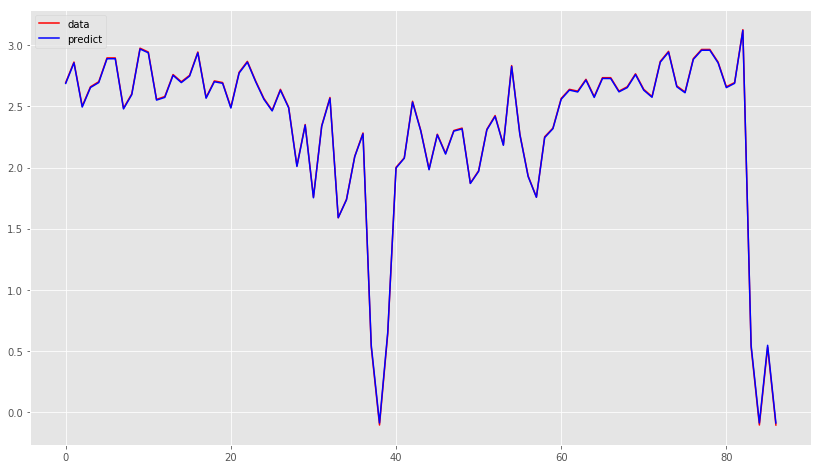

x_scale:  (2, 87, 3, 1)


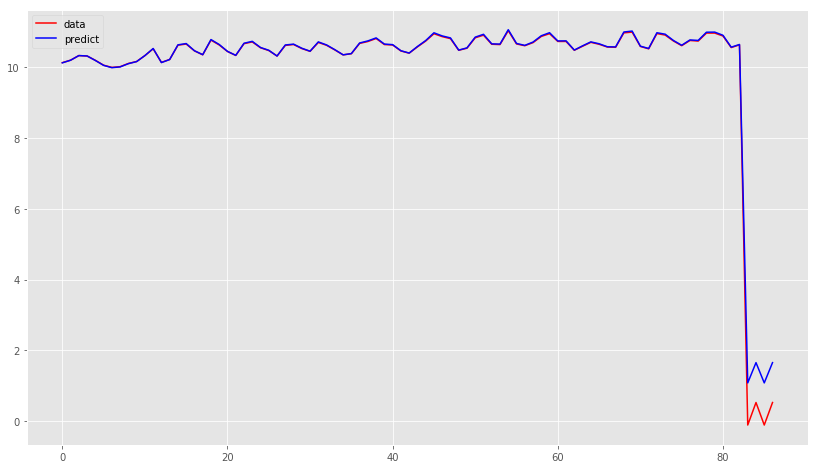

87/87 [==============================] - 0s 88us/step
model evaluate mse: [2.5112592434060983, 0.0180939386288325, 2.493165358729746, 0.0180939387787005, 2.493165358729746]


In [23]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

## 事前学習モデルの精度の評価

In [24]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.010069963371088916
rmse: 0.15909009115334816
0.08458002726221854


In [25]:

del model
gc.collect()

14918

In [26]:
hetero_genious_callbacks.class_weight

{0: 1.0, 1: 3194.3329707635407}

## 学習後の重みを付与

In [27]:
model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )

with timer('train model individual hetero'):
    model.fit(x, x, validation_split=0.1, class_weight=hetero_genious_callbacks.class_weight, 
              epochs=1000, callbacks=[tensorboard])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 3, 120)       58560       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 3, 150)       91200       input_6[0][0]                    
__________________________________________________________________________________________________
dense_5 (D

135/135 [==============================] - 0s 230us/step - loss: 0.0418 - dense_5_loss: 0.0107 - dense_6_loss: 0.0311 - dense_5_mean_squared_error: 0.0107 - dense_6_mean_squared_error: 0.0311 - val_loss: 0.0755 - val_dense_5_loss: 0.0140 - val_dense_6_loss: 0.0615 - val_dense_5_mean_squared_error: 0.0140 - val_dense_6_mean_squared_error: 0.0615
Epoch 20/1000
135/135 [==============================] - 0s 226us/step - loss: 0.0369 - dense_5_loss: 0.0102 - dense_6_loss: 0.0267 - dense_5_mean_squared_error: 0.0102 - dense_6_mean_squared_error: 0.0267 - val_loss: 0.0714 - val_dense_5_loss: 0.0136 - val_dense_6_loss: 0.0578 - val_dense_5_mean_squared_error: 0.0136 - val_dense_6_mean_squared_error: 0.0578
Epoch 21/1000
135/135 [==============================] - 0s 226us/step - loss: 0.0328 - dense_5_loss: 0.0096 - dense_6_loss: 0.0232 - dense_5_mean_squared_error: 0.0096 - dense_6_mean_squared_error: 0.0232 - val_loss: 0.0680 - val_dense_5_loss: 0.0132 - val_dense_6_loss: 0.0548 - val_dense_5

Epoch 42/1000
135/135 [==============================] - 0s 209us/step - loss: 0.0034 - dense_5_loss: 0.0018 - dense_6_loss: 0.0016 - dense_5_mean_squared_error: 0.0018 - dense_6_mean_squared_error: 0.0016 - val_loss: 0.0406 - val_dense_5_loss: 0.0052 - val_dense_6_loss: 0.0354 - val_dense_5_mean_squared_error: 0.0052 - val_dense_6_mean_squared_error: 0.0354
Epoch 43/1000
135/135 [==============================] - 0s 205us/step - loss: 0.0033 - dense_5_loss: 0.0017 - dense_6_loss: 0.0016 - dense_5_mean_squared_error: 0.0017 - dense_6_mean_squared_error: 0.0016 - val_loss: 0.0402 - val_dense_5_loss: 0.0050 - val_dense_6_loss: 0.0353 - val_dense_5_mean_squared_error: 0.0050 - val_dense_6_mean_squared_error: 0.0353
Epoch 44/1000
135/135 [==============================] - 0s 220us/step - loss: 0.0031 - dense_5_loss: 0.0015 - dense_6_loss: 0.0016 - dense_5_mean_squared_error: 0.0015 - dense_6_mean_squared_error: 0.0016 - val_loss: 0.0398 - val_dense_5_loss: 0.0048 - val_dense_6_loss: 0.0351

135/135 [==============================] - 0s 244us/step - loss: 0.0018 - dense_5_loss: 3.8820e-04 - dense_6_loss: 0.0014 - dense_5_mean_squared_error: 3.8820e-04 - dense_6_mean_squared_error: 0.0014 - val_loss: 0.0330 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0318 - val_dense_5_mean_squared_error: 0.0013 - val_dense_6_mean_squared_error: 0.0318
Epoch 65/1000
135/135 [==============================] - 0s 246us/step - loss: 0.0018 - dense_5_loss: 3.6313e-04 - dense_6_loss: 0.0014 - dense_5_mean_squared_error: 3.6313e-04 - dense_6_mean_squared_error: 0.0014 - val_loss: 0.0328 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0316 - val_dense_5_mean_squared_error: 0.0012 - val_dense_6_mean_squared_error: 0.0316
Epoch 66/1000
135/135 [==============================] - 0s 242us/step - loss: 0.0017 - dense_5_loss: 3.2870e-04 - dense_6_loss: 0.0014 - dense_5_mean_squared_error: 3.2870e-04 - dense_6_mean_squared_error: 0.0014 - val_loss: 0.0325 - val_dense_5_loss: 0.0010 - val_dense_6_lo

Epoch 86/1000
135/135 [==============================] - 0s 231us/step - loss: 0.0013 - dense_5_loss: 5.1549e-05 - dense_6_loss: 0.0013 - dense_5_mean_squared_error: 5.1549e-05 - dense_6_mean_squared_error: 0.0013 - val_loss: 0.0281 - val_dense_5_loss: 1.1037e-04 - val_dense_6_loss: 0.0280 - val_dense_5_mean_squared_error: 1.1037e-04 - val_dense_6_mean_squared_error: 0.0280
Epoch 87/1000
135/135 [==============================] - 0s 234us/step - loss: 0.0013 - dense_5_loss: 4.7680e-05 - dense_6_loss: 0.0013 - dense_5_mean_squared_error: 4.7680e-05 - dense_6_mean_squared_error: 0.0013 - val_loss: 0.0279 - val_dense_5_loss: 1.0084e-04 - val_dense_6_loss: 0.0278 - val_dense_5_mean_squared_error: 1.0084e-04 - val_dense_6_mean_squared_error: 0.0278
Epoch 88/1000
135/135 [==============================] - 0s 246us/step - loss: 0.0013 - dense_5_loss: 4.3473e-05 - dense_6_loss: 0.0013 - dense_5_mean_squared_error: 4.3473e-05 - dense_6_mean_squared_error: 0.0013 - val_loss: 0.0277 - val_dense_5

Epoch 108/1000
135/135 [==============================] - 0s 237us/step - loss: 0.0011 - dense_5_loss: 1.0667e-05 - dense_6_loss: 0.0011 - dense_5_mean_squared_error: 1.0667e-05 - dense_6_mean_squared_error: 0.0011 - val_loss: 0.0243 - val_dense_5_loss: 1.7454e-05 - val_dense_6_loss: 0.0243 - val_dense_5_mean_squared_error: 1.7454e-05 - val_dense_6_mean_squared_error: 0.0243
Epoch 109/1000
135/135 [==============================] - 0s 230us/step - loss: 0.0011 - dense_5_loss: 1.0147e-05 - dense_6_loss: 0.0011 - dense_5_mean_squared_error: 1.0147e-05 - dense_6_mean_squared_error: 0.0011 - val_loss: 0.0242 - val_dense_5_loss: 1.6471e-05 - val_dense_6_loss: 0.0242 - val_dense_5_mean_squared_error: 1.6471e-05 - val_dense_6_mean_squared_error: 0.0242
Epoch 110/1000
135/135 [==============================] - 0s 229us/step - loss: 0.0011 - dense_5_loss: 9.6539e-06 - dense_6_loss: 0.0011 - dense_5_mean_squared_error: 9.6539e-06 - dense_6_mean_squared_error: 0.0011 - val_loss: 0.0240 - val_dens

135/135 [==============================] - 0s 261us/step - loss: 9.6181e-04 - dense_5_loss: 5.8199e-06 - dense_6_loss: 9.5599e-04 - dense_5_mean_squared_error: 5.8199e-06 - dense_6_mean_squared_error: 9.5599e-04 - val_loss: 0.0211 - val_dense_5_loss: 9.4697e-06 - val_dense_6_loss: 0.0211 - val_dense_5_mean_squared_error: 9.4697e-06 - val_dense_6_mean_squared_error: 0.0211
Epoch 130/1000
135/135 [==============================] - 0s 235us/step - loss: 9.5002e-04 - dense_5_loss: 5.7875e-06 - dense_6_loss: 9.4423e-04 - dense_5_mean_squared_error: 5.7875e-06 - dense_6_mean_squared_error: 9.4423e-04 - val_loss: 0.0210 - val_dense_5_loss: 9.2734e-06 - val_dense_6_loss: 0.0210 - val_dense_5_mean_squared_error: 9.2734e-06 - val_dense_6_mean_squared_error: 0.0210
Epoch 131/1000
135/135 [==============================] - 0s 237us/step - loss: 9.4595e-04 - dense_5_loss: 5.7284e-06 - dense_6_loss: 9.4022e-04 - dense_5_mean_squared_error: 5.7284e-06 - dense_6_mean_squared_error: 9.4022e-04 - val_lo

135/135 [==============================] - 0s 236us/step - loss: 8.3961e-04 - dense_5_loss: 5.2108e-06 - dense_6_loss: 8.3440e-04 - dense_5_mean_squared_error: 5.2108e-06 - dense_6_mean_squared_error: 8.3440e-04 - val_loss: 0.0187 - val_dense_5_loss: 8.0807e-06 - val_dense_6_loss: 0.0187 - val_dense_5_mean_squared_error: 8.0807e-06 - val_dense_6_mean_squared_error: 0.0187
Epoch 151/1000
135/135 [==============================] - 0s 247us/step - loss: 8.3576e-04 - dense_5_loss: 5.1847e-06 - dense_6_loss: 8.3058e-04 - dense_5_mean_squared_error: 5.1847e-06 - dense_6_mean_squared_error: 8.3058e-04 - val_loss: 0.0186 - val_dense_5_loss: 7.9837e-06 - val_dense_6_loss: 0.0186 - val_dense_5_mean_squared_error: 7.9837e-06 - val_dense_6_mean_squared_error: 0.0186
Epoch 152/1000
135/135 [==============================] - 0s 246us/step - loss: 8.2849e-04 - dense_5_loss: 5.0080e-06 - dense_6_loss: 8.2348e-04 - dense_5_mean_squared_error: 5.0080e-06 - dense_6_mean_squared_error: 8.2348e-04 - val_lo

135/135 [==============================] - 0s 231us/step - loss: 7.3533e-04 - dense_5_loss: 4.6156e-06 - dense_6_loss: 7.3071e-04 - dense_5_mean_squared_error: 4.6156e-06 - dense_6_mean_squared_error: 7.3071e-04 - val_loss: 0.0167 - val_dense_5_loss: 7.3546e-06 - val_dense_6_loss: 0.0167 - val_dense_5_mean_squared_error: 7.3546e-06 - val_dense_6_mean_squared_error: 0.0167
Epoch 172/1000
135/135 [==============================] - 0s 225us/step - loss: 7.3178e-04 - dense_5_loss: 4.6127e-06 - dense_6_loss: 7.2717e-04 - dense_5_mean_squared_error: 4.6127e-06 - dense_6_mean_squared_error: 7.2717e-04 - val_loss: 0.0166 - val_dense_5_loss: 7.3397e-06 - val_dense_6_loss: 0.0166 - val_dense_5_mean_squared_error: 7.3397e-06 - val_dense_6_mean_squared_error: 0.0166
Epoch 173/1000
135/135 [==============================] - 0s 223us/step - loss: 7.2965e-04 - dense_5_loss: 4.6292e-06 - dense_6_loss: 7.2502e-04 - dense_5_mean_squared_error: 4.6292e-06 - dense_6_mean_squared_error: 7.2502e-04 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 6.5045e-04 - dense_5_loss: 4.2109e-06 - dense_6_loss: 6.4624e-04 - dense_5_mean_squared_error: 4.2109e-06 - dense_6_mean_squared_error: 6.4624e-04 - val_loss: 0.0152 - val_dense_5_loss: 6.5638e-06 - val_dense_6_loss: 0.0152 - val_dense_5_mean_squared_error: 6.5638e-06 - val_dense_6_mean_squared_error: 0.0152
Epoch 193/1000
135/135 [==============================] - 0s 226us/step - loss: 6.4678e-04 - dense_5_loss: 4.2259e-06 - dense_6_loss: 6.4255e-04 - dense_5_mean_squared_error: 4.2259e-06 - dense_6_mean_squared_error: 6.4255e-04 - val_loss: 0.0151 - val_dense_5_loss: 6.6340e-06 - val_dense_6_loss: 0.0151 - val_dense_5_mean_squared_error: 6.6340e-06 - val_dense_6_mean_squared_error: 0.0151
Epoch 194/1000
135/135 [==============================] - 0s 229us/step - loss: 6.4185e-04 - dense_5_loss: 4.2311e-06 - dense_6_loss: 6.3762e-04 - dense_5_mean_squared_error: 4.2311e-06 - dense_6_mean_squared_error: 6.3762e-04 - val_lo

135/135 [==============================] - 0s 229us/step - loss: 5.7261e-04 - dense_5_loss: 3.9338e-06 - dense_6_loss: 5.6868e-04 - dense_5_mean_squared_error: 3.9338e-06 - dense_6_mean_squared_error: 5.6868e-04 - val_loss: 0.0139 - val_dense_5_loss: 6.0130e-06 - val_dense_6_loss: 0.0139 - val_dense_5_mean_squared_error: 6.0130e-06 - val_dense_6_mean_squared_error: 0.0139
Epoch 214/1000
135/135 [==============================] - 0s 234us/step - loss: 5.7011e-04 - dense_5_loss: 3.8746e-06 - dense_6_loss: 5.6624e-04 - dense_5_mean_squared_error: 3.8746e-06 - dense_6_mean_squared_error: 5.6624e-04 - val_loss: 0.0138 - val_dense_5_loss: 6.0052e-06 - val_dense_6_loss: 0.0138 - val_dense_5_mean_squared_error: 6.0052e-06 - val_dense_6_mean_squared_error: 0.0138
Epoch 215/1000
135/135 [==============================] - 0s 223us/step - loss: 5.6339e-04 - dense_5_loss: 3.8335e-06 - dense_6_loss: 5.5956e-04 - dense_5_mean_squared_error: 3.8335e-06 - dense_6_mean_squared_error: 5.5956e-04 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 4.9113e-04 - dense_5_loss: 3.5374e-06 - dense_6_loss: 4.8759e-04 - dense_5_mean_squared_error: 3.5374e-06 - dense_6_mean_squared_error: 4.8759e-04 - val_loss: 0.0128 - val_dense_5_loss: 5.7461e-06 - val_dense_6_loss: 0.0128 - val_dense_5_mean_squared_error: 5.7461e-06 - val_dense_6_mean_squared_error: 0.0128
Epoch 235/1000
135/135 [==============================] - 0s 228us/step - loss: 4.9386e-04 - dense_5_loss: 3.6013e-06 - dense_6_loss: 4.9025e-04 - dense_5_mean_squared_error: 3.6013e-06 - dense_6_mean_squared_error: 4.9025e-04 - val_loss: 0.0128 - val_dense_5_loss: 5.4618e-06 - val_dense_6_loss: 0.0128 - val_dense_5_mean_squared_error: 5.4618e-06 - val_dense_6_mean_squared_error: 0.0128
Epoch 236/1000
135/135 [==============================] - 0s 226us/step - loss: 4.8772e-04 - dense_5_loss: 3.5072e-06 - dense_6_loss: 4.8421e-04 - dense_5_mean_squared_error: 3.5072e-06 - dense_6_mean_squared_error: 4.8421e-04 - val_lo

135/135 [==============================] - 0s 229us/step - loss: 4.2180e-04 - dense_5_loss: 3.3253e-06 - dense_6_loss: 4.1848e-04 - dense_5_mean_squared_error: 3.3253e-06 - dense_6_mean_squared_error: 4.1848e-04 - val_loss: 0.0118 - val_dense_5_loss: 5.0003e-06 - val_dense_6_loss: 0.0118 - val_dense_5_mean_squared_error: 5.0003e-06 - val_dense_6_mean_squared_error: 0.0118
Epoch 256/1000
135/135 [==============================] - 0s 216us/step - loss: 4.1750e-04 - dense_5_loss: 3.3470e-06 - dense_6_loss: 4.1416e-04 - dense_5_mean_squared_error: 3.3470e-06 - dense_6_mean_squared_error: 4.1416e-04 - val_loss: 0.0118 - val_dense_5_loss: 5.1745e-06 - val_dense_6_loss: 0.0118 - val_dense_5_mean_squared_error: 5.1745e-06 - val_dense_6_mean_squared_error: 0.0118
Epoch 257/1000
135/135 [==============================] - 0s 224us/step - loss: 4.1202e-04 - dense_5_loss: 3.2239e-06 - dense_6_loss: 4.0880e-04 - dense_5_mean_squared_error: 3.2239e-06 - dense_6_mean_squared_error: 4.0880e-04 - val_lo

135/135 [==============================] - 0s 209us/step - loss: 3.5301e-04 - dense_5_loss: 2.9523e-06 - dense_6_loss: 3.5006e-04 - dense_5_mean_squared_error: 2.9523e-06 - dense_6_mean_squared_error: 3.5006e-04 - val_loss: 0.0108 - val_dense_5_loss: 4.2646e-06 - val_dense_6_loss: 0.0108 - val_dense_5_mean_squared_error: 4.2646e-06 - val_dense_6_mean_squared_error: 0.0108
Epoch 277/1000
135/135 [==============================] - 0s 203us/step - loss: 3.5201e-04 - dense_5_loss: 2.9344e-06 - dense_6_loss: 3.4908e-04 - dense_5_mean_squared_error: 2.9344e-06 - dense_6_mean_squared_error: 3.4908e-04 - val_loss: 0.0107 - val_dense_5_loss: 4.2821e-06 - val_dense_6_loss: 0.0107 - val_dense_5_mean_squared_error: 4.2821e-06 - val_dense_6_mean_squared_error: 0.0107
Epoch 278/1000
135/135 [==============================] - 0s 204us/step - loss: 3.4720e-04 - dense_5_loss: 2.8988e-06 - dense_6_loss: 3.4430e-04 - dense_5_mean_squared_error: 2.8988e-06 - dense_6_mean_squared_error: 3.4430e-04 - val_lo

135/135 [==============================] - 0s 214us/step - loss: 2.9432e-04 - dense_5_loss: 2.6803e-06 - dense_6_loss: 2.9164e-04 - dense_5_mean_squared_error: 2.6803e-06 - dense_6_mean_squared_error: 2.9164e-04 - val_loss: 0.0098 - val_dense_5_loss: 3.9331e-06 - val_dense_6_loss: 0.0098 - val_dense_5_mean_squared_error: 3.9331e-06 - val_dense_6_mean_squared_error: 0.0098
Epoch 298/1000
135/135 [==============================] - 0s 209us/step - loss: 2.9219e-04 - dense_5_loss: 2.6985e-06 - dense_6_loss: 2.8950e-04 - dense_5_mean_squared_error: 2.6985e-06 - dense_6_mean_squared_error: 2.8950e-04 - val_loss: 0.0098 - val_dense_5_loss: 3.9938e-06 - val_dense_6_loss: 0.0098 - val_dense_5_mean_squared_error: 3.9938e-06 - val_dense_6_mean_squared_error: 0.0098
Epoch 299/1000
135/135 [==============================] - 0s 213us/step - loss: 2.8728e-04 - dense_5_loss: 2.6994e-06 - dense_6_loss: 2.8458e-04 - dense_5_mean_squared_error: 2.6994e-06 - dense_6_mean_squared_error: 2.8458e-04 - val_lo

135/135 [==============================] - 0s 231us/step - loss: 2.4400e-04 - dense_5_loss: 2.5333e-06 - dense_6_loss: 2.4147e-04 - dense_5_mean_squared_error: 2.5333e-06 - dense_6_mean_squared_error: 2.4147e-04 - val_loss: 0.0089 - val_dense_5_loss: 3.6771e-06 - val_dense_6_loss: 0.0089 - val_dense_5_mean_squared_error: 3.6771e-06 - val_dense_6_mean_squared_error: 0.0089
Epoch 319/1000
135/135 [==============================] - 0s 219us/step - loss: 2.4082e-04 - dense_5_loss: 2.5494e-06 - dense_6_loss: 2.3827e-04 - dense_5_mean_squared_error: 2.5494e-06 - dense_6_mean_squared_error: 2.3827e-04 - val_loss: 0.0089 - val_dense_5_loss: 3.8153e-06 - val_dense_6_loss: 0.0089 - val_dense_5_mean_squared_error: 3.8153e-06 - val_dense_6_mean_squared_error: 0.0089
Epoch 320/1000
135/135 [==============================] - 0s 218us/step - loss: 2.3757e-04 - dense_5_loss: 2.4723e-06 - dense_6_loss: 2.3510e-04 - dense_5_mean_squared_error: 2.4723e-06 - dense_6_mean_squared_error: 2.3510e-04 - val_lo

135/135 [==============================] - 0s 225us/step - loss: 2.0120e-04 - dense_5_loss: 2.2375e-06 - dense_6_loss: 1.9896e-04 - dense_5_mean_squared_error: 2.2375e-06 - dense_6_mean_squared_error: 1.9896e-04 - val_loss: 0.0081 - val_dense_5_loss: 3.4895e-06 - val_dense_6_loss: 0.0081 - val_dense_5_mean_squared_error: 3.4895e-06 - val_dense_6_mean_squared_error: 0.0081
Epoch 340/1000
135/135 [==============================] - 0s 230us/step - loss: 1.9973e-04 - dense_5_loss: 2.2692e-06 - dense_6_loss: 1.9746e-04 - dense_5_mean_squared_error: 2.2692e-06 - dense_6_mean_squared_error: 1.9746e-04 - val_loss: 0.0080 - val_dense_5_loss: 3.5322e-06 - val_dense_6_loss: 0.0080 - val_dense_5_mean_squared_error: 3.5322e-06 - val_dense_6_mean_squared_error: 0.0080
Epoch 341/1000
135/135 [==============================] - 0s 234us/step - loss: 1.9721e-04 - dense_5_loss: 2.2045e-06 - dense_6_loss: 1.9501e-04 - dense_5_mean_squared_error: 2.2045e-06 - dense_6_mean_squared_error: 1.9501e-04 - val_lo

135/135 [==============================] - 0s 228us/step - loss: 1.6526e-04 - dense_5_loss: 2.0545e-06 - dense_6_loss: 1.6320e-04 - dense_5_mean_squared_error: 2.0545e-06 - dense_6_mean_squared_error: 1.6320e-04 - val_loss: 0.0072 - val_dense_5_loss: 3.1331e-06 - val_dense_6_loss: 0.0072 - val_dense_5_mean_squared_error: 3.1331e-06 - val_dense_6_mean_squared_error: 0.0072
Epoch 361/1000
135/135 [==============================] - 0s 230us/step - loss: 1.6256e-04 - dense_5_loss: 2.0505e-06 - dense_6_loss: 1.6051e-04 - dense_5_mean_squared_error: 2.0505e-06 - dense_6_mean_squared_error: 1.6051e-04 - val_loss: 0.0072 - val_dense_5_loss: 3.0729e-06 - val_dense_6_loss: 0.0072 - val_dense_5_mean_squared_error: 3.0729e-06 - val_dense_6_mean_squared_error: 0.0072
Epoch 362/1000
135/135 [==============================] - 0s 234us/step - loss: 1.6020e-04 - dense_5_loss: 2.0354e-06 - dense_6_loss: 1.5817e-04 - dense_5_mean_squared_error: 2.0354e-06 - dense_6_mean_squared_error: 1.5817e-04 - val_lo

135/135 [==============================] - 0s 221us/step - loss: 1.3567e-04 - dense_5_loss: 1.8898e-06 - dense_6_loss: 1.3378e-04 - dense_5_mean_squared_error: 1.8898e-06 - dense_6_mean_squared_error: 1.3378e-04 - val_loss: 0.0065 - val_dense_5_loss: 2.9643e-06 - val_dense_6_loss: 0.0065 - val_dense_5_mean_squared_error: 2.9643e-06 - val_dense_6_mean_squared_error: 0.0065
Epoch 382/1000
135/135 [==============================] - 0s 232us/step - loss: 1.3348e-04 - dense_5_loss: 1.8986e-06 - dense_6_loss: 1.3159e-04 - dense_5_mean_squared_error: 1.8986e-06 - dense_6_mean_squared_error: 1.3159e-04 - val_loss: 0.0065 - val_dense_5_loss: 2.9071e-06 - val_dense_6_loss: 0.0065 - val_dense_5_mean_squared_error: 2.9071e-06 - val_dense_6_mean_squared_error: 0.0065
Epoch 383/1000
135/135 [==============================] - 0s 229us/step - loss: 1.3217e-04 - dense_5_loss: 1.8539e-06 - dense_6_loss: 1.3032e-04 - dense_5_mean_squared_error: 1.8539e-06 - dense_6_mean_squared_error: 1.3032e-04 - val_lo

135/135 [==============================] - 0s 208us/step - loss: 1.1169e-04 - dense_5_loss: 1.7239e-06 - dense_6_loss: 1.0996e-04 - dense_5_mean_squared_error: 1.7239e-06 - dense_6_mean_squared_error: 1.0996e-04 - val_loss: 0.0058 - val_dense_5_loss: 2.6011e-06 - val_dense_6_loss: 0.0058 - val_dense_5_mean_squared_error: 2.6011e-06 - val_dense_6_mean_squared_error: 0.0058
Epoch 403/1000
135/135 [==============================] - 0s 201us/step - loss: 1.1319e-04 - dense_5_loss: 1.7327e-06 - dense_6_loss: 1.1146e-04 - dense_5_mean_squared_error: 1.7327e-06 - dense_6_mean_squared_error: 1.1146e-04 - val_loss: 0.0058 - val_dense_5_loss: 2.6776e-06 - val_dense_6_loss: 0.0058 - val_dense_5_mean_squared_error: 2.6776e-06 - val_dense_6_mean_squared_error: 0.0058
Epoch 404/1000
135/135 [==============================] - 0s 200us/step - loss: 1.1208e-04 - dense_5_loss: 1.7229e-06 - dense_6_loss: 1.1035e-04 - dense_5_mean_squared_error: 1.7229e-06 - dense_6_mean_squared_error: 1.1035e-04 - val_lo

135/135 [==============================] - 0s 228us/step - loss: 9.7896e-05 - dense_5_loss: 1.5673e-06 - dense_6_loss: 9.6329e-05 - dense_5_mean_squared_error: 1.5673e-06 - dense_6_mean_squared_error: 9.6329e-05 - val_loss: 0.0053 - val_dense_5_loss: 2.5441e-06 - val_dense_6_loss: 0.0053 - val_dense_5_mean_squared_error: 2.5441e-06 - val_dense_6_mean_squared_error: 0.0053
Epoch 424/1000
135/135 [==============================] - 0s 224us/step - loss: 9.2568e-05 - dense_5_loss: 1.5764e-06 - dense_6_loss: 9.0992e-05 - dense_5_mean_squared_error: 1.5764e-06 - dense_6_mean_squared_error: 9.0992e-05 - val_loss: 0.0052 - val_dense_5_loss: 2.4630e-06 - val_dense_6_loss: 0.0052 - val_dense_5_mean_squared_error: 2.4630e-06 - val_dense_6_mean_squared_error: 0.0052
Epoch 425/1000
135/135 [==============================] - 0s 216us/step - loss: 9.1545e-05 - dense_5_loss: 1.5835e-06 - dense_6_loss: 8.9961e-05 - dense_5_mean_squared_error: 1.5835e-06 - dense_6_mean_squared_error: 8.9961e-05 - val_lo

135/135 [==============================] - 0s 206us/step - loss: 7.7839e-05 - dense_5_loss: 1.4791e-06 - dense_6_loss: 7.6360e-05 - dense_5_mean_squared_error: 1.4791e-06 - dense_6_mean_squared_error: 7.6360e-05 - val_loss: 0.0048 - val_dense_5_loss: 2.1909e-06 - val_dense_6_loss: 0.0048 - val_dense_5_mean_squared_error: 2.1909e-06 - val_dense_6_mean_squared_error: 0.0048
Epoch 445/1000
135/135 [==============================] - 0s 220us/step - loss: 7.5934e-05 - dense_5_loss: 1.4603e-06 - dense_6_loss: 7.4474e-05 - dense_5_mean_squared_error: 1.4603e-06 - dense_6_mean_squared_error: 7.4474e-05 - val_loss: 0.0047 - val_dense_5_loss: 2.3945e-06 - val_dense_6_loss: 0.0047 - val_dense_5_mean_squared_error: 2.3945e-06 - val_dense_6_mean_squared_error: 0.0047
Epoch 446/1000
135/135 [==============================] - 0s 214us/step - loss: 7.5259e-05 - dense_5_loss: 1.4903e-06 - dense_6_loss: 7.3769e-05 - dense_5_mean_squared_error: 1.4903e-06 - dense_6_mean_squared_error: 7.3769e-05 - val_lo

135/135 [==============================] - 0s 220us/step - loss: 6.6745e-05 - dense_5_loss: 1.3139e-06 - dense_6_loss: 6.5431e-05 - dense_5_mean_squared_error: 1.3139e-06 - dense_6_mean_squared_error: 6.5431e-05 - val_loss: 0.0043 - val_dense_5_loss: 2.2138e-06 - val_dense_6_loss: 0.0043 - val_dense_5_mean_squared_error: 2.2138e-06 - val_dense_6_mean_squared_error: 0.0043
Epoch 466/1000
135/135 [==============================] - 0s 229us/step - loss: 6.4221e-05 - dense_5_loss: 1.3259e-06 - dense_6_loss: 6.2895e-05 - dense_5_mean_squared_error: 1.3259e-06 - dense_6_mean_squared_error: 6.2895e-05 - val_loss: 0.0043 - val_dense_5_loss: 2.1644e-06 - val_dense_6_loss: 0.0043 - val_dense_5_mean_squared_error: 2.1644e-06 - val_dense_6_mean_squared_error: 0.0043
Epoch 467/1000
135/135 [==============================] - 0s 232us/step - loss: 6.2776e-05 - dense_5_loss: 1.3280e-06 - dense_6_loss: 6.1448e-05 - dense_5_mean_squared_error: 1.3280e-06 - dense_6_mean_squared_error: 6.1448e-05 - val_lo

135/135 [==============================] - 0s 231us/step - loss: 5.3517e-05 - dense_5_loss: 1.3267e-06 - dense_6_loss: 5.2191e-05 - dense_5_mean_squared_error: 1.3267e-06 - dense_6_mean_squared_error: 5.2191e-05 - val_loss: 0.0039 - val_dense_5_loss: 2.0364e-06 - val_dense_6_loss: 0.0039 - val_dense_5_mean_squared_error: 2.0364e-06 - val_dense_6_mean_squared_error: 0.0039
Epoch 487/1000
135/135 [==============================] - 0s 224us/step - loss: 5.2882e-05 - dense_5_loss: 1.2375e-06 - dense_6_loss: 5.1645e-05 - dense_5_mean_squared_error: 1.2375e-06 - dense_6_mean_squared_error: 5.1645e-05 - val_loss: 0.0039 - val_dense_5_loss: 1.9617e-06 - val_dense_6_loss: 0.0039 - val_dense_5_mean_squared_error: 1.9617e-06 - val_dense_6_mean_squared_error: 0.0039
Epoch 488/1000
135/135 [==============================] - 0s 223us/step - loss: 5.2397e-05 - dense_5_loss: 1.2451e-06 - dense_6_loss: 5.1152e-05 - dense_5_mean_squared_error: 1.2451e-06 - dense_6_mean_squared_error: 5.1152e-05 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 4.4792e-05 - dense_5_loss: 1.1228e-06 - dense_6_loss: 4.3669e-05 - dense_5_mean_squared_error: 1.1228e-06 - dense_6_mean_squared_error: 4.3669e-05 - val_loss: 0.0036 - val_dense_5_loss: 1.7837e-06 - val_dense_6_loss: 0.0036 - val_dense_5_mean_squared_error: 1.7837e-06 - val_dense_6_mean_squared_error: 0.0036
Epoch 508/1000
135/135 [==============================] - 0s 229us/step - loss: 4.4086e-05 - dense_5_loss: 1.1250e-06 - dense_6_loss: 4.2961e-05 - dense_5_mean_squared_error: 1.1250e-06 - dense_6_mean_squared_error: 4.2961e-05 - val_loss: 0.0036 - val_dense_5_loss: 1.8272e-06 - val_dense_6_loss: 0.0036 - val_dense_5_mean_squared_error: 1.8272e-06 - val_dense_6_mean_squared_error: 0.0036
Epoch 509/1000
135/135 [==============================] - 0s 228us/step - loss: 4.3664e-05 - dense_5_loss: 1.0782e-06 - dense_6_loss: 4.2586e-05 - dense_5_mean_squared_error: 1.0782e-06 - dense_6_mean_squared_error: 4.2586e-05 - val_lo

135/135 [==============================] - 0s 210us/step - loss: 3.7520e-05 - dense_5_loss: 9.8667e-07 - dense_6_loss: 3.6533e-05 - dense_5_mean_squared_error: 9.8667e-07 - dense_6_mean_squared_error: 3.6533e-05 - val_loss: 0.0033 - val_dense_5_loss: 1.6936e-06 - val_dense_6_loss: 0.0033 - val_dense_5_mean_squared_error: 1.6936e-06 - val_dense_6_mean_squared_error: 0.0033
Epoch 529/1000
135/135 [==============================] - 0s 221us/step - loss: 3.8557e-05 - dense_5_loss: 1.0340e-06 - dense_6_loss: 3.7523e-05 - dense_5_mean_squared_error: 1.0340e-06 - dense_6_mean_squared_error: 3.7523e-05 - val_loss: 0.0033 - val_dense_5_loss: 1.7258e-06 - val_dense_6_loss: 0.0033 - val_dense_5_mean_squared_error: 1.7258e-06 - val_dense_6_mean_squared_error: 0.0033
Epoch 530/1000
135/135 [==============================] - 0s 219us/step - loss: 3.7704e-05 - dense_5_loss: 1.0102e-06 - dense_6_loss: 3.6694e-05 - dense_5_mean_squared_error: 1.0102e-06 - dense_6_mean_squared_error: 3.6694e-05 - val_lo

135/135 [==============================] - 0s 218us/step - loss: 3.0760e-05 - dense_5_loss: 1.0331e-06 - dense_6_loss: 2.9727e-05 - dense_5_mean_squared_error: 1.0331e-06 - dense_6_mean_squared_error: 2.9727e-05 - val_loss: 0.0031 - val_dense_5_loss: 1.5987e-06 - val_dense_6_loss: 0.0031 - val_dense_5_mean_squared_error: 1.5987e-06 - val_dense_6_mean_squared_error: 0.0031
Epoch 550/1000
135/135 [==============================] - 0s 232us/step - loss: 3.0594e-05 - dense_5_loss: 9.8670e-07 - dense_6_loss: 2.9607e-05 - dense_5_mean_squared_error: 9.8670e-07 - dense_6_mean_squared_error: 2.9607e-05 - val_loss: 0.0030 - val_dense_5_loss: 1.7631e-06 - val_dense_6_loss: 0.0030 - val_dense_5_mean_squared_error: 1.7631e-06 - val_dense_6_mean_squared_error: 0.0030
Epoch 551/1000
135/135 [==============================] - 0s 230us/step - loss: 3.0249e-05 - dense_5_loss: 1.0263e-06 - dense_6_loss: 2.9223e-05 - dense_5_mean_squared_error: 1.0263e-06 - dense_6_mean_squared_error: 2.9223e-05 - val_lo

135/135 [==============================] - 0s 237us/step - loss: 2.5041e-05 - dense_5_loss: 8.2879e-07 - dense_6_loss: 2.4212e-05 - dense_5_mean_squared_error: 8.2879e-07 - dense_6_mean_squared_error: 2.4212e-05 - val_loss: 0.0028 - val_dense_5_loss: 1.4981e-06 - val_dense_6_loss: 0.0028 - val_dense_5_mean_squared_error: 1.4981e-06 - val_dense_6_mean_squared_error: 0.0028
Epoch 571/1000
135/135 [==============================] - 0s 225us/step - loss: 2.5189e-05 - dense_5_loss: 8.5657e-07 - dense_6_loss: 2.4332e-05 - dense_5_mean_squared_error: 8.5657e-07 - dense_6_mean_squared_error: 2.4332e-05 - val_loss: 0.0028 - val_dense_5_loss: 1.5261e-06 - val_dense_6_loss: 0.0028 - val_dense_5_mean_squared_error: 1.5261e-06 - val_dense_6_mean_squared_error: 0.0028
Epoch 572/1000
135/135 [==============================] - 0s 237us/step - loss: 2.5132e-05 - dense_5_loss: 8.1483e-07 - dense_6_loss: 2.4317e-05 - dense_5_mean_squared_error: 8.1483e-07 - dense_6_mean_squared_error: 2.4317e-05 - val_lo

135/135 [==============================] - 0s 275us/step - loss: 2.3081e-05 - dense_5_loss: 8.2467e-07 - dense_6_loss: 2.2257e-05 - dense_5_mean_squared_error: 8.2467e-07 - dense_6_mean_squared_error: 2.2257e-05 - val_loss: 0.0026 - val_dense_5_loss: 1.4505e-06 - val_dense_6_loss: 0.0026 - val_dense_5_mean_squared_error: 1.4505e-06 - val_dense_6_mean_squared_error: 0.0026
Epoch 592/1000
135/135 [==============================] - 0s 287us/step - loss: 2.3393e-05 - dense_5_loss: 8.7033e-07 - dense_6_loss: 2.2523e-05 - dense_5_mean_squared_error: 8.7033e-07 - dense_6_mean_squared_error: 2.2523e-05 - val_loss: 0.0026 - val_dense_5_loss: 1.2722e-06 - val_dense_6_loss: 0.0026 - val_dense_5_mean_squared_error: 1.2722e-06 - val_dense_6_mean_squared_error: 0.0026
Epoch 593/1000
135/135 [==============================] - 0s 233us/step - loss: 2.1392e-05 - dense_5_loss: 7.4762e-07 - dense_6_loss: 2.0645e-05 - dense_5_mean_squared_error: 7.4762e-07 - dense_6_mean_squared_error: 2.0645e-05 - val_lo

135/135 [==============================] - 0s 224us/step - loss: 1.7060e-05 - dense_5_loss: 7.1041e-07 - dense_6_loss: 1.6349e-05 - dense_5_mean_squared_error: 7.1041e-07 - dense_6_mean_squared_error: 1.6349e-05 - val_loss: 0.0024 - val_dense_5_loss: 1.0913e-06 - val_dense_6_loss: 0.0024 - val_dense_5_mean_squared_error: 1.0913e-06 - val_dense_6_mean_squared_error: 0.0024
Epoch 613/1000
135/135 [==============================] - 0s 237us/step - loss: 1.6855e-05 - dense_5_loss: 6.8820e-07 - dense_6_loss: 1.6167e-05 - dense_5_mean_squared_error: 6.8820e-07 - dense_6_mean_squared_error: 1.6167e-05 - val_loss: 0.0024 - val_dense_5_loss: 1.1549e-06 - val_dense_6_loss: 0.0024 - val_dense_5_mean_squared_error: 1.1549e-06 - val_dense_6_mean_squared_error: 0.0024
Epoch 614/1000
135/135 [==============================] - 0s 232us/step - loss: 1.6673e-05 - dense_5_loss: 6.7578e-07 - dense_6_loss: 1.5997e-05 - dense_5_mean_squared_error: 6.7578e-07 - dense_6_mean_squared_error: 1.5997e-05 - val_lo

135/135 [==============================] - 0s 242us/step - loss: 1.3897e-05 - dense_5_loss: 6.3607e-07 - dense_6_loss: 1.3261e-05 - dense_5_mean_squared_error: 6.3607e-07 - dense_6_mean_squared_error: 1.3261e-05 - val_loss: 0.0023 - val_dense_5_loss: 1.0799e-06 - val_dense_6_loss: 0.0023 - val_dense_5_mean_squared_error: 1.0799e-06 - val_dense_6_mean_squared_error: 0.0023
Epoch 634/1000
135/135 [==============================] - 0s 234us/step - loss: 1.4330e-05 - dense_5_loss: 6.1371e-07 - dense_6_loss: 1.3717e-05 - dense_5_mean_squared_error: 6.1371e-07 - dense_6_mean_squared_error: 1.3717e-05 - val_loss: 0.0022 - val_dense_5_loss: 1.0426e-06 - val_dense_6_loss: 0.0022 - val_dense_5_mean_squared_error: 1.0426e-06 - val_dense_6_mean_squared_error: 0.0022
Epoch 635/1000
135/135 [==============================] - 0s 235us/step - loss: 1.4054e-05 - dense_5_loss: 6.0385e-07 - dense_6_loss: 1.3450e-05 - dense_5_mean_squared_error: 6.0385e-07 - dense_6_mean_squared_error: 1.3450e-05 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 1.1387e-05 - dense_5_loss: 5.3704e-07 - dense_6_loss: 1.0850e-05 - dense_5_mean_squared_error: 5.3704e-07 - dense_6_mean_squared_error: 1.0850e-05 - val_loss: 0.0021 - val_dense_5_loss: 9.7045e-07 - val_dense_6_loss: 0.0021 - val_dense_5_mean_squared_error: 9.7045e-07 - val_dense_6_mean_squared_error: 0.0021
Epoch 655/1000
135/135 [==============================] - 0s 239us/step - loss: 1.1433e-05 - dense_5_loss: 5.3814e-07 - dense_6_loss: 1.0894e-05 - dense_5_mean_squared_error: 5.3814e-07 - dense_6_mean_squared_error: 1.0894e-05 - val_loss: 0.0021 - val_dense_5_loss: 1.1021e-06 - val_dense_6_loss: 0.0021 - val_dense_5_mean_squared_error: 1.1021e-06 - val_dense_6_mean_squared_error: 0.0021
Epoch 656/1000
135/135 [==============================] - 0s 231us/step - loss: 1.1212e-05 - dense_5_loss: 5.3617e-07 - dense_6_loss: 1.0676e-05 - dense_5_mean_squared_error: 5.3617e-07 - dense_6_mean_squared_error: 1.0676e-05 - val_lo

135/135 [==============================] - 0s 264us/step - loss: 9.2971e-06 - dense_5_loss: 5.5521e-07 - dense_6_loss: 8.7419e-06 - dense_5_mean_squared_error: 5.5521e-07 - dense_6_mean_squared_error: 8.7419e-06 - val_loss: 0.0020 - val_dense_5_loss: 1.2128e-06 - val_dense_6_loss: 0.0020 - val_dense_5_mean_squared_error: 1.2128e-06 - val_dense_6_mean_squared_error: 0.0020
Epoch 676/1000
135/135 [==============================] - 0s 263us/step - loss: 9.2703e-06 - dense_5_loss: 6.5355e-07 - dense_6_loss: 8.6168e-06 - dense_5_mean_squared_error: 6.5355e-07 - dense_6_mean_squared_error: 8.6168e-06 - val_loss: 0.0020 - val_dense_5_loss: 1.2410e-06 - val_dense_6_loss: 0.0020 - val_dense_5_mean_squared_error: 1.2410e-06 - val_dense_6_mean_squared_error: 0.0020
Epoch 677/1000
135/135 [==============================] - 0s 231us/step - loss: 9.2495e-06 - dense_5_loss: 6.4511e-07 - dense_6_loss: 8.6044e-06 - dense_5_mean_squared_error: 6.4511e-07 - dense_6_mean_squared_error: 8.6044e-06 - val_lo

Epoch 696/1000
135/135 [==============================] - 0s 250us/step - loss: 7.8391e-06 - dense_5_loss: 4.5968e-07 - dense_6_loss: 7.3794e-06 - dense_5_mean_squared_error: 4.5968e-07 - dense_6_mean_squared_error: 7.3794e-06 - val_loss: 0.0019 - val_dense_5_loss: 8.8792e-07 - val_dense_6_loss: 0.0019 - val_dense_5_mean_squared_error: 8.8792e-07 - val_dense_6_mean_squared_error: 0.0019
Epoch 697/1000
135/135 [==============================] - 0s 242us/step - loss: 7.7855e-06 - dense_5_loss: 4.5093e-07 - dense_6_loss: 7.3345e-06 - dense_5_mean_squared_error: 4.5093e-07 - dense_6_mean_squared_error: 7.3345e-06 - val_loss: 0.0018 - val_dense_5_loss: 1.0139e-06 - val_dense_6_loss: 0.0018 - val_dense_5_mean_squared_error: 1.0139e-06 - val_dense_6_mean_squared_error: 0.0018
Epoch 698/1000
135/135 [==============================] - 0s 242us/step - loss: 7.3503e-06 - dense_5_loss: 4.6669e-07 - dense_6_loss: 6.8837e-06 - dense_5_mean_squared_error: 4.6669e-07 - dense_6_mean_squared_error: 6.88

135/135 [==============================] - 0s 225us/step - loss: 6.4190e-06 - dense_5_loss: 4.5844e-07 - dense_6_loss: 5.9606e-06 - dense_5_mean_squared_error: 4.5844e-07 - dense_6_mean_squared_error: 5.9606e-06 - val_loss: 0.0017 - val_dense_5_loss: 9.9311e-07 - val_dense_6_loss: 0.0017 - val_dense_5_mean_squared_error: 9.9311e-07 - val_dense_6_mean_squared_error: 0.0017
Epoch 718/1000
135/135 [==============================] - 0s 208us/step - loss: 6.3038e-06 - dense_5_loss: 4.7333e-07 - dense_6_loss: 5.8305e-06 - dense_5_mean_squared_error: 4.7333e-07 - dense_6_mean_squared_error: 5.8305e-06 - val_loss: 0.0017 - val_dense_5_loss: 1.2124e-06 - val_dense_6_loss: 0.0017 - val_dense_5_mean_squared_error: 1.2124e-06 - val_dense_6_mean_squared_error: 0.0017
Epoch 719/1000
135/135 [==============================] - 0s 210us/step - loss: 6.2174e-06 - dense_5_loss: 4.3762e-07 - dense_6_loss: 5.7798e-06 - dense_5_mean_squared_error: 4.3762e-07 - dense_6_mean_squared_error: 5.7798e-06 - val_lo

135/135 [==============================] - 0s 236us/step - loss: 5.2136e-06 - dense_5_loss: 4.1083e-07 - dense_6_loss: 4.8027e-06 - dense_5_mean_squared_error: 4.1083e-07 - dense_6_mean_squared_error: 4.8027e-06 - val_loss: 0.0017 - val_dense_5_loss: 6.6804e-07 - val_dense_6_loss: 0.0017 - val_dense_5_mean_squared_error: 6.6804e-07 - val_dense_6_mean_squared_error: 0.0017
Epoch 739/1000
135/135 [==============================] - 0s 222us/step - loss: 5.1262e-06 - dense_5_loss: 4.1186e-07 - dense_6_loss: 4.7143e-06 - dense_5_mean_squared_error: 4.1186e-07 - dense_6_mean_squared_error: 4.7143e-06 - val_loss: 0.0017 - val_dense_5_loss: 6.6769e-07 - val_dense_6_loss: 0.0017 - val_dense_5_mean_squared_error: 6.6769e-07 - val_dense_6_mean_squared_error: 0.0017
Epoch 740/1000
135/135 [==============================] - 0s 243us/step - loss: 5.3502e-06 - dense_5_loss: 4.0106e-07 - dense_6_loss: 4.9491e-06 - dense_5_mean_squared_error: 4.0106e-07 - dense_6_mean_squared_error: 4.9491e-06 - val_lo

135/135 [==============================] - 0s 242us/step - loss: 4.7815e-06 - dense_5_loss: 3.3226e-07 - dense_6_loss: 4.4492e-06 - dense_5_mean_squared_error: 3.3226e-07 - dense_6_mean_squared_error: 4.4492e-06 - val_loss: 0.0016 - val_dense_5_loss: 6.5365e-07 - val_dense_6_loss: 0.0016 - val_dense_5_mean_squared_error: 6.5365e-07 - val_dense_6_mean_squared_error: 0.0016
Epoch 760/1000
135/135 [==============================] - 0s 224us/step - loss: 5.2636e-06 - dense_5_loss: 3.4514e-07 - dense_6_loss: 4.9184e-06 - dense_5_mean_squared_error: 3.4514e-07 - dense_6_mean_squared_error: 4.9184e-06 - val_loss: 0.0016 - val_dense_5_loss: 7.6335e-07 - val_dense_6_loss: 0.0016 - val_dense_5_mean_squared_error: 7.6335e-07 - val_dense_6_mean_squared_error: 0.0016
Epoch 761/1000
135/135 [==============================] - 0s 242us/step - loss: 4.4883e-06 - dense_5_loss: 3.3778e-07 - dense_6_loss: 4.1505e-06 - dense_5_mean_squared_error: 3.3778e-07 - dense_6_mean_squared_error: 4.1505e-06 - val_lo

135/135 [==============================] - 0s 210us/step - loss: 3.6572e-06 - dense_5_loss: 2.8183e-07 - dense_6_loss: 3.3754e-06 - dense_5_mean_squared_error: 2.8183e-07 - dense_6_mean_squared_error: 3.3754e-06 - val_loss: 0.0015 - val_dense_5_loss: 7.3709e-07 - val_dense_6_loss: 0.0015 - val_dense_5_mean_squared_error: 7.3709e-07 - val_dense_6_mean_squared_error: 0.0015
Epoch 781/1000
135/135 [==============================] - 0s 227us/step - loss: 3.8158e-06 - dense_5_loss: 2.9785e-07 - dense_6_loss: 3.5180e-06 - dense_5_mean_squared_error: 2.9785e-07 - dense_6_mean_squared_error: 3.5180e-06 - val_loss: 0.0015 - val_dense_5_loss: 8.1888e-07 - val_dense_6_loss: 0.0015 - val_dense_5_mean_squared_error: 8.1888e-07 - val_dense_6_mean_squared_error: 0.0015
Epoch 782/1000
135/135 [==============================] - 0s 225us/step - loss: 3.9104e-06 - dense_5_loss: 2.9749e-07 - dense_6_loss: 3.6129e-06 - dense_5_mean_squared_error: 2.9749e-07 - dense_6_mean_squared_error: 3.6129e-06 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 3.3316e-06 - dense_5_loss: 2.4756e-07 - dense_6_loss: 3.0840e-06 - dense_5_mean_squared_error: 2.4756e-07 - dense_6_mean_squared_error: 3.0840e-06 - val_loss: 0.0015 - val_dense_5_loss: 5.7933e-07 - val_dense_6_loss: 0.0015 - val_dense_5_mean_squared_error: 5.7933e-07 - val_dense_6_mean_squared_error: 0.0015
Epoch 802/1000
135/135 [==============================] - 0s 228us/step - loss: 3.1191e-06 - dense_5_loss: 2.3835e-07 - dense_6_loss: 2.8808e-06 - dense_5_mean_squared_error: 2.3835e-07 - dense_6_mean_squared_error: 2.8808e-06 - val_loss: 0.0015 - val_dense_5_loss: 5.8383e-07 - val_dense_6_loss: 0.0015 - val_dense_5_mean_squared_error: 5.8383e-07 - val_dense_6_mean_squared_error: 0.0015
Epoch 803/1000
135/135 [==============================] - 0s 238us/step - loss: 3.5052e-06 - dense_5_loss: 2.4764e-07 - dense_6_loss: 3.2576e-06 - dense_5_mean_squared_error: 2.4764e-07 - dense_6_mean_squared_error: 3.2576e-06 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 4.3938e-06 - dense_5_loss: 2.4661e-07 - dense_6_loss: 4.1472e-06 - dense_5_mean_squared_error: 2.4661e-07 - dense_6_mean_squared_error: 4.1472e-06 - val_loss: 0.0014 - val_dense_5_loss: 5.8077e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 5.8077e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 823/1000
135/135 [==============================] - 0s 231us/step - loss: 3.7188e-06 - dense_5_loss: 2.2517e-07 - dense_6_loss: 3.4936e-06 - dense_5_mean_squared_error: 2.2517e-07 - dense_6_mean_squared_error: 3.4936e-06 - val_loss: 0.0014 - val_dense_5_loss: 4.7442e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 4.7442e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 824/1000
135/135 [==============================] - 0s 240us/step - loss: 3.6648e-06 - dense_5_loss: 2.2187e-07 - dense_6_loss: 3.4429e-06 - dense_5_mean_squared_error: 2.2187e-07 - dense_6_mean_squared_error: 3.4429e-06 - val_lo

135/135 [==============================] - 0s 237us/step - loss: 3.3485e-06 - dense_5_loss: 2.2650e-07 - dense_6_loss: 3.1220e-06 - dense_5_mean_squared_error: 2.2650e-07 - dense_6_mean_squared_error: 3.1220e-06 - val_loss: 0.0014 - val_dense_5_loss: 5.2797e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 5.2797e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 844/1000
135/135 [==============================] - 0s 236us/step - loss: 3.7283e-06 - dense_5_loss: 2.8061e-07 - dense_6_loss: 3.4477e-06 - dense_5_mean_squared_error: 2.8061e-07 - dense_6_mean_squared_error: 3.4477e-06 - val_loss: 0.0014 - val_dense_5_loss: 5.0369e-07 - val_dense_6_loss: 0.0014 - val_dense_5_mean_squared_error: 5.0369e-07 - val_dense_6_mean_squared_error: 0.0014
Epoch 845/1000
135/135 [==============================] - 0s 236us/step - loss: 3.0952e-06 - dense_5_loss: 3.7612e-07 - dense_6_loss: 2.7191e-06 - dense_5_mean_squared_error: 3.7612e-07 - dense_6_mean_squared_error: 2.7191e-06 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 2.8279e-06 - dense_5_loss: 2.1474e-07 - dense_6_loss: 2.6132e-06 - dense_5_mean_squared_error: 2.1474e-07 - dense_6_mean_squared_error: 2.6132e-06 - val_loss: 0.0013 - val_dense_5_loss: 3.8674e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 3.8674e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 865/1000
135/135 [==============================] - 0s 240us/step - loss: 2.7970e-06 - dense_5_loss: 1.9221e-07 - dense_6_loss: 2.6048e-06 - dense_5_mean_squared_error: 1.9221e-07 - dense_6_mean_squared_error: 2.6048e-06 - val_loss: 0.0013 - val_dense_5_loss: 4.3829e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 4.3829e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 866/1000
135/135 [==============================] - 0s 232us/step - loss: 2.2869e-06 - dense_5_loss: 1.8211e-07 - dense_6_loss: 2.1048e-06 - dense_5_mean_squared_error: 1.8211e-07 - dense_6_mean_squared_error: 2.1048e-06 - val_lo

135/135 [==============================] - 0s 255us/step - loss: 2.4726e-06 - dense_5_loss: 1.7550e-07 - dense_6_loss: 2.2971e-06 - dense_5_mean_squared_error: 1.7550e-07 - dense_6_mean_squared_error: 2.2971e-06 - val_loss: 0.0013 - val_dense_5_loss: 3.9319e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 3.9319e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 886/1000
135/135 [==============================] - 0s 221us/step - loss: 2.6771e-06 - dense_5_loss: 1.6374e-07 - dense_6_loss: 2.5134e-06 - dense_5_mean_squared_error: 1.6374e-07 - dense_6_mean_squared_error: 2.5134e-06 - val_loss: 0.0013 - val_dense_5_loss: 3.6303e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 3.6303e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 887/1000
135/135 [==============================] - 0s 256us/step - loss: 3.3001e-06 - dense_5_loss: 1.6432e-07 - dense_6_loss: 3.1358e-06 - dense_5_mean_squared_error: 1.6432e-07 - dense_6_mean_squared_error: 3.1358e-06 - val_lo

135/135 [==============================] - 0s 225us/step - loss: 1.9287e-06 - dense_5_loss: 2.3812e-07 - dense_6_loss: 1.6906e-06 - dense_5_mean_squared_error: 2.3812e-07 - dense_6_mean_squared_error: 1.6906e-06 - val_loss: 0.0013 - val_dense_5_loss: 4.9859e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 4.9859e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 907/1000
135/135 [==============================] - 0s 222us/step - loss: 1.9107e-06 - dense_5_loss: 3.0403e-07 - dense_6_loss: 1.6067e-06 - dense_5_mean_squared_error: 3.0403e-07 - dense_6_mean_squared_error: 1.6067e-06 - val_loss: 0.0013 - val_dense_5_loss: 3.9581e-07 - val_dense_6_loss: 0.0013 - val_dense_5_mean_squared_error: 3.9581e-07 - val_dense_6_mean_squared_error: 0.0013
Epoch 908/1000
135/135 [==============================] - 0s 226us/step - loss: 1.8185e-06 - dense_5_loss: 2.2011e-07 - dense_6_loss: 1.5984e-06 - dense_5_mean_squared_error: 2.2011e-07 - dense_6_mean_squared_error: 1.5984e-06 - val_lo

135/135 [==============================] - 0s 228us/step - loss: 1.6201e-06 - dense_5_loss: 1.2653e-07 - dense_6_loss: 1.4936e-06 - dense_5_mean_squared_error: 1.2653e-07 - dense_6_mean_squared_error: 1.4936e-06 - val_loss: 0.0012 - val_dense_5_loss: 2.9148e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 2.9148e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 928/1000
135/135 [==============================] - 0s 256us/step - loss: 1.6915e-06 - dense_5_loss: 1.3825e-07 - dense_6_loss: 1.5533e-06 - dense_5_mean_squared_error: 1.3825e-07 - dense_6_mean_squared_error: 1.5533e-06 - val_loss: 0.0012 - val_dense_5_loss: 3.0105e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 3.0105e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 929/1000
135/135 [==============================] - 0s 247us/step - loss: 1.7861e-06 - dense_5_loss: 1.3166e-07 - dense_6_loss: 1.6545e-06 - dense_5_mean_squared_error: 1.3166e-07 - dense_6_mean_squared_error: 1.6545e-06 - val_lo

135/135 [==============================] - 0s 229us/step - loss: 1.7156e-06 - dense_5_loss: 1.6738e-07 - dense_6_loss: 1.5483e-06 - dense_5_mean_squared_error: 1.6738e-07 - dense_6_mean_squared_error: 1.5483e-06 - val_loss: 0.0012 - val_dense_5_loss: 2.6136e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 2.6136e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 949/1000
135/135 [==============================] - 0s 242us/step - loss: 1.6097e-06 - dense_5_loss: 1.2634e-07 - dense_6_loss: 1.4834e-06 - dense_5_mean_squared_error: 1.2634e-07 - dense_6_mean_squared_error: 1.4834e-06 - val_loss: 0.0012 - val_dense_5_loss: 3.5240e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 3.5240e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 950/1000
135/135 [==============================] - 0s 222us/step - loss: 1.5691e-06 - dense_5_loss: 1.2664e-07 - dense_6_loss: 1.4424e-06 - dense_5_mean_squared_error: 1.2664e-07 - dense_6_mean_squared_error: 1.4424e-06 - val_lo

135/135 [==============================] - 0s 226us/step - loss: 2.1741e-06 - dense_5_loss: 1.9651e-07 - dense_6_loss: 1.9776e-06 - dense_5_mean_squared_error: 1.9651e-07 - dense_6_mean_squared_error: 1.9776e-06 - val_loss: 0.0012 - val_dense_5_loss: 4.4999e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 4.4999e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 970/1000
135/135 [==============================] - 0s 223us/step - loss: 1.6688e-06 - dense_5_loss: 1.9036e-07 - dense_6_loss: 1.4784e-06 - dense_5_mean_squared_error: 1.9036e-07 - dense_6_mean_squared_error: 1.4784e-06 - val_loss: 0.0012 - val_dense_5_loss: 3.4916e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 3.4916e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 971/1000
135/135 [==============================] - 0s 220us/step - loss: 1.8880e-06 - dense_5_loss: 1.7613e-07 - dense_6_loss: 1.7118e-06 - dense_5_mean_squared_error: 1.7613e-07 - dense_6_mean_squared_error: 1.7118e-06 - val_lo

135/135 [==============================] - 0s 224us/step - loss: 1.6973e-06 - dense_5_loss: 1.0011e-07 - dense_6_loss: 1.5972e-06 - dense_5_mean_squared_error: 1.0011e-07 - dense_6_mean_squared_error: 1.5972e-06 - val_loss: 0.0012 - val_dense_5_loss: 2.9166e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 2.9166e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 991/1000
135/135 [==============================] - 0s 234us/step - loss: 1.9375e-06 - dense_5_loss: 9.6561e-08 - dense_6_loss: 1.8409e-06 - dense_5_mean_squared_error: 9.6561e-08 - dense_6_mean_squared_error: 1.8409e-06 - val_loss: 0.0012 - val_dense_5_loss: 2.7316e-07 - val_dense_6_loss: 0.0012 - val_dense_5_mean_squared_error: 2.7316e-07 - val_dense_6_mean_squared_error: 0.0012
Epoch 992/1000
135/135 [==============================] - 0s 230us/step - loss: 1.9150e-06 - dense_5_loss: 9.1410e-08 - dense_6_loss: 1.8236e-06 - dense_5_mean_squared_error: 9.1410e-08 - dense_6_mean_squared_error: 1.8236e-06 - val_lo

(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.2873437405s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.2519964277744293
Inverse
after max 2.857112407684326
x_scale:  (2, 87, 3, 1)


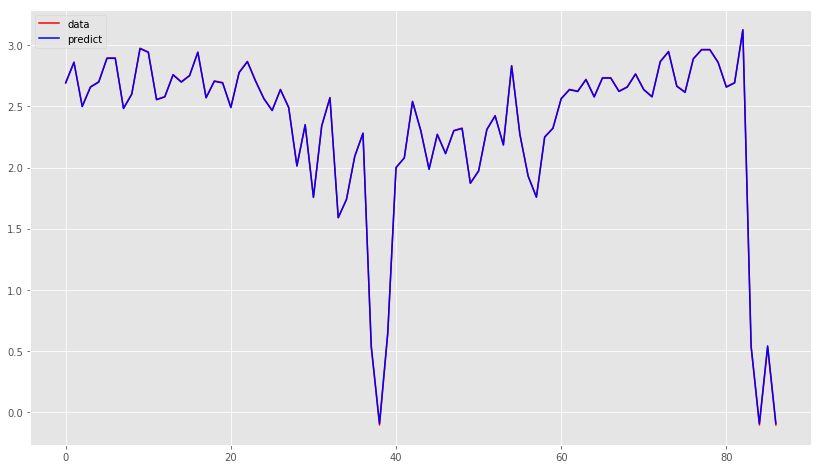

x_scale:  (2, 87, 3, 1)


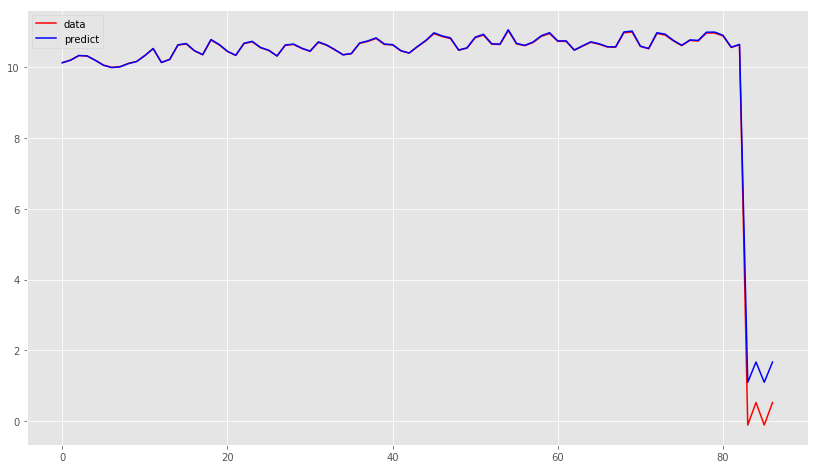

87/87 [==============================] - 0s 64us/step
model evaluate mse: [4.736873391030849, 0.016392688491734964, 4.720480792823879, 0.016392688491734964, 4.720480617435499]


In [28]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

# 精度の評価

In [29]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.005154639870738128
rmse: 0.15530880310193557
0.08023172148633685


# Task Wise Early Stopping

In [30]:
del model
gc.collect()
model = create_model_individual(input_dim, 
                     time_steps=time_steps,
                     latent_dim_list=[120, 150],
                     model_option='lstm',
                    )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 3, 120)       58560       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 3, 150)       91200       input_8[0][0]                    
__________________________________________________________________________________________________
dense_7 (D

## Task wise Early Stoppingの設定

In [31]:
from keras.callbacks import Callback
import numpy as np
import warnings

class TaskWiseEarlyStopping(Callback):


    def __init__(self,
                 monitor='val_loss',
                 min_delta=0,
                 patience=0,
                 verbose=0,
                 mode='auto',
                 baseline=None,
                 restore_best_weights=False):
        super(TaskWiseEarlyStopping, self).__init__()

        self.monitor = monitor
        self.baseline = baseline
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.stop_monitor = None

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.' % mode,
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                self.stop_monitor = self.monitor
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of '
                              'the best epoch')
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping %s' % (self.stopped_epoch + 1, self.monitor))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
        return monitor_value

## どのロスをチェックするか選択

In [32]:
monitor_list = []
for layer in model.layers:
    if 'dense' in layer.name:
        monitor_list.append('val_' + layer.name + '_loss')

callbacks_list = []

for monitor in monitor_list:
    callbacks_list.append(TaskWiseEarlyStopping(monitor=monitor, patience=30, verbose=1))

In [33]:
log_dir = 'model_task_wise'
p = Path(log_dir)
p.mkdir(parents=True, exist_ok=True)
tensorboard = TensorBoard(log_dir=log_dir,
                          write_graph=True,
                          embeddings_freq=0,
                          )

callbacks_list.append(tensorboard)

## Task Wise Early Stoppingを適用

In [34]:
with timer('train model individual task_wise'):
    model.fit(x, x, validation_split=0.1,
              epochs=1000, callbacks=callbacks_list)

Train on 135 samples, validate on 15 samples
Epoch 1/1000
135/135 [==============================] - 1s 7ms/step - loss: 0.5791 - dense_7_loss: 0.0705 - dense_8_loss: 0.5086 - dense_7_mean_squared_error: 0.0705 - dense_8_mean_squared_error: 0.5086 - val_loss: 0.4700 - val_dense_7_loss: 0.0389 - val_dense_8_loss: 0.4311 - val_dense_7_mean_squared_error: 0.0389 - val_dense_8_mean_squared_error: 0.4311
Epoch 2/1000
135/135 [==============================] - 0s 208us/step - loss: 0.4145 - dense_7_loss: 0.0510 - dense_8_loss: 0.3635 - dense_7_mean_squared_error: 0.0510 - dense_8_mean_squared_error: 0.3635 - val_loss: 0.3323 - val_dense_7_loss: 0.0287 - val_dense_8_loss: 0.3036 - val_dense_7_mean_squared_error: 0.0287 - val_dense_8_mean_squared_error: 0.3036
Epoch 3/1000
135/135 [==============================] - 0s 224us/step - loss: 0.2814 - dense_7_loss: 0.0361 - dense_8_loss: 0.2453 - dense_7_mean_squared_error: 0.0361 - dense_8_mean_squared_error: 0.2453 - val_loss: 0.2327 - val_dense_7

Epoch 24/1000
135/135 [==============================] - 0s 227us/step - loss: 0.0197 - dense_7_loss: 0.0087 - dense_8_loss: 0.0111 - dense_7_mean_squared_error: 0.0087 - dense_8_mean_squared_error: 0.0111 - val_loss: 0.0525 - val_dense_7_loss: 0.0127 - val_dense_8_loss: 0.0398 - val_dense_7_mean_squared_error: 0.0127 - val_dense_8_mean_squared_error: 0.0398
Epoch 25/1000
135/135 [==============================] - 0s 260us/step - loss: 0.0174 - dense_7_loss: 0.0081 - dense_8_loss: 0.0093 - dense_7_mean_squared_error: 0.0081 - dense_8_mean_squared_error: 0.0093 - val_loss: 0.0506 - val_dense_7_loss: 0.0123 - val_dense_8_loss: 0.0383 - val_dense_7_mean_squared_error: 0.0123 - val_dense_8_mean_squared_error: 0.0383
Epoch 26/1000
135/135 [==============================] - 0s 279us/step - loss: 0.0153 - dense_7_loss: 0.0075 - dense_8_loss: 0.0077 - dense_7_mean_squared_error: 0.0075 - dense_8_mean_squared_error: 0.0077 - val_loss: 0.0488 - val_dense_7_loss: 0.0118 - val_dense_8_loss: 0.0370

Epoch 47/1000
135/135 [==============================] - 0s 200us/step - loss: 0.0030 - dense_7_loss: 0.0016 - dense_8_loss: 0.0013 - dense_7_mean_squared_error: 0.0016 - dense_8_mean_squared_error: 0.0013 - val_loss: 0.0352 - val_dense_7_loss: 0.0054 - val_dense_8_loss: 0.0298 - val_dense_7_mean_squared_error: 0.0054 - val_dense_8_mean_squared_error: 0.0298
Epoch 48/1000
135/135 [==============================] - 0s 208us/step - loss: 0.0029 - dense_7_loss: 0.0016 - dense_8_loss: 0.0013 - dense_7_mean_squared_error: 0.0016 - dense_8_mean_squared_error: 0.0013 - val_loss: 0.0347 - val_dense_7_loss: 0.0050 - val_dense_8_loss: 0.0297 - val_dense_7_mean_squared_error: 0.0050 - val_dense_8_mean_squared_error: 0.0297
Epoch 49/1000
135/135 [==============================] - 0s 199us/step - loss: 0.0028 - dense_7_loss: 0.0015 - dense_8_loss: 0.0013 - dense_7_mean_squared_error: 0.0015 - dense_8_mean_squared_error: 0.0013 - val_loss: 0.0341 - val_dense_7_loss: 0.0047 - val_dense_8_loss: 0.0295

135/135 [==============================] - 0s 238us/step - loss: 0.0016 - dense_7_loss: 4.4191e-04 - dense_8_loss: 0.0012 - dense_7_mean_squared_error: 4.4191e-04 - dense_8_mean_squared_error: 0.0012 - val_loss: 0.0275 - val_dense_7_loss: 0.0014 - val_dense_8_loss: 0.0261 - val_dense_7_mean_squared_error: 0.0014 - val_dense_8_mean_squared_error: 0.0261
Epoch 70/1000
135/135 [==============================] - 0s 268us/step - loss: 0.0016 - dense_7_loss: 4.0972e-04 - dense_8_loss: 0.0012 - dense_7_mean_squared_error: 4.0972e-04 - dense_8_mean_squared_error: 0.0012 - val_loss: 0.0272 - val_dense_7_loss: 0.0013 - val_dense_8_loss: 0.0259 - val_dense_7_mean_squared_error: 0.0013 - val_dense_8_mean_squared_error: 0.0259
Epoch 71/1000
135/135 [==============================] - 0s 264us/step - loss: 0.0015 - dense_7_loss: 3.7895e-04 - dense_8_loss: 0.0012 - dense_7_mean_squared_error: 3.7895e-04 - dense_8_mean_squared_error: 0.0012 - val_loss: 0.0269 - val_dense_7_loss: 0.0012 - val_dense_8_lo

Epoch 91/1000
135/135 [==============================] - 0s 227us/step - loss: 0.0011 - dense_7_loss: 6.2799e-05 - dense_8_loss: 0.0010 - dense_7_mean_squared_error: 6.2799e-05 - dense_8_mean_squared_error: 0.0010 - val_loss: 0.0224 - val_dense_7_loss: 1.5065e-04 - val_dense_8_loss: 0.0223 - val_dense_7_mean_squared_error: 1.5065e-04 - val_dense_8_mean_squared_error: 0.0223
Epoch 92/1000
135/135 [==============================] - 0s 222us/step - loss: 0.0011 - dense_7_loss: 5.7284e-05 - dense_8_loss: 0.0010 - dense_7_mean_squared_error: 5.7284e-05 - dense_8_mean_squared_error: 0.0010 - val_loss: 0.0223 - val_dense_7_loss: 1.3965e-04 - val_dense_8_loss: 0.0221 - val_dense_7_mean_squared_error: 1.3965e-04 - val_dense_8_mean_squared_error: 0.0221
Epoch 93/1000
135/135 [==============================] - 0s 207us/step - loss: 0.0010 - dense_7_loss: 5.2219e-05 - dense_8_loss: 9.9771e-04 - dense_7_mean_squared_error: 5.2219e-05 - dense_8_mean_squared_error: 9.9771e-04 - val_loss: 0.0221 - val

135/135 [==============================] - 0s 228us/step - loss: 8.8818e-04 - dense_7_loss: 1.0835e-05 - dense_8_loss: 8.7734e-04 - dense_7_mean_squared_error: 1.0835e-05 - dense_8_mean_squared_error: 8.7734e-04 - val_loss: 0.0189 - val_dense_7_loss: 2.0291e-05 - val_dense_8_loss: 0.0189 - val_dense_7_mean_squared_error: 2.0291e-05 - val_dense_8_mean_squared_error: 0.0189
Epoch 113/1000
135/135 [==============================] - 0s 231us/step - loss: 8.6389e-04 - dense_7_loss: 1.0148e-05 - dense_8_loss: 8.5374e-04 - dense_7_mean_squared_error: 1.0148e-05 - dense_8_mean_squared_error: 8.5374e-04 - val_loss: 0.0188 - val_dense_7_loss: 1.8479e-05 - val_dense_8_loss: 0.0188 - val_dense_7_mean_squared_error: 1.8479e-05 - val_dense_8_mean_squared_error: 0.0188
Epoch 114/1000
135/135 [==============================] - 0s 242us/step - loss: 8.4782e-04 - dense_7_loss: 9.5630e-06 - dense_8_loss: 8.3826e-04 - dense_7_mean_squared_error: 9.5630e-06 - dense_8_mean_squared_error: 8.3826e-04 - val_lo

135/135 [==============================] - 0s 242us/step - loss: 7.3285e-04 - dense_7_loss: 5.5008e-06 - dense_8_loss: 7.2735e-04 - dense_7_mean_squared_error: 5.5008e-06 - dense_8_mean_squared_error: 7.2735e-04 - val_loss: 0.0162 - val_dense_7_loss: 8.3531e-06 - val_dense_8_loss: 0.0161 - val_dense_7_mean_squared_error: 8.3531e-06 - val_dense_8_mean_squared_error: 0.0161
Epoch 134/1000
135/135 [==============================] - 0s 235us/step - loss: 7.2993e-04 - dense_7_loss: 5.4750e-06 - dense_8_loss: 7.2446e-04 - dense_7_mean_squared_error: 5.4750e-06 - dense_8_mean_squared_error: 7.2446e-04 - val_loss: 0.0160 - val_dense_7_loss: 8.2535e-06 - val_dense_8_loss: 0.0160 - val_dense_7_mean_squared_error: 8.2535e-06 - val_dense_8_mean_squared_error: 0.0160
Epoch 135/1000
135/135 [==============================] - 0s 238us/step - loss: 7.2252e-04 - dense_7_loss: 5.4107e-06 - dense_8_loss: 7.1711e-04 - dense_7_mean_squared_error: 5.4107e-06 - dense_8_mean_squared_error: 7.1711e-04 - val_lo

135/135 [==============================] - 0s 227us/step - loss: 6.3151e-04 - dense_7_loss: 4.8588e-06 - dense_8_loss: 6.2665e-04 - dense_7_mean_squared_error: 4.8588e-06 - dense_8_mean_squared_error: 6.2665e-04 - val_loss: 0.0141 - val_dense_7_loss: 7.2244e-06 - val_dense_8_loss: 0.0141 - val_dense_7_mean_squared_error: 7.2244e-06 - val_dense_8_mean_squared_error: 0.0141
Epoch 155/1000
135/135 [==============================] - 0s 231us/step - loss: 6.2811e-04 - dense_7_loss: 4.8475e-06 - dense_8_loss: 6.2326e-04 - dense_7_mean_squared_error: 4.8475e-06 - dense_8_mean_squared_error: 6.2326e-04 - val_loss: 0.0140 - val_dense_7_loss: 7.2023e-06 - val_dense_8_loss: 0.0140 - val_dense_7_mean_squared_error: 7.2023e-06 - val_dense_8_mean_squared_error: 0.0140
Epoch 156/1000
135/135 [==============================] - 0s 236us/step - loss: 6.2327e-04 - dense_7_loss: 4.8219e-06 - dense_8_loss: 6.1845e-04 - dense_7_mean_squared_error: 4.8219e-06 - dense_8_mean_squared_error: 6.1845e-04 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 5.5116e-04 - dense_7_loss: 4.5008e-06 - dense_8_loss: 5.4665e-04 - dense_7_mean_squared_error: 4.5008e-06 - dense_8_mean_squared_error: 5.4665e-04 - val_loss: 0.0126 - val_dense_7_loss: 6.2435e-06 - val_dense_8_loss: 0.0126 - val_dense_7_mean_squared_error: 6.2435e-06 - val_dense_8_mean_squared_error: 0.0126
Epoch 176/1000
135/135 [==============================] - 0s 235us/step - loss: 5.5391e-04 - dense_7_loss: 4.4615e-06 - dense_8_loss: 5.4945e-04 - dense_7_mean_squared_error: 4.4615e-06 - dense_8_mean_squared_error: 5.4945e-04 - val_loss: 0.0125 - val_dense_7_loss: 5.9378e-06 - val_dense_8_loss: 0.0125 - val_dense_7_mean_squared_error: 5.9378e-06 - val_dense_8_mean_squared_error: 0.0125
Epoch 177/1000
135/135 [==============================] - 0s 240us/step - loss: 5.4611e-04 - dense_7_loss: 4.4580e-06 - dense_8_loss: 5.4166e-04 - dense_7_mean_squared_error: 4.4580e-06 - dense_8_mean_squared_error: 5.4166e-04 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 4.7470e-04 - dense_7_loss: 4.1366e-06 - dense_8_loss: 4.7056e-04 - dense_7_mean_squared_error: 4.1366e-06 - dense_8_mean_squared_error: 4.7056e-04 - val_loss: 0.0114 - val_dense_7_loss: 5.9664e-06 - val_dense_8_loss: 0.0114 - val_dense_7_mean_squared_error: 5.9664e-06 - val_dense_8_mean_squared_error: 0.0114
Epoch 197/1000
135/135 [==============================] - 0s 245us/step - loss: 4.7096e-04 - dense_7_loss: 4.0972e-06 - dense_8_loss: 4.6686e-04 - dense_7_mean_squared_error: 4.0972e-06 - dense_8_mean_squared_error: 4.6686e-04 - val_loss: 0.0113 - val_dense_7_loss: 5.7358e-06 - val_dense_8_loss: 0.0113 - val_dense_7_mean_squared_error: 5.7358e-06 - val_dense_8_mean_squared_error: 0.0113
Epoch 198/1000
135/135 [==============================] - 0s 241us/step - loss: 4.6775e-04 - dense_7_loss: 4.0617e-06 - dense_8_loss: 4.6369e-04 - dense_7_mean_squared_error: 4.0617e-06 - dense_8_mean_squared_error: 4.6369e-04 - val_lo

135/135 [==============================] - 0s 218us/step - loss: 4.1102e-04 - dense_7_loss: 3.7858e-06 - dense_8_loss: 4.0723e-04 - dense_7_mean_squared_error: 3.7858e-06 - dense_8_mean_squared_error: 4.0723e-04 - val_loss: 0.0104 - val_dense_7_loss: 5.5787e-06 - val_dense_8_loss: 0.0104 - val_dense_7_mean_squared_error: 5.5787e-06 - val_dense_8_mean_squared_error: 0.0104
Epoch 218/1000
135/135 [==============================] - 0s 199us/step - loss: 4.1696e-04 - dense_7_loss: 3.7812e-06 - dense_8_loss: 4.1317e-04 - dense_7_mean_squared_error: 3.7812e-06 - dense_8_mean_squared_error: 4.1317e-04 - val_loss: 0.0103 - val_dense_7_loss: 5.4113e-06 - val_dense_8_loss: 0.0103 - val_dense_7_mean_squared_error: 5.4113e-06 - val_dense_8_mean_squared_error: 0.0103
Epoch 219/1000
135/135 [==============================] - 0s 198us/step - loss: 4.0429e-04 - dense_7_loss: 3.7608e-06 - dense_8_loss: 4.0053e-04 - dense_7_mean_squared_error: 3.7608e-06 - dense_8_mean_squared_error: 4.0053e-04 - val_lo

135/135 [==============================] - 0s 252us/step - loss: 3.4048e-04 - dense_7_loss: 3.5704e-06 - dense_8_loss: 3.3691e-04 - dense_7_mean_squared_error: 3.5704e-06 - dense_8_mean_squared_error: 3.3691e-04 - val_loss: 0.0095 - val_dense_7_loss: 4.9574e-06 - val_dense_8_loss: 0.0095 - val_dense_7_mean_squared_error: 4.9574e-06 - val_dense_8_mean_squared_error: 0.0095
Epoch 239/1000
135/135 [==============================] - 0s 244us/step - loss: 3.3791e-04 - dense_7_loss: 3.5486e-06 - dense_8_loss: 3.3436e-04 - dense_7_mean_squared_error: 3.5486e-06 - dense_8_mean_squared_error: 3.3436e-04 - val_loss: 0.0094 - val_dense_7_loss: 4.8665e-06 - val_dense_8_loss: 0.0094 - val_dense_7_mean_squared_error: 4.8665e-06 - val_dense_8_mean_squared_error: 0.0094
Epoch 240/1000
135/135 [==============================] - 0s 237us/step - loss: 3.3425e-04 - dense_7_loss: 3.4731e-06 - dense_8_loss: 3.3077e-04 - dense_7_mean_squared_error: 3.4731e-06 - dense_8_mean_squared_error: 3.3077e-04 - val_lo

135/135 [==============================] - 0s 203us/step - loss: 2.8246e-04 - dense_7_loss: 3.2698e-06 - dense_8_loss: 2.7919e-04 - dense_7_mean_squared_error: 3.2698e-06 - dense_8_mean_squared_error: 2.7919e-04 - val_loss: 0.0085 - val_dense_7_loss: 4.3966e-06 - val_dense_8_loss: 0.0085 - val_dense_7_mean_squared_error: 4.3966e-06 - val_dense_8_mean_squared_error: 0.0085
Epoch 260/1000
135/135 [==============================] - 0s 204us/step - loss: 2.8187e-04 - dense_7_loss: 3.1667e-06 - dense_8_loss: 2.7870e-04 - dense_7_mean_squared_error: 3.1667e-06 - dense_8_mean_squared_error: 2.7870e-04 - val_loss: 0.0085 - val_dense_7_loss: 4.5735e-06 - val_dense_8_loss: 0.0085 - val_dense_7_mean_squared_error: 4.5735e-06 - val_dense_8_mean_squared_error: 0.0085
Epoch 261/1000
135/135 [==============================] - 0s 217us/step - loss: 2.7649e-04 - dense_7_loss: 3.1685e-06 - dense_8_loss: 2.7332e-04 - dense_7_mean_squared_error: 3.1685e-06 - dense_8_mean_squared_error: 2.7332e-04 - val_lo

135/135 [==============================] - 0s 220us/step - loss: 2.3023e-04 - dense_7_loss: 2.9345e-06 - dense_8_loss: 2.2729e-04 - dense_7_mean_squared_error: 2.9345e-06 - dense_8_mean_squared_error: 2.2729e-04 - val_loss: 0.0077 - val_dense_7_loss: 3.9965e-06 - val_dense_8_loss: 0.0077 - val_dense_7_mean_squared_error: 3.9965e-06 - val_dense_8_mean_squared_error: 0.0077
Epoch 281/1000
135/135 [==============================] - 0s 228us/step - loss: 2.2930e-04 - dense_7_loss: 2.9298e-06 - dense_8_loss: 2.2637e-04 - dense_7_mean_squared_error: 2.9298e-06 - dense_8_mean_squared_error: 2.2637e-04 - val_loss: 0.0077 - val_dense_7_loss: 4.0976e-06 - val_dense_8_loss: 0.0077 - val_dense_7_mean_squared_error: 4.0976e-06 - val_dense_8_mean_squared_error: 0.0077
Epoch 282/1000
135/135 [==============================] - 0s 211us/step - loss: 2.2439e-04 - dense_7_loss: 2.9550e-06 - dense_8_loss: 2.2143e-04 - dense_7_mean_squared_error: 2.9550e-06 - dense_8_mean_squared_error: 2.2143e-04 - val_lo

135/135 [==============================] - 0s 233us/step - loss: 1.8524e-04 - dense_7_loss: 2.6817e-06 - dense_8_loss: 1.8255e-04 - dense_7_mean_squared_error: 2.6817e-06 - dense_8_mean_squared_error: 1.8255e-04 - val_loss: 0.0069 - val_dense_7_loss: 4.0485e-06 - val_dense_8_loss: 0.0069 - val_dense_7_mean_squared_error: 4.0485e-06 - val_dense_8_mean_squared_error: 0.0069
Epoch 302/1000
135/135 [==============================] - 0s 234us/step - loss: 1.8299e-04 - dense_7_loss: 2.6799e-06 - dense_8_loss: 1.8031e-04 - dense_7_mean_squared_error: 2.6799e-06 - dense_8_mean_squared_error: 1.8031e-04 - val_loss: 0.0068 - val_dense_7_loss: 4.0049e-06 - val_dense_8_loss: 0.0068 - val_dense_7_mean_squared_error: 4.0049e-06 - val_dense_8_mean_squared_error: 0.0068
Epoch 303/1000
135/135 [==============================] - 0s 228us/step - loss: 1.8130e-04 - dense_7_loss: 2.6483e-06 - dense_8_loss: 1.7865e-04 - dense_7_mean_squared_error: 2.6483e-06 - dense_8_mean_squared_error: 1.7865e-04 - val_lo

135/135 [==============================] - 0s 214us/step - loss: 1.4952e-04 - dense_7_loss: 2.4763e-06 - dense_8_loss: 1.4704e-04 - dense_7_mean_squared_error: 2.4763e-06 - dense_8_mean_squared_error: 1.4704e-04 - val_loss: 0.0061 - val_dense_7_loss: 3.6745e-06 - val_dense_8_loss: 0.0061 - val_dense_7_mean_squared_error: 3.6745e-06 - val_dense_8_mean_squared_error: 0.0061
Epoch 323/1000
135/135 [==============================] - 0s 217us/step - loss: 1.4838e-04 - dense_7_loss: 2.4410e-06 - dense_8_loss: 1.4594e-04 - dense_7_mean_squared_error: 2.4410e-06 - dense_8_mean_squared_error: 1.4594e-04 - val_loss: 0.0060 - val_dense_7_loss: 3.5930e-06 - val_dense_8_loss: 0.0060 - val_dense_7_mean_squared_error: 3.5930e-06 - val_dense_8_mean_squared_error: 0.0060
Epoch 324/1000
135/135 [==============================] - 0s 217us/step - loss: 1.5368e-04 - dense_7_loss: 2.4858e-06 - dense_8_loss: 1.5120e-04 - dense_7_mean_squared_error: 2.4858e-06 - dense_8_mean_squared_error: 1.5120e-04 - val_lo

135/135 [==============================] - 0s 226us/step - loss: 1.2573e-04 - dense_7_loss: 2.2726e-06 - dense_8_loss: 1.2346e-04 - dense_7_mean_squared_error: 2.2726e-06 - dense_8_mean_squared_error: 1.2346e-04 - val_loss: 0.0054 - val_dense_7_loss: 3.3890e-06 - val_dense_8_loss: 0.0054 - val_dense_7_mean_squared_error: 3.3890e-06 - val_dense_8_mean_squared_error: 0.0054
Epoch 344/1000
135/135 [==============================] - 0s 239us/step - loss: 1.1922e-04 - dense_7_loss: 2.2401e-06 - dense_8_loss: 1.1698e-04 - dense_7_mean_squared_error: 2.2401e-06 - dense_8_mean_squared_error: 1.1698e-04 - val_loss: 0.0053 - val_dense_7_loss: 3.2351e-06 - val_dense_8_loss: 0.0053 - val_dense_7_mean_squared_error: 3.2351e-06 - val_dense_8_mean_squared_error: 0.0053
Epoch 345/1000
135/135 [==============================] - 0s 261us/step - loss: 1.1960e-04 - dense_7_loss: 2.2286e-06 - dense_8_loss: 1.1737e-04 - dense_7_mean_squared_error: 2.2286e-06 - dense_8_mean_squared_error: 1.1737e-04 - val_lo

135/135 [==============================] - 0s 230us/step - loss: 9.8100e-05 - dense_7_loss: 2.1095e-06 - dense_8_loss: 9.5990e-05 - dense_7_mean_squared_error: 2.1095e-06 - dense_8_mean_squared_error: 9.5990e-05 - val_loss: 0.0047 - val_dense_7_loss: 3.2459e-06 - val_dense_8_loss: 0.0047 - val_dense_7_mean_squared_error: 3.2459e-06 - val_dense_8_mean_squared_error: 0.0047
Epoch 365/1000
135/135 [==============================] - 0s 237us/step - loss: 9.7321e-05 - dense_7_loss: 2.0604e-06 - dense_8_loss: 9.5260e-05 - dense_7_mean_squared_error: 2.0604e-06 - dense_8_mean_squared_error: 9.5260e-05 - val_loss: 0.0047 - val_dense_7_loss: 3.2136e-06 - val_dense_8_loss: 0.0047 - val_dense_7_mean_squared_error: 3.2136e-06 - val_dense_8_mean_squared_error: 0.0047
Epoch 366/1000
135/135 [==============================] - 0s 235us/step - loss: 9.6654e-05 - dense_7_loss: 2.0997e-06 - dense_8_loss: 9.4555e-05 - dense_7_mean_squared_error: 2.0997e-06 - dense_8_mean_squared_error: 9.4555e-05 - val_lo

Epoch 385/1000
135/135 [==============================] - 0s 219us/step - loss: 7.9469e-05 - dense_7_loss: 1.8877e-06 - dense_8_loss: 7.7581e-05 - dense_7_mean_squared_error: 1.8877e-06 - dense_8_mean_squared_error: 7.7581e-05 - val_loss: 0.0042 - val_dense_7_loss: 2.8796e-06 - val_dense_8_loss: 0.0042 - val_dense_7_mean_squared_error: 2.8796e-06 - val_dense_8_mean_squared_error: 0.0042
Epoch 386/1000
135/135 [==============================] - 0s 238us/step - loss: 7.9935e-05 - dense_7_loss: 1.9003e-06 - dense_8_loss: 7.8035e-05 - dense_7_mean_squared_error: 1.9003e-06 - dense_8_mean_squared_error: 7.8035e-05 - val_loss: 0.0042 - val_dense_7_loss: 2.8971e-06 - val_dense_8_loss: 0.0042 - val_dense_7_mean_squared_error: 2.8971e-06 - val_dense_8_mean_squared_error: 0.0042
Epoch 387/1000
135/135 [==============================] - 0s 232us/step - loss: 7.8836e-05 - dense_7_loss: 1.9072e-06 - dense_8_loss: 7.6929e-05 - dense_7_mean_squared_error: 1.9072e-06 - dense_8_mean_squared_error: 7.69

135/135 [==============================] - 0s 226us/step - loss: 6.6486e-05 - dense_7_loss: 1.7599e-06 - dense_8_loss: 6.4726e-05 - dense_7_mean_squared_error: 1.7599e-06 - dense_8_mean_squared_error: 6.4726e-05 - val_loss: 0.0038 - val_dense_7_loss: 2.6109e-06 - val_dense_8_loss: 0.0038 - val_dense_7_mean_squared_error: 2.6109e-06 - val_dense_8_mean_squared_error: 0.0038
Epoch 407/1000
135/135 [==============================] - 0s 229us/step - loss: 6.8407e-05 - dense_7_loss: 1.7230e-06 - dense_8_loss: 6.6684e-05 - dense_7_mean_squared_error: 1.7230e-06 - dense_8_mean_squared_error: 6.6684e-05 - val_loss: 0.0037 - val_dense_7_loss: 2.5920e-06 - val_dense_8_loss: 0.0037 - val_dense_7_mean_squared_error: 2.5920e-06 - val_dense_8_mean_squared_error: 0.0037
Epoch 408/1000
135/135 [==============================] - 0s 222us/step - loss: 6.5710e-05 - dense_7_loss: 1.7004e-06 - dense_8_loss: 6.4009e-05 - dense_7_mean_squared_error: 1.7004e-06 - dense_8_mean_squared_error: 6.4009e-05 - val_lo

135/135 [==============================] - 0s 224us/step - loss: 5.2501e-05 - dense_7_loss: 1.5919e-06 - dense_8_loss: 5.0910e-05 - dense_7_mean_squared_error: 1.5919e-06 - dense_8_mean_squared_error: 5.0910e-05 - val_loss: 0.0033 - val_dense_7_loss: 2.2553e-06 - val_dense_8_loss: 0.0033 - val_dense_7_mean_squared_error: 2.2553e-06 - val_dense_8_mean_squared_error: 0.0033
Epoch 428/1000
135/135 [==============================] - 0s 208us/step - loss: 5.2183e-05 - dense_7_loss: 1.5795e-06 - dense_8_loss: 5.0603e-05 - dense_7_mean_squared_error: 1.5795e-06 - dense_8_mean_squared_error: 5.0603e-05 - val_loss: 0.0033 - val_dense_7_loss: 2.2629e-06 - val_dense_8_loss: 0.0033 - val_dense_7_mean_squared_error: 2.2629e-06 - val_dense_8_mean_squared_error: 0.0033
Epoch 429/1000
135/135 [==============================] - 0s 200us/step - loss: 5.1929e-05 - dense_7_loss: 1.5816e-06 - dense_8_loss: 5.0348e-05 - dense_7_mean_squared_error: 1.5816e-06 - dense_8_mean_squared_error: 5.0348e-05 - val_lo

135/135 [==============================] - 0s 247us/step - loss: 4.3040e-05 - dense_7_loss: 1.5069e-06 - dense_8_loss: 4.1533e-05 - dense_7_mean_squared_error: 1.5069e-06 - dense_8_mean_squared_error: 4.1533e-05 - val_loss: 0.0030 - val_dense_7_loss: 2.3045e-06 - val_dense_8_loss: 0.0030 - val_dense_7_mean_squared_error: 2.3045e-06 - val_dense_8_mean_squared_error: 0.0030
Epoch 449/1000
135/135 [==============================] - 0s 246us/step - loss: 4.1552e-05 - dense_7_loss: 1.4876e-06 - dense_8_loss: 4.0064e-05 - dense_7_mean_squared_error: 1.4876e-06 - dense_8_mean_squared_error: 4.0064e-05 - val_loss: 0.0030 - val_dense_7_loss: 2.2862e-06 - val_dense_8_loss: 0.0030 - val_dense_7_mean_squared_error: 2.2862e-06 - val_dense_8_mean_squared_error: 0.0030
Epoch 450/1000
135/135 [==============================] - 0s 241us/step - loss: 4.1090e-05 - dense_7_loss: 1.4399e-06 - dense_8_loss: 3.9650e-05 - dense_7_mean_squared_error: 1.4399e-06 - dense_8_mean_squared_error: 3.9650e-05 - val_lo

135/135 [==============================] - 0s 264us/step - loss: 3.2856e-05 - dense_7_loss: 1.3199e-06 - dense_8_loss: 3.1536e-05 - dense_7_mean_squared_error: 1.3199e-06 - dense_8_mean_squared_error: 3.1536e-05 - val_loss: 0.0027 - val_dense_7_loss: 2.0571e-06 - val_dense_8_loss: 0.0027 - val_dense_7_mean_squared_error: 2.0571e-06 - val_dense_8_mean_squared_error: 0.0027
Epoch 470/1000
135/135 [==============================] - 0s 248us/step - loss: 3.2358e-05 - dense_7_loss: 1.3124e-06 - dense_8_loss: 3.1046e-05 - dense_7_mean_squared_error: 1.3124e-06 - dense_8_mean_squared_error: 3.1046e-05 - val_loss: 0.0027 - val_dense_7_loss: 2.1134e-06 - val_dense_8_loss: 0.0027 - val_dense_7_mean_squared_error: 2.1134e-06 - val_dense_8_mean_squared_error: 0.0027
Epoch 471/1000
135/135 [==============================] - 0s 236us/step - loss: 3.1919e-05 - dense_7_loss: 1.3170e-06 - dense_8_loss: 3.0602e-05 - dense_7_mean_squared_error: 1.3170e-06 - dense_8_mean_squared_error: 3.0602e-05 - val_lo

135/135 [==============================] - 0s 260us/step - loss: 2.6734e-05 - dense_7_loss: 1.1926e-06 - dense_8_loss: 2.5542e-05 - dense_7_mean_squared_error: 1.1926e-06 - dense_8_mean_squared_error: 2.5542e-05 - val_loss: 0.0024 - val_dense_7_loss: 1.9798e-06 - val_dense_8_loss: 0.0024 - val_dense_7_mean_squared_error: 1.9798e-06 - val_dense_8_mean_squared_error: 0.0024
Epoch 491/1000
135/135 [==============================] - 0s 256us/step - loss: 2.6218e-05 - dense_7_loss: 1.2177e-06 - dense_8_loss: 2.5000e-05 - dense_7_mean_squared_error: 1.2177e-06 - dense_8_mean_squared_error: 2.5000e-05 - val_loss: 0.0024 - val_dense_7_loss: 1.8525e-06 - val_dense_8_loss: 0.0024 - val_dense_7_mean_squared_error: 1.8525e-06 - val_dense_8_mean_squared_error: 0.0024
Epoch 492/1000
135/135 [==============================] - 0s 267us/step - loss: 2.5310e-05 - dense_7_loss: 1.2055e-06 - dense_8_loss: 2.4104e-05 - dense_7_mean_squared_error: 1.2055e-06 - dense_8_mean_squared_error: 2.4104e-05 - val_lo

135/135 [==============================] - 0s 251us/step - loss: 2.0265e-05 - dense_7_loss: 1.1046e-06 - dense_8_loss: 1.9160e-05 - dense_7_mean_squared_error: 1.1046e-06 - dense_8_mean_squared_error: 1.9160e-05 - val_loss: 0.0022 - val_dense_7_loss: 1.6400e-06 - val_dense_8_loss: 0.0022 - val_dense_7_mean_squared_error: 1.6400e-06 - val_dense_8_mean_squared_error: 0.0022
Epoch 512/1000
135/135 [==============================] - 0s 255us/step - loss: 1.9861e-05 - dense_7_loss: 1.1242e-06 - dense_8_loss: 1.8737e-05 - dense_7_mean_squared_error: 1.1242e-06 - dense_8_mean_squared_error: 1.8737e-05 - val_loss: 0.0021 - val_dense_7_loss: 1.6240e-06 - val_dense_8_loss: 0.0021 - val_dense_7_mean_squared_error: 1.6240e-06 - val_dense_8_mean_squared_error: 0.0021
Epoch 513/1000
135/135 [==============================] - 0s 248us/step - loss: 1.9302e-05 - dense_7_loss: 1.1191e-06 - dense_8_loss: 1.8183e-05 - dense_7_mean_squared_error: 1.1191e-06 - dense_8_mean_squared_error: 1.8183e-05 - val_lo

135/135 [==============================] - 0s 207us/step - loss: 1.5265e-05 - dense_7_loss: 1.0250e-06 - dense_8_loss: 1.4240e-05 - dense_7_mean_squared_error: 1.0250e-06 - dense_8_mean_squared_error: 1.4240e-05 - val_loss: 0.0019 - val_dense_7_loss: 1.6700e-06 - val_dense_8_loss: 0.0019 - val_dense_7_mean_squared_error: 1.6700e-06 - val_dense_8_mean_squared_error: 0.0019
Epoch 533/1000
135/135 [==============================] - 0s 214us/step - loss: 1.5234e-05 - dense_7_loss: 1.0169e-06 - dense_8_loss: 1.4217e-05 - dense_7_mean_squared_error: 1.0169e-06 - dense_8_mean_squared_error: 1.4217e-05 - val_loss: 0.0019 - val_dense_7_loss: 1.7486e-06 - val_dense_8_loss: 0.0019 - val_dense_7_mean_squared_error: 1.7486e-06 - val_dense_8_mean_squared_error: 0.0019
Epoch 534/1000
135/135 [==============================] - 0s 210us/step - loss: 1.4919e-05 - dense_7_loss: 1.0001e-06 - dense_8_loss: 1.3919e-05 - dense_7_mean_squared_error: 1.0001e-06 - dense_8_mean_squared_error: 1.3919e-05 - val_lo

135/135 [==============================] - 0s 302us/step - loss: 1.2388e-05 - dense_7_loss: 1.0509e-06 - dense_8_loss: 1.1337e-05 - dense_7_mean_squared_error: 1.0509e-06 - dense_8_mean_squared_error: 1.1337e-05 - val_loss: 0.0017 - val_dense_7_loss: 1.4896e-06 - val_dense_8_loss: 0.0017 - val_dense_7_mean_squared_error: 1.4896e-06 - val_dense_8_mean_squared_error: 0.0017
Epoch 554/1000
135/135 [==============================] - 0s 345us/step - loss: 1.1732e-05 - dense_7_loss: 9.2053e-07 - dense_8_loss: 1.0812e-05 - dense_7_mean_squared_error: 9.2053e-07 - dense_8_mean_squared_error: 1.0812e-05 - val_loss: 0.0017 - val_dense_7_loss: 1.4277e-06 - val_dense_8_loss: 0.0017 - val_dense_7_mean_squared_error: 1.4277e-06 - val_dense_8_mean_squared_error: 0.0017
Epoch 555/1000
135/135 [==============================] - 0s 267us/step - loss: 1.1628e-05 - dense_7_loss: 9.2143e-07 - dense_8_loss: 1.0706e-05 - dense_7_mean_squared_error: 9.2143e-07 - dense_8_mean_squared_error: 1.0706e-05 - val_lo

135/135 [==============================] - 0s 306us/step - loss: 9.0037e-06 - dense_7_loss: 8.7191e-07 - dense_8_loss: 8.1318e-06 - dense_7_mean_squared_error: 8.7191e-07 - dense_8_mean_squared_error: 8.1318e-06 - val_loss: 0.0016 - val_dense_7_loss: 1.5047e-06 - val_dense_8_loss: 0.0016 - val_dense_7_mean_squared_error: 1.5047e-06 - val_dense_8_mean_squared_error: 0.0016
Epoch 575/1000
135/135 [==============================] - 0s 261us/step - loss: 8.8872e-06 - dense_7_loss: 8.3309e-07 - dense_8_loss: 8.0541e-06 - dense_7_mean_squared_error: 8.3309e-07 - dense_8_mean_squared_error: 8.0541e-06 - val_loss: 0.0016 - val_dense_7_loss: 1.4514e-06 - val_dense_8_loss: 0.0016 - val_dense_7_mean_squared_error: 1.4514e-06 - val_dense_8_mean_squared_error: 0.0016
Epoch 576/1000
135/135 [==============================] - 0s 302us/step - loss: 8.7300e-06 - dense_7_loss: 8.8472e-07 - dense_8_loss: 7.8453e-06 - dense_7_mean_squared_error: 8.8472e-07 - dense_8_mean_squared_error: 7.8453e-06 - val_lo

Epoch 595/1000
135/135 [==============================] - 0s 293us/step - loss: 6.9269e-06 - dense_7_loss: 7.7443e-07 - dense_8_loss: 6.1525e-06 - dense_7_mean_squared_error: 7.7443e-07 - dense_8_mean_squared_error: 6.1525e-06 - val_loss: 0.0014 - val_dense_7_loss: 1.3479e-06 - val_dense_8_loss: 0.0014 - val_dense_7_mean_squared_error: 1.3479e-06 - val_dense_8_mean_squared_error: 0.0014
Epoch 596/1000
135/135 [==============================] - 0s 253us/step - loss: 6.8125e-06 - dense_7_loss: 7.7069e-07 - dense_8_loss: 6.0418e-06 - dense_7_mean_squared_error: 7.7069e-07 - dense_8_mean_squared_error: 6.0418e-06 - val_loss: 0.0014 - val_dense_7_loss: 1.3528e-06 - val_dense_8_loss: 0.0014 - val_dense_7_mean_squared_error: 1.3528e-06 - val_dense_8_mean_squared_error: 0.0014
Epoch 597/1000
135/135 [==============================] - 0s 311us/step - loss: 6.7946e-06 - dense_7_loss: 7.6989e-07 - dense_8_loss: 6.0247e-06 - dense_7_mean_squared_error: 7.6989e-07 - dense_8_mean_squared_error: 6.02

Epoch 616/1000
135/135 [==============================] - 0s 246us/step - loss: 5.2631e-06 - dense_7_loss: 7.0922e-07 - dense_8_loss: 4.5539e-06 - dense_7_mean_squared_error: 7.0922e-07 - dense_8_mean_squared_error: 4.5539e-06 - val_loss: 0.0013 - val_dense_7_loss: 1.2224e-06 - val_dense_8_loss: 0.0013 - val_dense_7_mean_squared_error: 1.2224e-06 - val_dense_8_mean_squared_error: 0.0013
Epoch 617/1000
135/135 [==============================] - 0s 236us/step - loss: 5.3237e-06 - dense_7_loss: 6.9616e-07 - dense_8_loss: 4.6275e-06 - dense_7_mean_squared_error: 6.9616e-07 - dense_8_mean_squared_error: 4.6275e-06 - val_loss: 0.0013 - val_dense_7_loss: 1.1830e-06 - val_dense_8_loss: 0.0013 - val_dense_7_mean_squared_error: 1.1830e-06 - val_dense_8_mean_squared_error: 0.0013
Epoch 618/1000
135/135 [==============================] - 0s 241us/step - loss: 5.2057e-06 - dense_7_loss: 7.0407e-07 - dense_8_loss: 4.5016e-06 - dense_7_mean_squared_error: 7.0407e-07 - dense_8_mean_squared_error: 4.50

135/135 [==============================] - 0s 236us/step - loss: 4.1933e-06 - dense_7_loss: 6.7591e-07 - dense_8_loss: 3.5174e-06 - dense_7_mean_squared_error: 6.7591e-07 - dense_8_mean_squared_error: 3.5174e-06 - val_loss: 0.0012 - val_dense_7_loss: 1.0892e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 1.0892e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 638/1000
135/135 [==============================] - 0s 236us/step - loss: 4.2059e-06 - dense_7_loss: 6.5578e-07 - dense_8_loss: 3.5501e-06 - dense_7_mean_squared_error: 6.5578e-07 - dense_8_mean_squared_error: 3.5501e-06 - val_loss: 0.0012 - val_dense_7_loss: 1.1207e-06 - val_dense_8_loss: 0.0012 - val_dense_7_mean_squared_error: 1.1207e-06 - val_dense_8_mean_squared_error: 0.0012
Epoch 639/1000
135/135 [==============================] - 0s 211us/step - loss: 4.1698e-06 - dense_7_loss: 6.5206e-07 - dense_8_loss: 3.5178e-06 - dense_7_mean_squared_error: 6.5206e-07 - dense_8_mean_squared_error: 3.5178e-06 - val_lo

135/135 [==============================] - 0s 221us/step - loss: 3.3555e-06 - dense_7_loss: 6.0205e-07 - dense_8_loss: 2.7534e-06 - dense_7_mean_squared_error: 6.0205e-07 - dense_8_mean_squared_error: 2.7534e-06 - val_loss: 0.0011 - val_dense_7_loss: 1.0107e-06 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 1.0107e-06 - val_dense_8_mean_squared_error: 0.0011
Epoch 659/1000
135/135 [==============================] - 0s 217us/step - loss: 3.3793e-06 - dense_7_loss: 6.0505e-07 - dense_8_loss: 2.7742e-06 - dense_7_mean_squared_error: 6.0505e-07 - dense_8_mean_squared_error: 2.7742e-06 - val_loss: 0.0011 - val_dense_7_loss: 9.9470e-07 - val_dense_8_loss: 0.0011 - val_dense_7_mean_squared_error: 9.9470e-07 - val_dense_8_mean_squared_error: 0.0011
Epoch 660/1000
135/135 [==============================] - 0s 224us/step - loss: 3.8035e-06 - dense_7_loss: 5.9092e-07 - dense_8_loss: 3.2126e-06 - dense_7_mean_squared_error: 5.9092e-07 - dense_8_mean_squared_error: 3.2126e-06 - val_lo

135/135 [==============================] - 0s 234us/step - loss: 3.4571e-06 - dense_7_loss: 5.2794e-07 - dense_8_loss: 2.9292e-06 - dense_7_mean_squared_error: 5.2794e-07 - dense_8_mean_squared_error: 2.9292e-06 - val_loss: 0.0010 - val_dense_7_loss: 8.2545e-07 - val_dense_8_loss: 0.0010 - val_dense_7_mean_squared_error: 8.2545e-07 - val_dense_8_mean_squared_error: 0.0010
Epoch 680/1000
135/135 [==============================] - 0s 227us/step - loss: 3.5450e-06 - dense_7_loss: 5.2926e-07 - dense_8_loss: 3.0157e-06 - dense_7_mean_squared_error: 5.2926e-07 - dense_8_mean_squared_error: 3.0157e-06 - val_loss: 0.0010 - val_dense_7_loss: 8.8190e-07 - val_dense_8_loss: 0.0010 - val_dense_7_mean_squared_error: 8.8190e-07 - val_dense_8_mean_squared_error: 0.0010
Epoch 681/1000
135/135 [==============================] - 0s 226us/step - loss: 3.4832e-06 - dense_7_loss: 5.3108e-07 - dense_8_loss: 2.9521e-06 - dense_7_mean_squared_error: 5.3108e-07 - dense_8_mean_squared_error: 2.9521e-06 - val_lo

Epoch 700/1000
135/135 [==============================] - 0s 262us/step - loss: 2.6290e-06 - dense_7_loss: 4.8599e-07 - dense_8_loss: 2.1431e-06 - dense_7_mean_squared_error: 4.8599e-07 - dense_8_mean_squared_error: 2.1431e-06 - val_loss: 9.8427e-04 - val_dense_7_loss: 1.0477e-06 - val_dense_8_loss: 9.8322e-04 - val_dense_7_mean_squared_error: 1.0477e-06 - val_dense_8_mean_squared_error: 9.8322e-04
Epoch 701/1000
135/135 [==============================] - 0s 234us/step - loss: 2.5202e-06 - dense_7_loss: 4.9321e-07 - dense_8_loss: 2.0270e-06 - dense_7_mean_squared_error: 4.9321e-07 - dense_8_mean_squared_error: 2.0270e-06 - val_loss: 9.8107e-04 - val_dense_7_loss: 9.9701e-07 - val_dense_8_loss: 9.8007e-04 - val_dense_7_mean_squared_error: 9.9701e-07 - val_dense_8_mean_squared_error: 9.8007e-04
Epoch 702/1000
135/135 [==============================] - 0s 264us/step - loss: 2.7457e-06 - dense_7_loss: 4.8487e-07 - dense_8_loss: 2.2609e-06 - dense_7_mean_squared_error: 4.8487e-07 - dense_8_

135/135 [==============================] - 0s 226us/step - loss: 2.0327e-06 - dense_7_loss: 4.4378e-07 - dense_8_loss: 1.5889e-06 - dense_7_mean_squared_error: 4.4378e-07 - dense_8_mean_squared_error: 1.5889e-06 - val_loss: 9.3604e-04 - val_dense_7_loss: 9.1191e-07 - val_dense_8_loss: 9.3512e-04 - val_dense_7_mean_squared_error: 9.1191e-07 - val_dense_8_mean_squared_error: 9.3512e-04
Epoch 721/1000
135/135 [==============================] - 0s 231us/step - loss: 2.1077e-06 - dense_7_loss: 4.5776e-07 - dense_8_loss: 1.6499e-06 - dense_7_mean_squared_error: 4.5776e-07 - dense_8_mean_squared_error: 1.6499e-06 - val_loss: 9.2989e-04 - val_dense_7_loss: 8.5877e-07 - val_dense_8_loss: 9.2903e-04 - val_dense_7_mean_squared_error: 8.5877e-07 - val_dense_8_mean_squared_error: 9.2903e-04
Epoch 722/1000
135/135 [==============================] - 0s 247us/step - loss: 2.1227e-06 - dense_7_loss: 4.2542e-07 - dense_8_loss: 1.6973e-06 - dense_7_mean_squared_error: 4.2542e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 236us/step - loss: 1.7673e-06 - dense_7_loss: 4.4265e-07 - dense_8_loss: 1.3246e-06 - dense_7_mean_squared_error: 4.4265e-07 - dense_8_mean_squared_error: 1.3246e-06 - val_loss: 8.9508e-04 - val_dense_7_loss: 8.7815e-07 - val_dense_8_loss: 8.9420e-04 - val_dense_7_mean_squared_error: 8.7815e-07 - val_dense_8_mean_squared_error: 8.9420e-04
Epoch 741/1000
135/135 [==============================] - 0s 235us/step - loss: 1.7690e-06 - dense_7_loss: 5.4278e-07 - dense_8_loss: 1.2263e-06 - dense_7_mean_squared_error: 5.4278e-07 - dense_8_mean_squared_error: 1.2263e-06 - val_loss: 8.9356e-04 - val_dense_7_loss: 6.7110e-07 - val_dense_8_loss: 8.9289e-04 - val_dense_7_mean_squared_error: 6.7110e-07 - val_dense_8_mean_squared_error: 8.9289e-04
Epoch 742/1000
135/135 [==============================] - 0s 223us/step - loss: 1.7359e-06 - dense_7_loss: 4.2133e-07 - dense_8_loss: 1.3146e-06 - dense_7_mean_squared_error: 4.2133e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 242us/step - loss: 1.7553e-06 - dense_7_loss: 5.0852e-07 - dense_8_loss: 1.2468e-06 - dense_7_mean_squared_error: 5.0852e-07 - dense_8_mean_squared_error: 1.2468e-06 - val_loss: 8.6817e-04 - val_dense_7_loss: 7.1086e-07 - val_dense_8_loss: 8.6746e-04 - val_dense_7_mean_squared_error: 7.1085e-07 - val_dense_8_mean_squared_error: 8.6746e-04
Epoch 761/1000
135/135 [==============================] - 0s 239us/step - loss: 2.0336e-06 - dense_7_loss: 4.4978e-07 - dense_8_loss: 1.5838e-06 - dense_7_mean_squared_error: 4.4978e-07 - dense_8_mean_squared_error: 1.5838e-06 - val_loss: 8.6935e-04 - val_dense_7_loss: 7.1816e-07 - val_dense_8_loss: 8.6863e-04 - val_dense_7_mean_squared_error: 7.1816e-07 - val_dense_8_mean_squared_error: 8.6863e-04
Epoch 762/1000
135/135 [==============================] - 0s 241us/step - loss: 1.7136e-06 - dense_7_loss: 3.9907e-07 - dense_8_loss: 1.3146e-06 - dense_7_mean_squared_error: 3.9907e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 254us/step - loss: 1.3737e-06 - dense_7_loss: 3.4916e-07 - dense_8_loss: 1.0245e-06 - dense_7_mean_squared_error: 3.4916e-07 - dense_8_mean_squared_error: 1.0245e-06 - val_loss: 8.4378e-04 - val_dense_7_loss: 5.9997e-07 - val_dense_8_loss: 8.4318e-04 - val_dense_7_mean_squared_error: 5.9997e-07 - val_dense_8_mean_squared_error: 8.4318e-04
Epoch 781/1000
135/135 [==============================] - 0s 255us/step - loss: 1.4208e-06 - dense_7_loss: 3.2728e-07 - dense_8_loss: 1.0935e-06 - dense_7_mean_squared_error: 3.2728e-07 - dense_8_mean_squared_error: 1.0935e-06 - val_loss: 8.4432e-04 - val_dense_7_loss: 5.7108e-07 - val_dense_8_loss: 8.4375e-04 - val_dense_7_mean_squared_error: 5.7108e-07 - val_dense_8_mean_squared_error: 8.4375e-04
Epoch 782/1000
135/135 [==============================] - 0s 265us/step - loss: 1.4227e-06 - dense_7_loss: 3.2608e-07 - dense_8_loss: 1.0966e-06 - dense_7_mean_squared_error: 3.2608e-07 - dense_8_mean_squared_er

In [35]:
callbacks_list.pop()

In [36]:
stop_layer = ''
stop_loss = ''
for callback in callbacks_list:
    if callback.stop_monitor is not None:
        stop_layer = callback.stop_monitor.replace('_loss', '').replace('val_', '')
        stop_loss = callback.stop_monitor

In [37]:
stop_layer, stop_loss

('dense_7', 'val_dense_7_loss')

In [38]:
stop_input_layer = ''
for layer in model.layers:
    if layer.name == stop_layer:
        layer.trainable = False
        stop_input_layer = layer.input.name.split('/')[2]
        
for layer in model.layers:
    if layer.name == stop_input_layer:
        layer.trainable = False

In [39]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 3, 120)       58560       input_7[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 3, 150)       91200       input_8[0][0]                    
__________________________________________________________________________________________________
dense_7 (D

In [40]:
monitor_list = []
for layer in model.layers:
    if 'dense' in layer.name and layer.name != stop_layer:
        monitor_list.append('val_' + layer.name + '_loss')

In [41]:
monitor_list

['val_dense_8_loss']

In [42]:
callbacks_list = []
for monitor in monitor_list:
    print(monitor)
    callbacks_list.append(TaskWiseEarlyStopping(monitor=monitor, patience=30, verbose=1))

callbacks_list.append(tensorboard)

with timer('train model individual hetero'):
    model.fit(x, x, validation_split=0.1,
              epochs=1000, callbacks=callbacks_list)

val_dense_8_loss
Train on 135 samples, validate on 15 samples
Epoch 1/1000
135/135 [==============================] - 1s 5ms/step - loss: 2.8731e-04 - dense_7_loss: 3.1198e-07 - dense_8_loss: 2.8700e-04 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 2.8700e-04 - val_loss: 9.5866e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 9.5808e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 9.5808e-04
Epoch 2/1000
135/135 [==============================] - 0s 182us/step - loss: 1.3164e-04 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.3133e-04 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.3133e-04 - val_loss: 0.0010 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 0.0010 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 0.0010
Epoch 3/1000
135/135 [==============================] - 0s 189us/step - loss: 7.5012e-05 - dense_7_loss: 3.1198e-07 - dense_8_loss: 7.4700e-05 - dense_7

135/135 [==============================] - 0s 206us/step - loss: 1.2406e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.2866e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 9.2866e-07 - val_loss: 8.2264e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 8.2206e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 8.2206e-04
Epoch 22/1000
135/135 [==============================] - 0s 256us/step - loss: 1.2602e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.4819e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 9.4819e-07 - val_loss: 8.2223e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 8.2164e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 8.2164e-04
Epoch 23/1000
135/135 [==============================] - 0s 207us/step - loss: 1.2543e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.4229e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_erro

135/135 [==============================] - 0s 212us/step - loss: 1.3177e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0057e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0057e-06 - val_loss: 8.0831e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 8.0772e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 8.0772e-04
Epoch 42/1000
135/135 [==============================] - 0s 193us/step - loss: 1.4237e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1117e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.1117e-06 - val_loss: 8.0494e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 8.0435e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 8.0435e-04
Epoch 43/1000
135/135 [==============================] - 0s 187us/step - loss: 1.3811e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0692e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_erro

135/135 [==============================] - 0s 206us/step - loss: 1.3003e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.8832e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 9.8832e-07 - val_loss: 7.9160e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.9101e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.9101e-04
Epoch 62/1000
135/135 [==============================] - 0s 198us/step - loss: 1.3631e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0511e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0511e-06 - val_loss: 7.9166e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.9107e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.9107e-04
Epoch 63/1000
135/135 [==============================] - 0s 192us/step - loss: 1.2963e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.8436e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_erro

135/135 [==============================] - 0s 179us/step - loss: 1.4620e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1500e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.1500e-06 - val_loss: 7.9000e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.8941e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.8941e-04
Epoch 82/1000
135/135 [==============================] - 0s 184us/step - loss: 1.3400e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0281e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0281e-06 - val_loss: 7.8105e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.8046e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.8046e-04
Epoch 83/1000
135/135 [==============================] - 0s 175us/step - loss: 1.4392e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1272e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_erro

135/135 [==============================] - 0s 187us/step - loss: 1.5859e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.2740e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.2740e-06 - val_loss: 7.7469e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.7410e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.7410e-04
Epoch 102/1000
135/135 [==============================] - 0s 184us/step - loss: 1.5729e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.2609e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.2609e-06 - val_loss: 7.7869e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.7811e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.7811e-04
Epoch 103/1000
135/135 [==============================] - 0s 186us/step - loss: 1.2337e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.2172e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 198us/step - loss: 1.1832e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 8.7125e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 8.7125e-07 - val_loss: 7.6715e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.6656e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.6656e-04
Epoch 122/1000
135/135 [==============================] - 0s 196us/step - loss: 1.1352e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 8.2320e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 8.2320e-07 - val_loss: 7.7880e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.7821e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.7821e-04
Epoch 123/1000
135/135 [==============================] - 0s 183us/step - loss: 1.3345e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0226e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 204us/step - loss: 1.3353e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0233e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0233e-06 - val_loss: 7.6701e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.6642e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.6642e-04
Epoch 142/1000
135/135 [==============================] - 0s 199us/step - loss: 1.2948e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.8278e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 9.8278e-07 - val_loss: 7.6510e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.6451e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.6451e-04
Epoch 143/1000
135/135 [==============================] - 0s 208us/step - loss: 1.4584e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1464e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 203us/step - loss: 1.1490e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 8.3701e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 8.3701e-07 - val_loss: 7.4947e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4888e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4888e-04
Epoch 162/1000
135/135 [==============================] - 0s 191us/step - loss: 1.0343e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 7.2228e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 7.2228e-07 - val_loss: 7.6048e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.5989e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.5989e-04
Epoch 163/1000
135/135 [==============================] - 0s 191us/step - loss: 1.1835e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 8.7156e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 189us/step - loss: 1.4163e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1043e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.1043e-06 - val_loss: 7.4593e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4535e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4535e-04
Epoch 182/1000
135/135 [==============================] - 0s 202us/step - loss: 2.2307e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.9187e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.9187e-06 - val_loss: 7.4990e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4932e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4932e-04
Epoch 183/1000
135/135 [==============================] - 0s 199us/step - loss: 1.5010e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1890e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 178us/step - loss: 1.4340e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1220e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.1220e-06 - val_loss: 7.4845e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4787e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4787e-04
Epoch 202/1000
135/135 [==============================] - 0s 183us/step - loss: 1.2446e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 9.3257e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 9.3257e-07 - val_loss: 7.4774e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4715e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4715e-04
Epoch 203/1000
135/135 [==============================] - 0s 194us/step - loss: 6.1718e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 5.8598e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 197us/step - loss: 1.6035e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.2915e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.2915e-06 - val_loss: 7.4828e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4769e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4769e-04
Epoch 222/1000
135/135 [==============================] - 0s 196us/step - loss: 1.1590e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 8.4697e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 8.4697e-07 - val_loss: 7.4117e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4059e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4059e-04
Epoch 223/1000
135/135 [==============================] - 0s 200us/step - loss: 1.5611e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.2491e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 201us/step - loss: 4.5215e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 4.2095e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 4.2095e-06 - val_loss: 7.4179e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4120e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4120e-04
Epoch 242/1000
135/135 [==============================] - 0s 207us/step - loss: 5.4376e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 5.1256e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 5.1256e-06 - val_loss: 7.3276e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.3217e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.3217e-04
Epoch 243/1000
135/135 [==============================] - 0s 208us/step - loss: 3.9308e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 3.6188e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 202us/step - loss: 3.3406e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 3.0286e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 3.0286e-06 - val_loss: 7.3510e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.3451e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.3451e-04
Epoch 262/1000
135/135 [==============================] - 0s 194us/step - loss: 3.3144e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 3.0024e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 3.0024e-06 - val_loss: 7.3205e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.3147e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.3147e-04
Epoch 263/1000
135/135 [==============================] - 0s 193us/step - loss: 1.8001e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.4881e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 197us/step - loss: 1.3693e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0573e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0573e-06 - val_loss: 7.4175e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.4116e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.4116e-04
Epoch 282/1000
135/135 [==============================] - 0s 216us/step - loss: 1.9300e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.6180e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.6180e-06 - val_loss: 7.3105e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.3047e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.3047e-04
Epoch 283/1000
135/135 [==============================] - 0s 190us/step - loss: 3.9511e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 3.6391e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 201us/step - loss: 2.7553e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 2.4434e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 2.4434e-06 - val_loss: 7.3838e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.3780e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.3780e-04
Epoch 302/1000
135/135 [==============================] - 0s 194us/step - loss: 1.3767e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0648e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0648e-06 - val_loss: 7.2491e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.2432e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.2432e-04
Epoch 303/1000
135/135 [==============================] - 0s 196us/step - loss: 1.9258e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.6138e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 204us/step - loss: 1.5313e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.2193e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.2193e-06 - val_loss: 7.1488e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.1429e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.1429e-04
Epoch 322/1000
135/135 [==============================] - 0s 191us/step - loss: 1.6801e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.3681e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.3681e-06 - val_loss: 7.3064e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.3006e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.3006e-04
Epoch 323/1000
135/135 [==============================] - 0s 195us/step - loss: 1.8235e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.5115e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 222us/step - loss: 1.4066e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0946e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0946e-06 - val_loss: 7.2742e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.2684e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.2684e-04
Epoch 342/1000
135/135 [==============================] - 0s 198us/step - loss: 1.6280e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.3160e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.3160e-06 - val_loss: 7.1907e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.1849e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.1849e-04
Epoch 343/1000
135/135 [==============================] - 0s 206us/step - loss: 9.1677e-07 - dense_7_loss: 3.1198e-07 - dense_8_loss: 6.0478e-07 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 213us/step - loss: 1.4011e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0891e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0891e-06 - val_loss: 7.2648e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.2589e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.2589e-04
Epoch 362/1000
135/135 [==============================] - 0s 196us/step - loss: 1.3298e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.0178e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 1.0178e-06 - val_loss: 7.2177e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.2119e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.2119e-04
Epoch 363/1000
135/135 [==============================] - 0s 198us/step - loss: 1.5060e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 1.1940e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

135/135 [==============================] - 0s 192us/step - loss: 3.7834e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 3.4714e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 3.4714e-06 - val_loss: 7.1212e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.1153e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.1153e-04
Epoch 382/1000
135/135 [==============================] - 0s 197us/step - loss: 3.9294e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 3.6175e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_error: 3.6175e-06 - val_loss: 7.2435e-04 - val_dense_7_loss: 5.8680e-07 - val_dense_8_loss: 7.2376e-04 - val_dense_7_mean_squared_error: 5.8680e-07 - val_dense_8_mean_squared_error: 7.2376e-04
Epoch 383/1000
135/135 [==============================] - 0s 192us/step - loss: 4.8400e-06 - dense_7_loss: 3.1198e-07 - dense_8_loss: 4.5280e-06 - dense_7_mean_squared_error: 3.1198e-07 - dense_8_mean_squared_er

(2, 87)
(87, 2)
before max 2.8622008809294686
Normalize
after max 0.2523065711508117
(2, 87)
predict - done in 0.3895430565s
prepare_value:  (2, 87, 3, 1)
preds:  (2, 87, 3, 1)
(2, 87, 3, 1)
(261, 2)
before max 0.2523065711508117
Inverse
after max 2.8622008809294686
(2, 87, 3, 1)
(261, 2)
before max 0.2515254616737366
Inverse
after max 2.849400520324707
x_scale:  (2, 87, 3, 1)


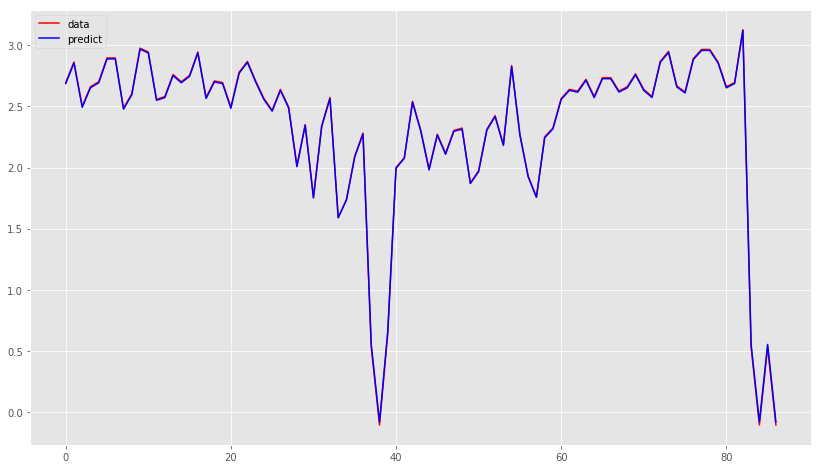

x_scale:  (2, 87, 3, 1)


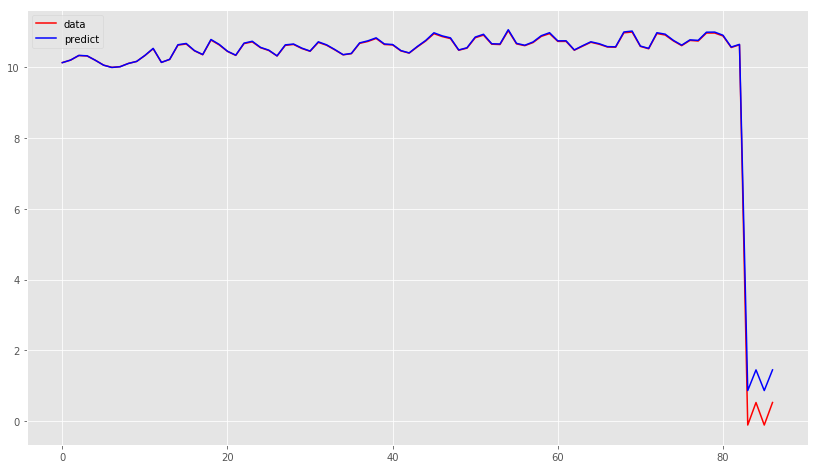

87/87 [==============================] - 0s 64us/step
model evaluate mse: [5.934922766411441, 0.05464874524837253, 5.880273977915446, 0.05464874464890052, 5.880274504080586]


In [43]:
window = time_steps
x_test, scaler = prepare_data_individual(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph_individual(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)

## Task wise Early Stopping適用後の精度を計測

In [44]:
rmse_list = []
for i in range(predict_test.shape[0]):
    print
    rmse = np.sqrt(np.average(np.subtract(x_scale_test[i, :, :, :], predict_test[i, :, :, :]) ** 2))
    print('rmse:', rmse)
    rmse_list.append(rmse)

print(np.average(rmse_list))

rmse: 0.010440176436460833
rmse: 0.12134318987719254
0.06589168315682668
